## Imports

In [1]:
import yaml
import torch
import torch.nn as nn
import numpy as np
import tqdm
import os
import argparse
from utils import get_prior
from torch.backends import cudnn
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt

cudnn.benchmark = True

def delete_module(name):
    import sys
    del sys.modules[name]
    
    
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load the config

In [3]:
config_file = './test_config.yaml'

def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

with open(config_file, 'r') as f:
    config = yaml.load(f)
        
cfg = dict2namespace(config)
cfg

/nfs/rhea.dgp/u6/a/mrsalehi/.virtualenvs/base/lib/python3.6/site-packages/ipykernel_launcher.py:14: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


Namespace(data=Namespace(batch_size=1, cates=['airplane'], data_dir='data/toy-airplane-data', dataset_scale=1, dataset_type='shapenet15k', normalize_per_shape=False, normalize_std_per_axis=False, num_workers=4, recenter_per_shape=True, te_max_sample_points=2048, tr_max_sample_points=2048, type='datasets.pointflow_datasets'), inference=Namespace(num_points=2048, num_steps=10, step_size_ratio=1, weight=1), log=Namespace(log_freq=10, save_dir='log/sigma-begin-1', save_freq=200, val_freq=100, viz_freq=100), models=Namespace(scorenet=Namespace(dim=3, hidden_size=256, n_blocks=24, out_dim=3, param_likelihood=False, sigma_condition=True, type='models.decoders.resnet_add', xyz_condition=True, z_dim=128)), trainer=Namespace(c_iters=10, epochs=2000, opt_criticnet=Namespace(beta1=0.9, beta2=0.999, iters=10, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), opt_scorenet=Namespace(beta1=0.9, beta2=0.999, lr='1e-3', momentum=0.9, scheduler='linear', step_e

In [4]:
cfg.data

Namespace(batch_size=1, cates=['airplane'], data_dir='data/toy-airplane-data', dataset_scale=1, dataset_type='shapenet15k', normalize_per_shape=False, normalize_std_per_axis=False, num_workers=4, recenter_per_shape=True, te_max_sample_points=2048, tr_max_sample_points=2048, type='datasets.pointflow_datasets')

In [5]:
cfg.trainer

Namespace(c_iters=10, epochs=2000, opt_criticnet=Namespace(beta1=0.9, beta2=0.999, iters=10, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), opt_scorenet=Namespace(beta1=0.9, beta2=0.999, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), s_iters=10, seed=100, sigma_begin=1, sigma_end=0.01, sigma_num=10, type='trainers.ae_trainer_3D')

In [6]:
cfg.models

Namespace(scorenet=Namespace(dim=3, hidden_size=256, n_blocks=24, out_dim=3, param_likelihood=False, sigma_condition=True, type='models.decoders.resnet_add', xyz_condition=True, z_dim=128))

In [7]:
cfg.inference

Namespace(num_points=2048, num_steps=10, step_size_ratio=1, weight=1)

In [8]:
cfg.log

Namespace(log_freq=10, save_dir='log/sigma-begin-1', save_freq=200, val_freq=100, viz_freq=100)

# Train

In [9]:
from scorenet import Scorenet
from critic import Criticnet, SmallMLP
from utils import get_opt, set_random_seed, exact_jacobian_trace, langevin_dynamics, visualize
from datasets.data_loader import get_data
import random
import torch.nn.utils.spectral_norm as spectral_norm

In [10]:
set_random_seed(getattr(cfg.trainer, "seed", 666))

# load data
train_data = get_data(cfg.data, 0)
#tr_pts = train_data['tr_points'].unsqueeze(0)
tr_pts = train_data['tr_points']

#te_pts = train_data['te_points'].unsqueeze(0)
te_pts = train_data['te_points']

tr_pts = tr_pts.to(device)
te_pts = te_pts.to(device)
tr_pts.requires_grad_()
te_pts.requires_grad_();

100%|██████████| 1/1 [00:00<00:00, 687.48it/s]


Total number of data:1
Min number of points: (train)2048 (test)2048


### Visualize the data

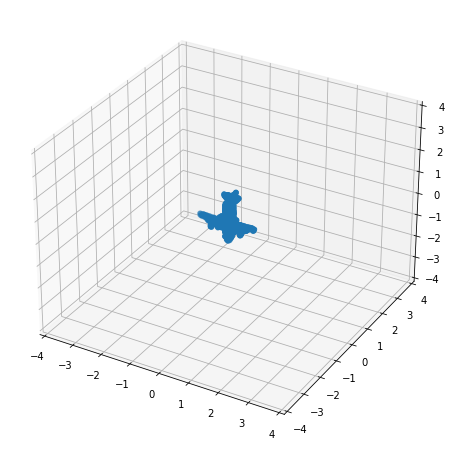

In [11]:
visualize(tr_pts)

In [12]:
# sigmas
if hasattr(cfg.trainer, "sigmas"):
    np_sigmas = cfg.trainer.sigmas
else:
    sigma_begin = float(cfg.trainer.sigma_begin)
    sigma_end = float(cfg.trainer.sigma_end)
    num_classes = int(cfg.trainer.sigma_num)
    np_sigmas = np.exp(np.linspace(np.log(sigma_begin), np.log(sigma_end), num_classes))
print("Sigma:, ", np_sigmas)
sigmas = torch.tensor(np.array(np_sigmas)).float().cuda().view(-1, 1)

Sigma:,  [1.         0.59948425 0.35938137 0.21544347 0.12915497 0.07742637
 0.04641589 0.02782559 0.01668101 0.01      ]


In [13]:
def apply_spectral_norm(module):
    norm = nn.BatchNorm1d
    if not isinstance(module, norm) and 'weight' in module._parameters:
        spectral_norm(module)

In [14]:
# score net
#score_net = Scorenet()
score_net = SmallMLP(in_dim=3)
#critic_net = Criticnet()
critic_net = SmallMLP(in_dim=3)

#critic_net.apply(apply_spectral_norm)
critic_net.to(device)
score_net.to(device)

print(score_net)
print(critic_net)

# optimizer
opt_scorenet, scheduler_scorenet = get_opt(score_net.parameters(), cfg.trainer.opt_scorenet)
opt_criticnet, scheduler_criticnet = get_opt(critic_net.parameters(), cfg.trainer.opt_scorenet)

SmallMLP(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): Swish()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Swish()
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)
SmallMLP(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): Swish()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Swish()
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)


In [15]:
sigmas

tensor([[1.0000],
        [0.5995],
        [0.3594],
        [0.2154],
        [0.1292],
        [0.0774],
        [0.0464],
        [0.0278],
        [0.0167],
        [0.0100]], device='cuda:0')

In [16]:
# training
start_epoch = 0
n_epochs = 25000
print("Start epoch: %d End epoch: %d" % (start_epoch, cfg.trainer.epochs))
k_iters = 5
e_iters = 1
# for epoch in range(start_epoch, cfg.trainer.epochs):
sigmas = sigmas[-1:]

losses = []

for epoch in range(start_epoch, n_epochs):
    score_net.train()
    critic_net.train()
    opt_scorenet.zero_grad()
    opt_criticnet.zero_grad()
    
    perturbed_points = tr_pts + torch.randn_like(tr_pts) * sigmas[..., None]
    
    score_pred = score_net(perturbed_points, sigmas)
    critic_output = critic_net(perturbed_points, sigmas)
    
    t1 = (score_pred * critic_output).sum(-1)
    t2 = exact_jacobian_trace(critic_output, perturbed_points)
    
    stein = t1 + t2
    l2_penalty = (critic_output * critic_output).sum(-1).mean()
    loss = stein.mean()
    losses.append(loss)
    
    cycle_iter = epoch % (k_iters + e_iters)
    cpu_loss = loss.detach().cpu().item()
    cpu_t1 = t1.mean().detach().cpu().item()
    cpu_t2 = t2.mean().detach().cpu().item()
    if cycle_iter < k_iters:
        (-loss + l2_penalty).backward()
        opt_criticnet.step()
        print("Epoch (critic) %d Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2))
    else:
        loss.backward()
        opt_scorenet.step()
        print("Epoch (score) %d Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2))

Start epoch: 0 End epoch: 2000
Epoch (critic) 0 Loss=0.04524 t1=0.00081 t2=0.04442
Epoch (critic) 1 Loss=0.32392 t1=0.00278 t2=0.32114
Epoch (critic) 2 Loss=0.60440 t1=0.00457 t2=0.59983
Epoch (critic) 3 Loss=0.88901 t1=0.00619 t2=0.88283
Epoch (critic) 4 Loss=1.18012 t1=0.00764 t2=1.17247
Epoch (score) 5 Loss=1.47993 t1=0.00894 t2=1.47100
Epoch (critic) 6 Loss=1.46050 t1=-0.01046 t2=1.47096
Epoch (critic) 7 Loss=1.76713 t1=-0.01250 t2=1.77963
Epoch (critic) 8 Loss=2.08598 t1=-0.01457 t2=2.10056
Epoch (critic) 9 Loss=2.41891 t1=-0.01669 t2=2.43560
Epoch (critic) 10 Loss=2.76764 t1=-0.01886 t2=2.78650
Epoch (score) 11 Loss=3.13394 t1=-0.02107 t2=3.15501
Epoch (critic) 12 Loss=3.10033 t1=-0.05464 t2=3.15497
Epoch (critic) 13 Loss=3.48183 t1=-0.05981 t2=3.54164
Epoch (critic) 14 Loss=3.88315 t1=-0.06485 t2=3.94800
Epoch (critic) 15 Loss=4.30545 t1=-0.06990 t2=4.37535
Epoch (critic) 16 Loss=4.74974 t1=-0.07501 t2=4.82475
Epoch (score) 17 Loss=5.21706 t1=-0.08021 t2=5.29727
Epoch (critic) 1

Epoch (critic) 151 Loss=80.12430 t1=-2.82567 t2=82.94996
Epoch (critic) 152 Loss=80.60386 t1=-2.77719 t2=83.38104
Epoch (critic) 153 Loss=81.27956 t1=-2.77439 t2=84.05396
Epoch (critic) 154 Loss=81.78020 t1=-2.73228 t2=84.51248
Epoch (score) 155 Loss=82.35547 t1=-2.73537 t2=85.09084
Epoch (critic) 156 Loss=82.21233 t1=-2.99005 t2=85.20238
Epoch (critic) 157 Loss=82.82827 t1=-2.98284 t2=85.81110
Epoch (critic) 158 Loss=83.30544 t1=-2.94503 t2=86.25048
Epoch (critic) 159 Loss=83.98399 t1=-2.93461 t2=86.91859
Epoch (critic) 160 Loss=84.44023 t1=-2.89657 t2=87.33680
Epoch (score) 161 Loss=85.06366 t1=-2.88404 t2=87.94770
Epoch (critic) 162 Loss=84.86118 t1=-3.12725 t2=87.98843
Epoch (critic) 163 Loss=85.41751 t1=-3.09391 t2=88.51141
Epoch (critic) 164 Loss=86.18766 t1=-3.07180 t2=89.25946
Epoch (critic) 165 Loss=86.75708 t1=-3.01598 t2=89.77306
Epoch (critic) 166 Loss=87.42070 t1=-2.98976 t2=90.41045
Epoch (score) 167 Loss=88.04812 t1=-2.94687 t2=90.99500
Epoch (critic) 168 Loss=87.77458 t

Epoch (critic) 292 Loss=155.01889 t1=-5.07495 t2=160.09384
Epoch (score) 293 Loss=155.98366 t1=-5.23461 t2=161.21826
Epoch (critic) 294 Loss=155.87051 t1=-5.77828 t2=161.64877
Epoch (critic) 295 Loss=156.82170 t1=-5.59936 t2=162.42105
Epoch (critic) 296 Loss=156.69560 t1=-5.51643 t2=162.21204
Epoch (critic) 297 Loss=157.08478 t1=-5.40331 t2=162.48810
Epoch (critic) 298 Loss=157.74792 t1=-5.51009 t2=163.25803
Epoch (score) 299 Loss=159.22144 t1=-5.60839 t2=164.82983
Epoch (critic) 300 Loss=158.19469 t1=-5.99201 t2=164.18671
Epoch (critic) 301 Loss=159.42403 t1=-5.97029 t2=165.39432
Epoch (critic) 302 Loss=159.39777 t1=-6.05314 t2=165.45091
Epoch (critic) 303 Loss=160.04034 t1=-5.88874 t2=165.92908
Epoch (critic) 304 Loss=161.60933 t1=-5.98339 t2=167.59271
Epoch (score) 305 Loss=162.66238 t1=-6.15573 t2=168.81812
Epoch (critic) 306 Loss=162.51657 t1=-6.46946 t2=168.98602
Epoch (critic) 307 Loss=161.53784 t1=-6.33416 t2=167.87201
Epoch (critic) 308 Loss=162.44101 t1=-6.26625 t2=168.70726


Epoch (critic) 432 Loss=209.89410 t1=-13.10206 t2=222.99615
Epoch (critic) 433 Loss=211.58261 t1=-11.95073 t2=223.53334
Epoch (critic) 434 Loss=212.20651 t1=-12.83615 t2=225.04266
Epoch (critic) 435 Loss=214.01321 t1=-11.99636 t2=226.00958
Epoch (critic) 436 Loss=214.39783 t1=-12.25496 t2=226.65277
Epoch (score) 437 Loss=214.01483 t1=-11.22523 t2=225.24005
Epoch (critic) 438 Loss=214.90126 t1=-11.70670 t2=226.60797
Epoch (critic) 439 Loss=213.23039 t1=-12.52286 t2=225.75325
Epoch (critic) 440 Loss=215.22272 t1=-12.31748 t2=227.54021
Epoch (critic) 441 Loss=216.40839 t1=-11.91373 t2=228.32213
Epoch (critic) 442 Loss=217.36554 t1=-11.37615 t2=228.74167
Epoch (score) 443 Loss=216.76340 t1=-10.92459 t2=227.68799
Epoch (critic) 444 Loss=216.78606 t1=-11.08988 t2=227.87595
Epoch (critic) 445 Loss=216.00365 t1=-11.14955 t2=227.15318
Epoch (critic) 446 Loss=217.09546 t1=-11.13418 t2=228.22964
Epoch (critic) 447 Loss=218.64728 t1=-11.48855 t2=230.13582
Epoch (critic) 448 Loss=219.49513 t1=-12.1

Epoch (critic) 571 Loss=264.94086 t1=-2.08994 t2=267.03079
Epoch (critic) 572 Loss=263.51685 t1=-4.87050 t2=268.38733
Epoch (critic) 573 Loss=263.21243 t1=-7.64415 t2=270.85657
Epoch (critic) 574 Loss=263.61990 t1=-5.39710 t2=269.01697
Epoch (score) 575 Loss=265.89722 t1=-4.61656 t2=270.51376
Epoch (critic) 576 Loss=265.30835 t1=-5.19137 t2=270.49976
Epoch (critic) 577 Loss=264.77689 t1=-4.44089 t2=269.21777
Epoch (critic) 578 Loss=266.04080 t1=-4.79545 t2=270.83624
Epoch (critic) 579 Loss=265.98340 t1=-7.48617 t2=273.46954
Epoch (critic) 580 Loss=265.46509 t1=-6.92461 t2=272.38971
Epoch (score) 581 Loss=266.78113 t1=-6.74651 t2=273.52765
Epoch (critic) 582 Loss=265.68500 t1=-6.26035 t2=271.94531
Epoch (critic) 583 Loss=267.97699 t1=-4.51833 t2=272.49530
Epoch (critic) 584 Loss=268.15210 t1=-4.48143 t2=272.63354
Epoch (critic) 585 Loss=268.91495 t1=-3.93424 t2=272.84921
Epoch (critic) 586 Loss=268.87976 t1=-4.04835 t2=272.92813
Epoch (score) 587 Loss=267.63968 t1=-6.07164 t2=273.71133


Epoch (critic) 711 Loss=319.99222 t1=-4.28788 t2=324.28009
Epoch (critic) 712 Loss=318.46091 t1=-5.34652 t2=323.80743
Epoch (score) 713 Loss=321.20166 t1=-3.61359 t2=324.81525
Epoch (critic) 714 Loss=320.19550 t1=-6.89619 t2=327.09167
Epoch (critic) 715 Loss=318.46320 t1=-4.58368 t2=323.04688
Epoch (critic) 716 Loss=316.74564 t1=-2.27990 t2=319.02551
Epoch (critic) 717 Loss=319.93472 t1=-2.00977 t2=321.94446
Epoch (critic) 718 Loss=321.11932 t1=-6.23817 t2=327.35748
Epoch (score) 719 Loss=321.70218 t1=-9.15403 t2=330.85620
Epoch (critic) 720 Loss=322.95844 t1=-7.82225 t2=330.78067
Epoch (critic) 721 Loss=323.65344 t1=-7.02966 t2=330.68311
Epoch (critic) 722 Loss=325.15930 t1=-6.81123 t2=331.97052
Epoch (critic) 723 Loss=326.58478 t1=-2.49696 t2=329.08173
Epoch (critic) 724 Loss=327.45438 t1=-4.75681 t2=332.21118
Epoch (score) 725 Loss=327.57742 t1=-7.89420 t2=335.47162
Epoch (critic) 726 Loss=328.19009 t1=-6.60166 t2=334.79175
Epoch (critic) 727 Loss=325.95654 t1=-9.63922 t2=335.59576


Epoch (critic) 852 Loss=383.48273 t1=-6.07019 t2=389.55292
Epoch (critic) 853 Loss=385.36716 t1=-9.46443 t2=394.83160
Epoch (critic) 854 Loss=382.30853 t1=-3.53060 t2=385.83914
Epoch (critic) 855 Loss=386.97620 t1=-3.42117 t2=390.39737
Epoch (critic) 856 Loss=387.20502 t1=-4.64811 t2=391.85312
Epoch (score) 857 Loss=389.24396 t1=-5.71053 t2=394.95447
Epoch (critic) 858 Loss=386.45880 t1=-6.62803 t2=393.08682
Epoch (critic) 859 Loss=387.58014 t1=-7.56824 t2=395.14838
Epoch (critic) 860 Loss=388.08905 t1=-8.05792 t2=396.14694
Epoch (critic) 861 Loss=392.07245 t1=-9.69464 t2=401.76709
Epoch (critic) 862 Loss=390.43710 t1=-8.69962 t2=399.13672
Epoch (score) 863 Loss=393.07758 t1=-5.72530 t2=398.80289
Epoch (critic) 864 Loss=389.77124 t1=-8.94666 t2=398.71793
Epoch (critic) 865 Loss=389.78088 t1=-6.50667 t2=396.28754
Epoch (critic) 866 Loss=387.44714 t1=-6.18983 t2=393.63696
Epoch (critic) 867 Loss=390.43698 t1=-7.58027 t2=398.01721
Epoch (critic) 868 Loss=389.29907 t1=-9.66369 t2=398.96277

Epoch (critic) 998 Loss=468.20905 t1=-4.93428 t2=473.14331
Epoch (critic) 999 Loss=466.40927 t1=-2.78443 t2=469.19373
Epoch (critic) 1000 Loss=469.18433 t1=-2.46713 t2=471.65149
Epoch (score) 1001 Loss=470.18695 t1=-5.75145 t2=475.93839
Epoch (critic) 1002 Loss=466.97861 t1=-8.22045 t2=475.19907
Epoch (critic) 1003 Loss=468.87842 t1=-5.99437 t2=474.87280
Epoch (critic) 1004 Loss=470.20377 t1=-4.67786 t2=474.88162
Epoch (critic) 1005 Loss=468.81299 t1=-3.11697 t2=471.92993
Epoch (critic) 1006 Loss=470.92664 t1=-1.25242 t2=472.17908
Epoch (score) 1007 Loss=467.95328 t1=-5.41777 t2=473.37103
Epoch (critic) 1008 Loss=463.34665 t1=-3.82584 t2=467.17249
Epoch (critic) 1009 Loss=468.16632 t1=-7.18435 t2=475.35071
Epoch (critic) 1010 Loss=467.29376 t1=-9.04196 t2=476.33569
Epoch (critic) 1011 Loss=467.41257 t1=-8.58308 t2=475.99567
Epoch (critic) 1012 Loss=469.70154 t1=-11.28430 t2=480.98584
Epoch (score) 1013 Loss=469.09998 t1=-6.67263 t2=475.77258
Epoch (critic) 1014 Loss=471.09381 t1=-4.413

Epoch (critic) 1136 Loss=541.72070 t1=-9.46921 t2=551.18994
Epoch (critic) 1137 Loss=542.81500 t1=-3.29094 t2=546.10596
Epoch (critic) 1138 Loss=542.31616 t1=-3.40251 t2=545.71863
Epoch (score) 1139 Loss=541.35938 t1=-6.44693 t2=547.80627
Epoch (critic) 1140 Loss=550.22681 t1=-4.20834 t2=554.43518
Epoch (critic) 1141 Loss=537.54883 t1=-10.99465 t2=548.54346
Epoch (critic) 1142 Loss=547.74518 t1=-6.89644 t2=554.64160
Epoch (critic) 1143 Loss=545.47156 t1=-6.60280 t2=552.07434
Epoch (critic) 1144 Loss=546.71631 t1=-9.95759 t2=556.67389
Epoch (score) 1145 Loss=549.73309 t1=-4.84018 t2=554.57324
Epoch (critic) 1146 Loss=551.37195 t1=-6.53918 t2=557.91113
Epoch (critic) 1147 Loss=550.26733 t1=-3.78248 t2=554.04980
Epoch (critic) 1148 Loss=546.91693 t1=-0.11536 t2=547.03229
Epoch (critic) 1149 Loss=549.70795 t1=2.01133 t2=547.69659
Epoch (critic) 1150 Loss=549.17847 t1=2.06325 t2=547.11517
Epoch (score) 1151 Loss=551.27625 t1=-4.35433 t2=555.63062
Epoch (critic) 1152 Loss=550.51202 t1=-5.022

Epoch (critic) 1274 Loss=618.82288 t1=-3.52446 t2=622.34729
Epoch (critic) 1275 Loss=628.53149 t1=-4.78371 t2=633.31519
Epoch (critic) 1276 Loss=637.03290 t1=4.07241 t2=632.96045
Epoch (score) 1277 Loss=627.35394 t1=-2.52551 t2=629.87946
Epoch (critic) 1278 Loss=632.29834 t1=2.86746 t2=629.43091
Epoch (critic) 1279 Loss=634.30188 t1=-7.41844 t2=641.72034
Epoch (critic) 1280 Loss=619.11084 t1=-15.53331 t2=634.64423
Epoch (critic) 1281 Loss=636.36652 t1=-8.56522 t2=644.93170
Epoch (critic) 1282 Loss=628.60852 t1=0.87142 t2=627.73706
Epoch (score) 1283 Loss=634.75507 t1=4.52684 t2=630.22821
Epoch (critic) 1284 Loss=624.32031 t1=2.03249 t2=622.28778
Epoch (critic) 1285 Loss=629.18500 t1=0.19694 t2=628.98804
Epoch (critic) 1286 Loss=626.30267 t1=-6.30374 t2=632.60645
Epoch (critic) 1287 Loss=620.73865 t1=-8.07756 t2=628.81622
Epoch (critic) 1288 Loss=635.03082 t1=0.35294 t2=634.67792
Epoch (score) 1289 Loss=633.24268 t1=1.03376 t2=632.20886
Epoch (critic) 1290 Loss=622.67432 t1=-1.22332 t2=

Epoch (critic) 1414 Loss=704.57129 t1=-8.07190 t2=712.64319
Epoch (score) 1415 Loss=706.30530 t1=-4.42614 t2=710.73138
Epoch (critic) 1416 Loss=703.76050 t1=-4.03394 t2=707.79443
Epoch (critic) 1417 Loss=700.15515 t1=-2.87969 t2=703.03491
Epoch (critic) 1418 Loss=703.06317 t1=-5.48396 t2=708.54712
Epoch (critic) 1419 Loss=705.10785 t1=-6.42431 t2=711.53210
Epoch (critic) 1420 Loss=709.63257 t1=-5.94448 t2=715.57709
Epoch (score) 1421 Loss=704.69385 t1=-6.48516 t2=711.17902
Epoch (critic) 1422 Loss=713.07263 t1=-7.35167 t2=720.42426
Epoch (critic) 1423 Loss=710.41492 t1=-3.98713 t2=714.40210
Epoch (critic) 1424 Loss=703.15942 t1=-5.84524 t2=709.00464
Epoch (critic) 1425 Loss=705.57678 t1=-3.56493 t2=709.14172
Epoch (critic) 1426 Loss=700.80334 t1=-6.74008 t2=707.54340
Epoch (score) 1427 Loss=718.82831 t1=-11.01779 t2=729.84607
Epoch (critic) 1428 Loss=710.52759 t1=-11.66473 t2=722.19238
Epoch (critic) 1429 Loss=710.57300 t1=-15.10425 t2=725.67725
Epoch (critic) 1430 Loss=713.25012 t1=-1

Epoch (critic) 1557 Loss=785.77002 t1=-15.78399 t2=801.55402
Epoch (critic) 1558 Loss=802.37103 t1=-13.47378 t2=815.84479
Epoch (score) 1559 Loss=804.48199 t1=-13.76676 t2=818.24878
Epoch (critic) 1560 Loss=787.00201 t1=-14.40656 t2=801.40857
Epoch (critic) 1561 Loss=796.27881 t1=-13.19176 t2=809.47058
Epoch (critic) 1562 Loss=797.98505 t1=-14.95438 t2=812.93945
Epoch (critic) 1563 Loss=787.28680 t1=-2.88349 t2=790.17035
Epoch (critic) 1564 Loss=798.07098 t1=-5.15453 t2=803.22552
Epoch (score) 1565 Loss=800.77917 t1=0.43847 t2=800.34070
Epoch (critic) 1566 Loss=796.20331 t1=3.83292 t2=792.37036
Epoch (critic) 1567 Loss=789.02155 t1=-5.77262 t2=794.79419
Epoch (critic) 1568 Loss=789.07861 t1=-2.54239 t2=791.62103
Epoch (critic) 1569 Loss=799.29102 t1=-3.30212 t2=802.59314
Epoch (critic) 1570 Loss=793.43188 t1=-6.06113 t2=799.49298
Epoch (score) 1571 Loss=806.39807 t1=-7.72475 t2=814.12286
Epoch (critic) 1572 Loss=804.49268 t1=-8.39020 t2=812.88293
Epoch (critic) 1573 Loss=804.14917 t1=-

Epoch (critic) 1696 Loss=872.33978 t1=-2.80665 t2=875.14642
Epoch (score) 1697 Loss=868.16455 t1=-7.64615 t2=875.81073
Epoch (critic) 1698 Loss=877.31335 t1=-4.54943 t2=881.86279
Epoch (critic) 1699 Loss=879.93799 t1=-7.54415 t2=887.48218
Epoch (critic) 1700 Loss=883.14392 t1=-10.23405 t2=893.37793
Epoch (critic) 1701 Loss=892.35419 t1=-4.07757 t2=896.43176
Epoch (critic) 1702 Loss=876.55042 t1=-14.10306 t2=890.65344
Epoch (score) 1703 Loss=875.88348 t1=-20.40624 t2=896.28967
Epoch (critic) 1704 Loss=887.28564 t1=-18.14931 t2=905.43494
Epoch (critic) 1705 Loss=881.72705 t1=-15.32614 t2=897.05322
Epoch (critic) 1706 Loss=889.82849 t1=-11.28142 t2=901.10992
Epoch (critic) 1707 Loss=890.79901 t1=-17.31348 t2=908.11249
Epoch (critic) 1708 Loss=896.60779 t1=-11.31902 t2=907.92688
Epoch (score) 1709 Loss=883.36078 t1=-1.13865 t2=884.49939
Epoch (critic) 1710 Loss=887.86188 t1=-4.97897 t2=892.84088
Epoch (critic) 1711 Loss=893.26514 t1=6.38682 t2=886.87836
Epoch (critic) 1712 Loss=881.36560 t

Epoch (score) 1835 Loss=946.46436 t1=-7.63730 t2=954.10162
Epoch (critic) 1836 Loss=939.14941 t1=-8.42643 t2=947.57587
Epoch (critic) 1837 Loss=947.93408 t1=-7.76146 t2=955.69556
Epoch (critic) 1838 Loss=937.47064 t1=-2.27512 t2=939.74573
Epoch (critic) 1839 Loss=940.17285 t1=-7.30292 t2=947.47577
Epoch (critic) 1840 Loss=941.00854 t1=-10.02928 t2=951.03784
Epoch (score) 1841 Loss=953.21118 t1=-12.80217 t2=966.01337
Epoch (critic) 1842 Loss=931.71375 t1=-8.85275 t2=940.56653
Epoch (critic) 1843 Loss=957.42529 t1=1.75478 t2=955.67053
Epoch (critic) 1844 Loss=935.24213 t1=-8.01949 t2=943.26160
Epoch (critic) 1845 Loss=951.54694 t1=-17.53983 t2=969.08673
Epoch (critic) 1846 Loss=963.17139 t1=-14.72840 t2=977.89978
Epoch (score) 1847 Loss=961.45911 t1=-21.26702 t2=982.72620
Epoch (critic) 1848 Loss=946.32458 t1=-17.01575 t2=963.34033
Epoch (critic) 1849 Loss=959.86749 t1=-16.09709 t2=975.96460
Epoch (critic) 1850 Loss=960.28839 t1=-13.38756 t2=973.67590
Epoch (critic) 1851 Loss=963.27277 t

Epoch (score) 1979 Loss=1015.94916 t1=-13.56097 t2=1029.51013
Epoch (critic) 1980 Loss=1024.03882 t1=-5.42430 t2=1029.46313
Epoch (critic) 1981 Loss=1010.10156 t1=-15.36198 t2=1025.46350
Epoch (critic) 1982 Loss=1009.34369 t1=-4.95560 t2=1014.29919
Epoch (critic) 1983 Loss=1018.42981 t1=0.66748 t2=1017.76227
Epoch (critic) 1984 Loss=1014.62134 t1=2.12559 t2=1012.49573
Epoch (score) 1985 Loss=1010.77789 t1=-7.64785 t2=1018.42572
Epoch (critic) 1986 Loss=1026.14990 t1=-5.16454 t2=1031.31445
Epoch (critic) 1987 Loss=1018.88782 t1=-15.94181 t2=1034.82959
Epoch (critic) 1988 Loss=1025.84888 t1=-2.98192 t2=1028.83069
Epoch (critic) 1989 Loss=1016.53094 t1=-9.70909 t2=1026.23999
Epoch (critic) 1990 Loss=1029.89648 t1=-14.22155 t2=1044.11804
Epoch (score) 1991 Loss=1024.49890 t1=-2.08195 t2=1026.58081
Epoch (critic) 1992 Loss=1009.21667 t1=-5.22356 t2=1014.44025
Epoch (critic) 1993 Loss=1026.06592 t1=0.44716 t2=1025.61865
Epoch (critic) 1994 Loss=1017.97577 t1=-5.95061 t2=1023.92639
Epoch (cri

Epoch (critic) 2116 Loss=1068.05664 t1=-7.01547 t2=1075.07227
Epoch (score) 2117 Loss=1064.43970 t1=0.21127 t2=1064.22852
Epoch (critic) 2118 Loss=1068.87708 t1=4.57435 t2=1064.30273
Epoch (critic) 2119 Loss=1065.60364 t1=-5.42718 t2=1071.03088
Epoch (critic) 2120 Loss=1068.55396 t1=-9.23486 t2=1077.78882
Epoch (critic) 2121 Loss=1076.10059 t1=-24.54741 t2=1100.64795
Epoch (critic) 2122 Loss=1085.98303 t1=-11.32999 t2=1097.31299
Epoch (score) 2123 Loss=1063.10767 t1=-18.16721 t2=1081.27478
Epoch (critic) 2124 Loss=1064.70178 t1=-12.53746 t2=1077.23926
Epoch (critic) 2125 Loss=1075.84692 t1=-18.65890 t2=1094.50586
Epoch (critic) 2126 Loss=1073.56665 t1=-14.12829 t2=1087.69495
Epoch (critic) 2127 Loss=1068.59814 t1=-15.02547 t2=1083.62366
Epoch (critic) 2128 Loss=1074.00781 t1=-14.65056 t2=1088.65845
Epoch (score) 2129 Loss=1077.33960 t1=-9.17946 t2=1086.51917
Epoch (critic) 2130 Loss=1080.49487 t1=-5.21468 t2=1085.70947
Epoch (critic) 2131 Loss=1080.05310 t1=-11.61189 t2=1091.66492
Epoc

Epoch (score) 2249 Loss=1134.79004 t1=-8.63335 t2=1143.42346
Epoch (critic) 2250 Loss=1127.91467 t1=-17.09005 t2=1145.00488
Epoch (critic) 2251 Loss=1115.56799 t1=-8.58584 t2=1124.15381
Epoch (critic) 2252 Loss=1126.65527 t1=-5.23625 t2=1131.89160
Epoch (critic) 2253 Loss=1120.70801 t1=3.19003 t2=1117.51794
Epoch (critic) 2254 Loss=1105.22534 t1=8.13629 t2=1097.08887
Epoch (score) 2255 Loss=1120.77820 t1=-1.89147 t2=1122.66968
Epoch (critic) 2256 Loss=1122.23669 t1=0.23706 t2=1121.99963
Epoch (critic) 2257 Loss=1110.76123 t1=4.64621 t2=1106.11499
Epoch (critic) 2258 Loss=1116.95996 t1=-13.39075 t2=1130.35059
Epoch (critic) 2259 Loss=1106.89478 t1=-15.51593 t2=1122.41077
Epoch (critic) 2260 Loss=1125.50415 t1=-18.05088 t2=1143.55505
Epoch (score) 2261 Loss=1135.16724 t1=-19.89667 t2=1155.06396
Epoch (critic) 2262 Loss=1130.67126 t1=-5.12530 t2=1135.79663
Epoch (critic) 2263 Loss=1126.22388 t1=-3.72301 t2=1129.94690
Epoch (critic) 2264 Loss=1130.19897 t1=-8.13374 t2=1138.33289
Epoch (cri

Epoch (score) 2387 Loss=1174.97217 t1=-9.62911 t2=1184.60132
Epoch (critic) 2388 Loss=1196.61743 t1=-1.56025 t2=1198.17761
Epoch (critic) 2389 Loss=1194.86877 t1=-14.16506 t2=1209.03394
Epoch (critic) 2390 Loss=1182.01111 t1=-0.64907 t2=1182.66016
Epoch (critic) 2391 Loss=1179.08606 t1=6.83187 t2=1172.25403
Epoch (critic) 2392 Loss=1169.03955 t1=0.60206 t2=1168.43738
Epoch (score) 2393 Loss=1175.11340 t1=0.52662 t2=1174.58679
Epoch (critic) 2394 Loss=1168.90112 t1=-5.10124 t2=1174.00244
Epoch (critic) 2395 Loss=1175.31226 t1=-3.34705 t2=1178.65942
Epoch (critic) 2396 Loss=1150.71704 t1=0.26150 t2=1150.45544
Epoch (critic) 2397 Loss=1176.00049 t1=-3.48404 t2=1179.48462
Epoch (critic) 2398 Loss=1165.81982 t1=-0.82988 t2=1166.64966
Epoch (score) 2399 Loss=1184.48608 t1=-10.76296 t2=1195.24902
Epoch (critic) 2400 Loss=1177.52246 t1=-14.05797 t2=1191.58032
Epoch (critic) 2401 Loss=1176.93359 t1=-8.61039 t2=1185.54395
Epoch (critic) 2402 Loss=1188.33081 t1=-9.88519 t2=1198.21606
Epoch (criti

Epoch (critic) 2527 Loss=1222.20630 t1=-10.28775 t2=1232.49402
Epoch (critic) 2528 Loss=1209.34399 t1=-15.23940 t2=1224.58337
Epoch (critic) 2529 Loss=1219.04565 t1=-21.40813 t2=1240.45386
Epoch (critic) 2530 Loss=1213.24524 t1=-14.63520 t2=1227.88037
Epoch (score) 2531 Loss=1219.28418 t1=-10.12225 t2=1229.40637
Epoch (critic) 2532 Loss=1218.72803 t1=-26.64053 t2=1245.36865
Epoch (critic) 2533 Loss=1216.89380 t1=-8.74555 t2=1225.63940
Epoch (critic) 2534 Loss=1223.08911 t1=-9.46955 t2=1232.55859
Epoch (critic) 2535 Loss=1220.84570 t1=-14.75860 t2=1235.60449
Epoch (critic) 2536 Loss=1221.03711 t1=-0.88096 t2=1221.91797
Epoch (score) 2537 Loss=1221.07434 t1=4.24670 t2=1216.82764
Epoch (critic) 2538 Loss=1212.94800 t1=-7.97996 t2=1220.92798
Epoch (critic) 2539 Loss=1211.81970 t1=-7.82481 t2=1219.64453
Epoch (critic) 2540 Loss=1244.57910 t1=-4.70217 t2=1249.28137
Epoch (critic) 2541 Loss=1212.27563 t1=-2.89560 t2=1215.17126
Epoch (critic) 2542 Loss=1213.33276 t1=-10.61237 t2=1223.94519
Epo

Epoch (critic) 2659 Loss=1275.60327 t1=-11.13548 t2=1286.73877
Epoch (critic) 2660 Loss=1266.05347 t1=-3.12576 t2=1269.17932
Epoch (critic) 2661 Loss=1257.26416 t1=-6.59095 t2=1263.85498
Epoch (critic) 2662 Loss=1260.73596 t1=-4.58712 t2=1265.32324
Epoch (score) 2663 Loss=1252.89868 t1=-12.73387 t2=1265.63257
Epoch (critic) 2664 Loss=1264.18726 t1=-12.75535 t2=1276.94263
Epoch (critic) 2665 Loss=1273.19531 t1=-12.66062 t2=1285.85596
Epoch (critic) 2666 Loss=1263.27026 t1=-6.45825 t2=1269.72876
Epoch (critic) 2667 Loss=1283.93921 t1=7.22687 t2=1276.71240
Epoch (critic) 2668 Loss=1285.64648 t1=19.63961 t2=1266.00684
Epoch (score) 2669 Loss=1270.16028 t1=1.49887 t2=1268.66138
Epoch (critic) 2670 Loss=1270.14233 t1=-4.44564 t2=1274.58789
Epoch (critic) 2671 Loss=1246.08069 t1=-8.55329 t2=1254.63403
Epoch (critic) 2672 Loss=1281.14026 t1=-4.73607 t2=1285.87622
Epoch (critic) 2673 Loss=1263.62378 t1=-19.09834 t2=1282.72217
Epoch (critic) 2674 Loss=1266.61792 t1=-12.99624 t2=1279.61401
Epoch 

Epoch (critic) 2791 Loss=1295.34985 t1=-6.91187 t2=1302.26172
Epoch (critic) 2792 Loss=1286.53735 t1=-3.17811 t2=1289.71533
Epoch (critic) 2793 Loss=1306.15991 t1=-10.52989 t2=1316.68970
Epoch (critic) 2794 Loss=1296.04565 t1=-9.83745 t2=1305.88330
Epoch (score) 2795 Loss=1287.13379 t1=-7.05651 t2=1294.19031
Epoch (critic) 2796 Loss=1277.14380 t1=-16.11024 t2=1293.25391
Epoch (critic) 2797 Loss=1293.51099 t1=-1.07514 t2=1294.58618
Epoch (critic) 2798 Loss=1292.67761 t1=-17.74349 t2=1310.42114
Epoch (critic) 2799 Loss=1314.16528 t1=-17.39755 t2=1331.56299
Epoch (critic) 2800 Loss=1288.80200 t1=-17.69377 t2=1306.49561
Epoch (score) 2801 Loss=1314.79663 t1=-17.87877 t2=1332.67529
Epoch (critic) 2802 Loss=1295.38452 t1=-26.88058 t2=1322.26514
Epoch (critic) 2803 Loss=1300.79822 t1=-28.83577 t2=1329.63403
Epoch (critic) 2804 Loss=1314.35913 t1=-8.34243 t2=1322.70166
Epoch (critic) 2805 Loss=1296.53760 t1=-4.57071 t2=1301.10840
Epoch (critic) 2806 Loss=1311.98328 t1=6.35479 t2=1305.62842
Epo

Epoch (critic) 2928 Loss=1323.81299 t1=-11.47258 t2=1335.28552
Epoch (critic) 2929 Loss=1331.94397 t1=-4.93283 t2=1336.87671
Epoch (critic) 2930 Loss=1322.10559 t1=-3.51243 t2=1325.61792
Epoch (critic) 2931 Loss=1341.51440 t1=-3.07648 t2=1344.59082
Epoch (critic) 2932 Loss=1323.99182 t1=-9.44695 t2=1333.43872
Epoch (score) 2933 Loss=1327.69775 t1=-13.14614 t2=1340.84375
Epoch (critic) 2934 Loss=1338.89697 t1=-11.06209 t2=1349.95898
Epoch (critic) 2935 Loss=1327.96204 t1=6.37216 t2=1321.58984
Epoch (critic) 2936 Loss=1324.16589 t1=-9.67436 t2=1333.84033
Epoch (critic) 2937 Loss=1359.58447 t1=-9.01283 t2=1368.59729
Epoch (critic) 2938 Loss=1328.23486 t1=-14.47348 t2=1342.70825
Epoch (score) 2939 Loss=1331.53955 t1=-15.70823 t2=1347.24768
Epoch (critic) 2940 Loss=1333.45715 t1=-19.72788 t2=1353.18506
Epoch (critic) 2941 Loss=1338.29443 t1=1.14764 t2=1337.14661
Epoch (critic) 2942 Loss=1345.55383 t1=2.00396 t2=1343.54993
Epoch (critic) 2943 Loss=1345.65771 t1=6.46717 t2=1339.19067
Epoch (c

Epoch (critic) 3061 Loss=1347.77246 t1=-9.30850 t2=1357.08093
Epoch (critic) 3062 Loss=1373.89148 t1=-4.23098 t2=1378.12244
Epoch (critic) 3063 Loss=1372.04053 t1=-27.92155 t2=1399.96204
Epoch (critic) 3064 Loss=1365.84741 t1=-13.80248 t2=1379.64990
Epoch (score) 3065 Loss=1357.68530 t1=8.38203 t2=1349.30334
Epoch (critic) 3066 Loss=1357.50366 t1=-13.66808 t2=1371.17163
Epoch (critic) 3067 Loss=1376.88562 t1=-12.65598 t2=1389.54163
Epoch (critic) 3068 Loss=1356.25269 t1=-8.44782 t2=1364.70056
Epoch (critic) 3069 Loss=1368.37402 t1=-11.55920 t2=1379.93323
Epoch (critic) 3070 Loss=1372.94177 t1=-0.92875 t2=1373.87048
Epoch (score) 3071 Loss=1352.39551 t1=-12.50846 t2=1364.90405
Epoch (critic) 3072 Loss=1366.86914 t1=-4.70010 t2=1371.56921
Epoch (critic) 3073 Loss=1375.47510 t1=-3.22569 t2=1378.70081
Epoch (critic) 3074 Loss=1358.62207 t1=-9.34198 t2=1367.96399
Epoch (critic) 3075 Loss=1370.05896 t1=-13.52495 t2=1383.58398
Epoch (critic) 3076 Loss=1373.01025 t1=-4.54568 t2=1377.55591
Epoc

Epoch (critic) 3201 Loss=1395.56299 t1=-20.89832 t2=1416.46118
Epoch (critic) 3202 Loss=1440.08704 t1=-14.64720 t2=1454.73413
Epoch (score) 3203 Loss=1403.09619 t1=1.31168 t2=1401.78467
Epoch (critic) 3204 Loss=1421.15454 t1=-3.88203 t2=1425.03662
Epoch (critic) 3205 Loss=1407.51709 t1=-1.50520 t2=1409.02222
Epoch (critic) 3206 Loss=1407.15332 t1=3.30272 t2=1403.85059
Epoch (critic) 3207 Loss=1420.11670 t1=-0.80726 t2=1420.92407
Epoch (critic) 3208 Loss=1426.93311 t1=-5.03569 t2=1431.96875
Epoch (score) 3209 Loss=1401.57837 t1=-1.99514 t2=1403.57361
Epoch (critic) 3210 Loss=1428.08276 t1=6.11360 t2=1421.96924
Epoch (critic) 3211 Loss=1383.71021 t1=-4.62195 t2=1388.33215
Epoch (critic) 3212 Loss=1386.17944 t1=-17.62567 t2=1403.80493
Epoch (critic) 3213 Loss=1407.22729 t1=-8.60451 t2=1415.83179
Epoch (critic) 3214 Loss=1423.67310 t1=-17.69017 t2=1441.36340
Epoch (score) 3215 Loss=1390.53357 t1=-27.87163 t2=1418.40527
Epoch (critic) 3216 Loss=1391.55957 t1=-29.89167 t2=1421.45117
Epoch (c

Epoch (score) 3341 Loss=1427.86316 t1=-9.81733 t2=1437.68066
Epoch (critic) 3342 Loss=1439.21875 t1=-8.93245 t2=1448.15137
Epoch (critic) 3343 Loss=1424.11548 t1=-0.39256 t2=1424.50818
Epoch (critic) 3344 Loss=1436.74622 t1=-7.34117 t2=1444.08740
Epoch (critic) 3345 Loss=1433.87561 t1=0.26735 t2=1433.60815
Epoch (critic) 3346 Loss=1440.67920 t1=-7.59914 t2=1448.27832
Epoch (score) 3347 Loss=1440.80054 t1=-14.44098 t2=1455.24146
Epoch (critic) 3348 Loss=1432.23572 t1=-15.14117 t2=1447.37695
Epoch (critic) 3349 Loss=1418.53821 t1=-31.52249 t2=1450.06079
Epoch (critic) 3350 Loss=1449.73657 t1=-23.82367 t2=1473.56006
Epoch (critic) 3351 Loss=1431.05566 t1=-7.35746 t2=1438.41309
Epoch (critic) 3352 Loss=1437.71472 t1=-16.11815 t2=1453.83289
Epoch (score) 3353 Loss=1447.37146 t1=-14.23485 t2=1461.60620
Epoch (critic) 3354 Loss=1435.18958 t1=-19.12634 t2=1454.31592
Epoch (critic) 3355 Loss=1438.82324 t1=-25.73439 t2=1464.55762
Epoch (critic) 3356 Loss=1454.81519 t1=-9.27884 t2=1464.09399
Epoc

Epoch (critic) 3483 Loss=1468.06519 t1=-23.82757 t2=1491.89282
Epoch (critic) 3484 Loss=1441.61353 t1=-15.74863 t2=1457.36206
Epoch (score) 3485 Loss=1472.48047 t1=4.07389 t2=1468.40662
Epoch (critic) 3486 Loss=1488.71973 t1=-0.10524 t2=1488.82495
Epoch (critic) 3487 Loss=1453.72583 t1=12.78851 t2=1440.93726
Epoch (critic) 3488 Loss=1459.35083 t1=-13.26453 t2=1472.61523
Epoch (critic) 3489 Loss=1473.84229 t1=11.05633 t2=1462.78601
Epoch (critic) 3490 Loss=1464.80750 t1=2.16328 t2=1462.64429
Epoch (score) 3491 Loss=1477.03186 t1=0.10560 t2=1476.92627
Epoch (critic) 3492 Loss=1485.11450 t1=16.87486 t2=1468.23950
Epoch (critic) 3493 Loss=1466.75391 t1=-2.73647 t2=1469.49048
Epoch (critic) 3494 Loss=1464.44714 t1=-5.20921 t2=1469.65625
Epoch (critic) 3495 Loss=1500.22046 t1=-17.71213 t2=1517.93262
Epoch (critic) 3496 Loss=1470.61353 t1=-32.19769 t2=1502.81116
Epoch (score) 3497 Loss=1448.90198 t1=-34.00047 t2=1482.90259
Epoch (critic) 3498 Loss=1477.32471 t1=-34.12090 t2=1511.44556
Epoch (

Epoch (critic) 3622 Loss=1479.74597 t1=-13.50090 t2=1493.24683
Epoch (score) 3623 Loss=1525.76807 t1=1.39098 t2=1524.37720
Epoch (critic) 3624 Loss=1488.88257 t1=-3.15674 t2=1492.03931
Epoch (critic) 3625 Loss=1489.73047 t1=3.99740 t2=1485.73315
Epoch (critic) 3626 Loss=1509.07397 t1=-9.58363 t2=1518.65747
Epoch (critic) 3627 Loss=1504.70264 t1=-18.78292 t2=1523.48560
Epoch (critic) 3628 Loss=1507.69104 t1=-7.37249 t2=1515.06348
Epoch (score) 3629 Loss=1509.36621 t1=2.63282 t2=1506.73340
Epoch (critic) 3630 Loss=1494.43628 t1=-5.70748 t2=1500.14368
Epoch (critic) 3631 Loss=1499.78125 t1=-3.73840 t2=1503.51978
Epoch (critic) 3632 Loss=1507.55078 t1=-2.22564 t2=1509.77649
Epoch (critic) 3633 Loss=1476.45508 t1=-12.88059 t2=1489.33569
Epoch (critic) 3634 Loss=1511.49573 t1=-10.45636 t2=1521.95215
Epoch (score) 3635 Loss=1497.35376 t1=2.22710 t2=1495.12646
Epoch (critic) 3636 Loss=1500.33228 t1=-11.73578 t2=1512.06799
Epoch (critic) 3637 Loss=1500.52039 t1=-2.89533 t2=1503.41577
Epoch (cri

Epoch (critic) 3764 Loss=1542.84180 t1=-8.59118 t2=1551.43298
Epoch (critic) 3765 Loss=1521.64722 t1=-14.97821 t2=1536.62549
Epoch (critic) 3766 Loss=1533.34888 t1=-13.33133 t2=1546.68018
Epoch (score) 3767 Loss=1546.36328 t1=-14.66711 t2=1561.03052
Epoch (critic) 3768 Loss=1513.42957 t1=-17.94434 t2=1531.37402
Epoch (critic) 3769 Loss=1541.86841 t1=-11.36434 t2=1553.23279
Epoch (critic) 3770 Loss=1515.99341 t1=-7.95230 t2=1523.94580
Epoch (critic) 3771 Loss=1531.87573 t1=1.71412 t2=1530.16150
Epoch (critic) 3772 Loss=1532.54419 t1=5.89440 t2=1526.64978
Epoch (score) 3773 Loss=1506.37646 t1=-16.24097 t2=1522.61743
Epoch (critic) 3774 Loss=1506.62695 t1=-15.63453 t2=1522.26147
Epoch (critic) 3775 Loss=1508.68640 t1=-9.68996 t2=1518.37634
Epoch (critic) 3776 Loss=1533.00342 t1=-22.99915 t2=1556.00269
Epoch (critic) 3777 Loss=1521.92822 t1=-12.35178 t2=1534.28003
Epoch (critic) 3778 Loss=1489.44324 t1=-20.85100 t2=1510.29443
Epoch (score) 3779 Loss=1502.80737 t1=-24.40429 t2=1527.21167
Ep

Epoch (critic) 3904 Loss=1539.19385 t1=-16.44837 t2=1555.64209
Epoch (score) 3905 Loss=1558.50146 t1=-5.93211 t2=1564.43359
Epoch (critic) 3906 Loss=1553.06848 t1=-1.33871 t2=1554.40710
Epoch (critic) 3907 Loss=1542.78784 t1=-5.25086 t2=1548.03882
Epoch (critic) 3908 Loss=1561.22729 t1=-8.76343 t2=1569.99072
Epoch (critic) 3909 Loss=1537.97034 t1=-13.49004 t2=1551.46033
Epoch (critic) 3910 Loss=1557.89587 t1=-6.81502 t2=1564.71094
Epoch (score) 3911 Loss=1572.36743 t1=-23.14224 t2=1595.50977
Epoch (critic) 3912 Loss=1535.97754 t1=-15.24740 t2=1551.22498
Epoch (critic) 3913 Loss=1555.67297 t1=-15.22294 t2=1570.89600
Epoch (critic) 3914 Loss=1548.38586 t1=-25.79661 t2=1574.18250
Epoch (critic) 3915 Loss=1552.23730 t1=-23.57525 t2=1575.81250
Epoch (critic) 3916 Loss=1550.05811 t1=-25.54276 t2=1575.60095
Epoch (score) 3917 Loss=1554.96069 t1=-16.91631 t2=1571.87695
Epoch (critic) 3918 Loss=1540.14185 t1=-11.36081 t2=1551.50269
Epoch (critic) 3919 Loss=1577.02856 t1=-15.93340 t2=1592.96191


Epoch (score) 4043 Loss=1576.77417 t1=-17.27721 t2=1594.05127
Epoch (critic) 4044 Loss=1579.99792 t1=-13.44543 t2=1593.44336
Epoch (critic) 4045 Loss=1576.11621 t1=-27.19840 t2=1603.31458
Epoch (critic) 4046 Loss=1579.47241 t1=-28.74420 t2=1608.21655
Epoch (critic) 4047 Loss=1589.57263 t1=-30.82325 t2=1620.39587
Epoch (critic) 4048 Loss=1595.89282 t1=-18.36085 t2=1614.25354
Epoch (score) 4049 Loss=1589.69531 t1=-22.57172 t2=1612.26697
Epoch (critic) 4050 Loss=1579.03979 t1=-17.32406 t2=1596.36377
Epoch (critic) 4051 Loss=1591.60645 t1=-26.21426 t2=1617.82080
Epoch (critic) 4052 Loss=1551.63818 t1=-23.77328 t2=1575.41162
Epoch (critic) 4053 Loss=1577.25391 t1=-8.54733 t2=1585.80127
Epoch (critic) 4054 Loss=1578.34912 t1=14.91277 t2=1563.43640
Epoch (score) 4055 Loss=1584.39893 t1=10.18320 t2=1574.21570
Epoch (critic) 4056 Loss=1593.60400 t1=9.52519 t2=1584.07886
Epoch (critic) 4057 Loss=1598.53320 t1=11.44178 t2=1587.09131
Epoch (critic) 4058 Loss=1571.93335 t1=-6.54200 t2=1578.47522
Ep

Epoch (critic) 4184 Loss=1577.81812 t1=-36.23462 t2=1614.05273
Epoch (critic) 4185 Loss=1575.86292 t1=-18.10537 t2=1593.96826
Epoch (critic) 4186 Loss=1601.01868 t1=-2.33099 t2=1603.34961
Epoch (score) 4187 Loss=1591.75989 t1=-11.76859 t2=1603.52844
Epoch (critic) 4188 Loss=1591.82349 t1=-3.27501 t2=1595.09863
Epoch (critic) 4189 Loss=1579.29138 t1=-5.52529 t2=1584.81665
Epoch (critic) 4190 Loss=1595.81519 t1=-0.28723 t2=1596.10242
Epoch (critic) 4191 Loss=1590.80383 t1=0.67235 t2=1590.13159
Epoch (critic) 4192 Loss=1597.43811 t1=1.93319 t2=1595.50488
Epoch (score) 4193 Loss=1622.22168 t1=-8.60437 t2=1630.82617
Epoch (critic) 4194 Loss=1594.82385 t1=-17.14894 t2=1611.97278
Epoch (critic) 4195 Loss=1582.34985 t1=-24.46675 t2=1606.81653
Epoch (critic) 4196 Loss=1615.41895 t1=-25.52127 t2=1640.94019
Epoch (critic) 4197 Loss=1594.27905 t1=-38.47886 t2=1632.75781
Epoch (critic) 4198 Loss=1600.17725 t1=-43.00903 t2=1643.18640
Epoch (score) 4199 Loss=1608.96411 t1=-17.89526 t2=1626.85938
Epoc

Epoch (score) 4325 Loss=1604.34607 t1=-27.69202 t2=1632.03809
Epoch (critic) 4326 Loss=1607.69324 t1=-42.65407 t2=1650.34729
Epoch (critic) 4327 Loss=1609.81702 t1=-26.12654 t2=1635.94348
Epoch (critic) 4328 Loss=1636.15491 t1=-27.13008 t2=1663.28491
Epoch (critic) 4329 Loss=1602.21936 t1=-10.46945 t2=1612.68884
Epoch (critic) 4330 Loss=1629.71545 t1=-14.78169 t2=1644.49719
Epoch (score) 4331 Loss=1605.88770 t1=-2.65230 t2=1608.54004
Epoch (critic) 4332 Loss=1607.68701 t1=4.62666 t2=1603.06042
Epoch (critic) 4333 Loss=1627.53467 t1=-10.28600 t2=1637.82080
Epoch (critic) 4334 Loss=1605.77686 t1=-26.11406 t2=1631.89087
Epoch (critic) 4335 Loss=1603.19177 t1=-23.76456 t2=1626.95630
Epoch (critic) 4336 Loss=1599.89490 t1=-26.83899 t2=1626.73389
Epoch (score) 4337 Loss=1619.89478 t1=-7.21955 t2=1627.11426
Epoch (critic) 4338 Loss=1618.34583 t1=-14.21618 t2=1632.56213
Epoch (critic) 4339 Loss=1620.80811 t1=-15.19315 t2=1636.00122
Epoch (critic) 4340 Loss=1639.98145 t1=-6.60067 t2=1646.58215


Epoch (critic) 4460 Loss=1608.31470 t1=-34.10884 t2=1642.42358
Epoch (critic) 4461 Loss=1631.23621 t1=-28.97563 t2=1660.21191
Epoch (critic) 4462 Loss=1664.38721 t1=-23.38853 t2=1687.77563
Epoch (score) 4463 Loss=1646.10474 t1=-21.24166 t2=1667.34644
Epoch (critic) 4464 Loss=1636.55029 t1=-35.27505 t2=1671.82544
Epoch (critic) 4465 Loss=1647.47510 t1=-25.05159 t2=1672.52661
Epoch (critic) 4466 Loss=1642.73523 t1=4.39209 t2=1638.34314
Epoch (critic) 4467 Loss=1621.49377 t1=-6.31492 t2=1627.80872
Epoch (critic) 4468 Loss=1640.95105 t1=-10.96912 t2=1651.92017
Epoch (score) 4469 Loss=1652.30786 t1=-20.28833 t2=1672.59619
Epoch (critic) 4470 Loss=1655.56812 t1=-30.42149 t2=1685.98962
Epoch (critic) 4471 Loss=1630.53101 t1=-33.62740 t2=1664.15845
Epoch (critic) 4472 Loss=1659.24756 t1=-27.04066 t2=1686.28821
Epoch (critic) 4473 Loss=1660.68408 t1=-15.89099 t2=1676.57520
Epoch (critic) 4474 Loss=1641.81482 t1=-7.39779 t2=1649.21252
Epoch (score) 4475 Loss=1624.69714 t1=-10.85975 t2=1635.55688

Epoch (critic) 4593 Loss=1653.09509 t1=-6.02419 t2=1659.11926
Epoch (critic) 4594 Loss=1676.62695 t1=-16.00375 t2=1692.63074
Epoch (score) 4595 Loss=1682.88867 t1=-15.23992 t2=1698.12866
Epoch (critic) 4596 Loss=1646.95422 t1=-24.66158 t2=1671.61572
Epoch (critic) 4597 Loss=1634.96094 t1=-24.70773 t2=1659.66870
Epoch (critic) 4598 Loss=1638.90356 t1=-28.84249 t2=1667.74609
Epoch (critic) 4599 Loss=1631.01538 t1=-19.03802 t2=1650.05334
Epoch (critic) 4600 Loss=1641.53320 t1=-14.52788 t2=1656.06104
Epoch (score) 4601 Loss=1657.97632 t1=-31.54029 t2=1689.51660
Epoch (critic) 4602 Loss=1640.26514 t1=-27.77440 t2=1668.03955
Epoch (critic) 4603 Loss=1629.91809 t1=-41.76060 t2=1671.67871
Epoch (critic) 4604 Loss=1662.05835 t1=-20.68648 t2=1682.74487
Epoch (critic) 4605 Loss=1640.35229 t1=-27.49511 t2=1667.84741
Epoch (critic) 4606 Loss=1631.27808 t1=-17.96758 t2=1649.24561
Epoch (score) 4607 Loss=1655.90063 t1=-13.22663 t2=1669.12720
Epoch (critic) 4608 Loss=1645.64038 t1=-12.06778 t2=1657.70

Epoch (critic) 4724 Loss=1660.91382 t1=-34.03244 t2=1694.94629
Epoch (critic) 4725 Loss=1690.97900 t1=-14.59365 t2=1705.57263
Epoch (critic) 4726 Loss=1694.67639 t1=-25.16278 t2=1719.83911
Epoch (score) 4727 Loss=1675.98804 t1=-12.16545 t2=1688.15332
Epoch (critic) 4728 Loss=1662.48364 t1=-19.62607 t2=1682.10974
Epoch (critic) 4729 Loss=1662.47791 t1=-20.00319 t2=1682.48096
Epoch (critic) 4730 Loss=1669.28979 t1=5.06166 t2=1664.22815
Epoch (critic) 4731 Loss=1684.81421 t1=33.36890 t2=1651.44531
Epoch (critic) 4732 Loss=1669.76758 t1=23.77101 t2=1645.99658
Epoch (score) 4733 Loss=1707.96167 t1=13.41773 t2=1694.54395
Epoch (critic) 4734 Loss=1698.84387 t1=10.90087 t2=1687.94299
Epoch (critic) 4735 Loss=1689.92017 t1=-7.89320 t2=1697.81323
Epoch (critic) 4736 Loss=1670.34973 t1=-12.15906 t2=1682.50879
Epoch (critic) 4737 Loss=1685.09009 t1=-23.27276 t2=1708.36292
Epoch (critic) 4738 Loss=1690.62720 t1=-11.38377 t2=1702.01099
Epoch (score) 4739 Loss=1677.94434 t1=-16.67269 t2=1694.61719
Ep

Epoch (score) 4865 Loss=1694.01794 t1=-8.14012 t2=1702.15796
Epoch (critic) 4866 Loss=1667.05786 t1=-0.74463 t2=1667.80249
Epoch (critic) 4867 Loss=1691.51123 t1=-9.76205 t2=1701.27332
Epoch (critic) 4868 Loss=1689.99731 t1=-14.51420 t2=1704.51147
Epoch (critic) 4869 Loss=1701.72876 t1=-10.77155 t2=1712.50024
Epoch (critic) 4870 Loss=1666.38965 t1=-31.85497 t2=1698.24463
Epoch (score) 4871 Loss=1682.77271 t1=-17.40257 t2=1700.17529
Epoch (critic) 4872 Loss=1684.50366 t1=-0.90123 t2=1685.40503
Epoch (critic) 4873 Loss=1690.84131 t1=-14.93899 t2=1705.78027
Epoch (critic) 4874 Loss=1704.51807 t1=-15.54210 t2=1720.06018
Epoch (critic) 4875 Loss=1694.29395 t1=-32.30016 t2=1726.59412
Epoch (critic) 4876 Loss=1667.08887 t1=-25.42603 t2=1692.51477
Epoch (score) 4877 Loss=1693.95117 t1=-26.80198 t2=1720.75317
Epoch (critic) 4878 Loss=1695.36011 t1=-16.32450 t2=1711.68457
Epoch (critic) 4879 Loss=1690.99878 t1=-20.12785 t2=1711.12646
Epoch (critic) 4880 Loss=1665.86011 t1=6.50144 t2=1659.35876
E

Epoch (critic) 5007 Loss=1692.08252 t1=-37.36065 t2=1729.44312
Epoch (critic) 5008 Loss=1678.96240 t1=-30.27506 t2=1709.23743
Epoch (score) 5009 Loss=1702.08362 t1=-20.02111 t2=1722.10474
Epoch (critic) 5010 Loss=1678.84045 t1=-37.09193 t2=1715.93237
Epoch (critic) 5011 Loss=1699.80640 t1=-11.51639 t2=1711.32275
Epoch (critic) 5012 Loss=1719.19360 t1=1.38645 t2=1717.80713
Epoch (critic) 5013 Loss=1695.27905 t1=-26.14219 t2=1721.42114
Epoch (critic) 5014 Loss=1711.90723 t1=-17.40462 t2=1729.31201
Epoch (score) 5015 Loss=1733.76965 t1=-9.64218 t2=1743.41187
Epoch (critic) 5016 Loss=1722.54150 t1=-6.04491 t2=1728.58655
Epoch (critic) 5017 Loss=1706.94250 t1=-20.06793 t2=1727.01038
Epoch (critic) 5018 Loss=1716.61206 t1=-6.46533 t2=1723.07727
Epoch (critic) 5019 Loss=1717.83740 t1=-12.28581 t2=1730.12329
Epoch (critic) 5020 Loss=1662.96375 t1=-14.69782 t2=1677.66162
Epoch (score) 5021 Loss=1737.27539 t1=-14.36222 t2=1751.63770
Epoch (critic) 5022 Loss=1710.86865 t1=-20.66769 t2=1731.53638


Epoch (score) 5147 Loss=1696.77991 t1=0.84060 t2=1695.93921
Epoch (critic) 5148 Loss=1722.64990 t1=-7.67261 t2=1730.32251
Epoch (critic) 5149 Loss=1706.15771 t1=9.74118 t2=1696.41650
Epoch (critic) 5150 Loss=1685.60767 t1=20.88943 t2=1664.71814
Epoch (critic) 5151 Loss=1708.15186 t1=11.56421 t2=1696.58777
Epoch (critic) 5152 Loss=1727.86438 t1=-3.51611 t2=1731.38049
Epoch (score) 5153 Loss=1748.88379 t1=-5.29407 t2=1754.17798
Epoch (critic) 5154 Loss=1729.32593 t1=-6.76347 t2=1736.08948
Epoch (critic) 5155 Loss=1726.44861 t1=-20.93155 t2=1747.38013
Epoch (critic) 5156 Loss=1726.79980 t1=-32.06339 t2=1758.86328
Epoch (critic) 5157 Loss=1715.14124 t1=-27.11522 t2=1742.25647
Epoch (critic) 5158 Loss=1739.86865 t1=-35.37686 t2=1775.24548
Epoch (score) 5159 Loss=1721.47693 t1=-24.14212 t2=1745.61914
Epoch (critic) 5160 Loss=1741.64722 t1=-28.98682 t2=1770.63403
Epoch (critic) 5161 Loss=1649.87231 t1=-22.36205 t2=1672.23425
Epoch (critic) 5162 Loss=1726.95081 t1=-16.58932 t2=1743.54016
Epoch

Epoch (score) 5279 Loss=1737.40759 t1=-38.09515 t2=1775.50269
Epoch (critic) 5280 Loss=1733.10193 t1=-33.15017 t2=1766.25208
Epoch (critic) 5281 Loss=1693.21216 t1=-30.57377 t2=1723.78589
Epoch (critic) 5282 Loss=1720.03467 t1=-28.87479 t2=1748.90942
Epoch (critic) 5283 Loss=1699.33911 t1=-7.96845 t2=1707.30774
Epoch (critic) 5284 Loss=1737.86914 t1=5.17134 t2=1732.69775
Epoch (score) 5285 Loss=1738.59912 t1=-8.07630 t2=1746.67554
Epoch (critic) 5286 Loss=1703.36230 t1=-3.95059 t2=1707.31299
Epoch (critic) 5287 Loss=1745.24353 t1=-14.97546 t2=1760.21899
Epoch (critic) 5288 Loss=1727.18140 t1=-10.65708 t2=1737.83838
Epoch (critic) 5289 Loss=1735.07373 t1=-22.55124 t2=1757.62488
Epoch (critic) 5290 Loss=1735.27563 t1=-34.55638 t2=1769.83203
Epoch (score) 5291 Loss=1742.77075 t1=-34.63013 t2=1777.40088
Epoch (critic) 5292 Loss=1724.03320 t1=-40.27886 t2=1764.31226
Epoch (critic) 5293 Loss=1739.32385 t1=-59.34796 t2=1798.67188
Epoch (critic) 5294 Loss=1751.16797 t1=-36.48302 t2=1787.65100


Epoch (critic) 5413 Loss=1734.86816 t1=-31.62457 t2=1766.49268
Epoch (critic) 5414 Loss=1712.03394 t1=-14.10223 t2=1726.13611
Epoch (critic) 5415 Loss=1716.35413 t1=-15.94828 t2=1732.30249
Epoch (critic) 5416 Loss=1756.52551 t1=-2.59520 t2=1759.12061
Epoch (score) 5417 Loss=1769.92969 t1=-3.86849 t2=1773.79810
Epoch (critic) 5418 Loss=1730.92969 t1=-12.76441 t2=1743.69409
Epoch (critic) 5419 Loss=1732.44836 t1=-29.39064 t2=1761.83911
Epoch (critic) 5420 Loss=1729.66284 t1=-32.16854 t2=1761.83142
Epoch (critic) 5421 Loss=1711.23779 t1=-14.55534 t2=1725.79333
Epoch (critic) 5422 Loss=1764.97314 t1=-19.47577 t2=1784.44897
Epoch (score) 5423 Loss=1746.09265 t1=-24.11063 t2=1770.20325
Epoch (critic) 5424 Loss=1745.27100 t1=-20.71051 t2=1765.98157
Epoch (critic) 5425 Loss=1746.80310 t1=-9.11671 t2=1755.91980
Epoch (critic) 5426 Loss=1738.17102 t1=-21.33446 t2=1759.50549
Epoch (critic) 5427 Loss=1738.90173 t1=-21.00231 t2=1759.90405
Epoch (critic) 5428 Loss=1745.76196 t1=-39.26858 t2=1785.030

Epoch (critic) 5552 Loss=1769.94800 t1=-29.44389 t2=1799.39185
Epoch (critic) 5553 Loss=1745.32275 t1=-45.14754 t2=1790.47009
Epoch (critic) 5554 Loss=1712.61853 t1=-15.06044 t2=1727.67896
Epoch (score) 5555 Loss=1754.14990 t1=-4.84437 t2=1758.99414
Epoch (critic) 5556 Loss=1782.96655 t1=10.04597 t2=1772.92065
Epoch (critic) 5557 Loss=1742.53467 t1=0.84172 t2=1741.69312
Epoch (critic) 5558 Loss=1735.15552 t1=-19.60481 t2=1754.76038
Epoch (critic) 5559 Loss=1769.26074 t1=-27.41305 t2=1796.67371
Epoch (critic) 5560 Loss=1789.24072 t1=-10.63355 t2=1799.87439
Epoch (score) 5561 Loss=1731.06909 t1=-25.80436 t2=1756.87354
Epoch (critic) 5562 Loss=1759.50757 t1=-43.07453 t2=1802.58203
Epoch (critic) 5563 Loss=1794.23022 t1=-29.75962 t2=1823.98987
Epoch (critic) 5564 Loss=1764.40894 t1=-12.18282 t2=1776.59180
Epoch (critic) 5565 Loss=1776.46289 t1=-1.34075 t2=1777.80359
Epoch (critic) 5566 Loss=1766.89014 t1=-5.32693 t2=1772.21704
Epoch (score) 5567 Loss=1782.16956 t1=-11.99145 t2=1794.16113
E

Epoch (critic) 5692 Loss=1770.24634 t1=-24.46934 t2=1794.71570
Epoch (score) 5693 Loss=1739.21606 t1=-19.04683 t2=1758.26282
Epoch (critic) 5694 Loss=1750.25708 t1=-47.15070 t2=1797.40796
Epoch (critic) 5695 Loss=1752.89917 t1=-24.82180 t2=1777.72095
Epoch (critic) 5696 Loss=1761.34534 t1=-12.79520 t2=1774.14050
Epoch (critic) 5697 Loss=1799.17163 t1=-19.23430 t2=1818.40601
Epoch (critic) 5698 Loss=1764.42566 t1=-13.08165 t2=1777.50732
Epoch (score) 5699 Loss=1783.24316 t1=-25.21449 t2=1808.45764
Epoch (critic) 5700 Loss=1744.89258 t1=-13.70235 t2=1758.59497
Epoch (critic) 5701 Loss=1783.03052 t1=1.30463 t2=1781.72607
Epoch (critic) 5702 Loss=1739.09790 t1=-13.63995 t2=1752.73804
Epoch (critic) 5703 Loss=1768.17334 t1=-24.26199 t2=1792.43530
Epoch (critic) 5704 Loss=1777.98010 t1=-11.46013 t2=1789.44019
Epoch (score) 5705 Loss=1777.76636 t1=-15.70552 t2=1793.47192
Epoch (critic) 5706 Loss=1766.14233 t1=-42.19204 t2=1808.33447
Epoch (critic) 5707 Loss=1793.54224 t1=-28.01644 t2=1821.558

Epoch (critic) 5836 Loss=1760.58044 t1=-38.05309 t2=1798.63354
Epoch (score) 5837 Loss=1764.48291 t1=-11.85291 t2=1776.33582
Epoch (critic) 5838 Loss=1785.27405 t1=-41.74645 t2=1827.02039
Epoch (critic) 5839 Loss=1749.86621 t1=-34.58294 t2=1784.44897
Epoch (critic) 5840 Loss=1774.78479 t1=-26.40772 t2=1801.19250
Epoch (critic) 5841 Loss=1758.45251 t1=-7.27465 t2=1765.72705
Epoch (critic) 5842 Loss=1792.30090 t1=-6.68173 t2=1798.98254
Epoch (score) 5843 Loss=1806.70557 t1=-5.14831 t2=1811.85364
Epoch (critic) 5844 Loss=1775.41333 t1=-7.66069 t2=1783.07397
Epoch (critic) 5845 Loss=1770.32458 t1=-25.13321 t2=1795.45776
Epoch (critic) 5846 Loss=1800.25073 t1=-12.18006 t2=1812.43079
Epoch (critic) 5847 Loss=1794.41321 t1=4.55847 t2=1789.85461
Epoch (critic) 5848 Loss=1782.98633 t1=-7.38352 t2=1790.36987
Epoch (score) 5849 Loss=1771.57434 t1=-11.28279 t2=1782.85718
Epoch (critic) 5850 Loss=1792.31812 t1=-14.80391 t2=1807.12207
Epoch (critic) 5851 Loss=1743.34827 t1=-36.25329 t2=1779.60156
Ep

Epoch (critic) 5973 Loss=1798.19250 t1=-36.71653 t2=1834.90906
Epoch (critic) 5974 Loss=1773.53052 t1=-37.56309 t2=1811.09375
Epoch (score) 5975 Loss=1774.66187 t1=-32.36961 t2=1807.03137
Epoch (critic) 5976 Loss=1808.85156 t1=-38.94562 t2=1847.79712
Epoch (critic) 5977 Loss=1792.49878 t1=-35.47993 t2=1827.97888
Epoch (critic) 5978 Loss=1794.26575 t1=-31.13844 t2=1825.40430
Epoch (critic) 5979 Loss=1804.28516 t1=-19.64394 t2=1823.92920
Epoch (critic) 5980 Loss=1788.99023 t1=-8.72629 t2=1797.71655
Epoch (score) 5981 Loss=1768.03491 t1=-20.89116 t2=1788.92603
Epoch (critic) 5982 Loss=1801.24268 t1=-22.86973 t2=1824.11230
Epoch (critic) 5983 Loss=1803.36816 t1=1.02061 t2=1802.34766
Epoch (critic) 5984 Loss=1809.99207 t1=-18.68025 t2=1828.67236
Epoch (critic) 5985 Loss=1770.01123 t1=-43.10506 t2=1813.11621
Epoch (critic) 5986 Loss=1796.74878 t1=-28.31707 t2=1825.06580
Epoch (score) 5987 Loss=1787.45386 t1=-41.37292 t2=1828.82666
Epoch (critic) 5988 Loss=1814.31091 t1=-35.02673 t2=1849.3376

Epoch (score) 6107 Loss=1774.59082 t1=13.13950 t2=1761.45129
Epoch (critic) 6108 Loss=1820.17822 t1=3.54248 t2=1816.63562
Epoch (critic) 6109 Loss=1835.69824 t1=-17.91551 t2=1853.61377
Epoch (critic) 6110 Loss=1778.65405 t1=-23.24904 t2=1801.90308
Epoch (critic) 6111 Loss=1819.04102 t1=-33.88672 t2=1852.92773
Epoch (critic) 6112 Loss=1857.84473 t1=-30.05428 t2=1887.89893
Epoch (score) 6113 Loss=1767.31238 t1=-36.29162 t2=1803.60400
Epoch (critic) 6114 Loss=1834.07617 t1=-23.07878 t2=1857.15503
Epoch (critic) 6115 Loss=1827.46765 t1=-30.20442 t2=1857.67212
Epoch (critic) 6116 Loss=1825.92896 t1=-32.11779 t2=1858.04663
Epoch (critic) 6117 Loss=1818.29724 t1=-51.95560 t2=1870.25269
Epoch (critic) 6118 Loss=1803.62927 t1=-61.73661 t2=1865.36597
Epoch (score) 6119 Loss=1778.93286 t1=-26.28048 t2=1805.21326
Epoch (critic) 6120 Loss=1811.51367 t1=-32.10151 t2=1843.61511
Epoch (critic) 6121 Loss=1799.00464 t1=-24.56014 t2=1823.56482
Epoch (critic) 6122 Loss=1809.52820 t1=3.54700 t2=1805.98120


Epoch (critic) 6240 Loss=1843.64978 t1=-29.70808 t2=1873.35791
Epoch (critic) 6241 Loss=1802.72546 t1=-14.67455 t2=1817.40002
Epoch (critic) 6242 Loss=1816.74451 t1=-57.41768 t2=1874.16211
Epoch (critic) 6243 Loss=1832.78357 t1=-36.08061 t2=1868.86426
Epoch (critic) 6244 Loss=1833.51428 t1=-12.31065 t2=1845.82495
Epoch (score) 6245 Loss=1846.84338 t1=-13.75965 t2=1860.60291
Epoch (critic) 6246 Loss=1821.41736 t1=-4.93735 t2=1826.35474
Epoch (critic) 6247 Loss=1839.09473 t1=-5.89927 t2=1844.99402
Epoch (critic) 6248 Loss=1809.59045 t1=-41.02368 t2=1850.61426
Epoch (critic) 6249 Loss=1819.64795 t1=-36.67542 t2=1856.32324
Epoch (critic) 6250 Loss=1848.19177 t1=-31.15390 t2=1879.34570
Epoch (score) 6251 Loss=1839.33765 t1=-36.88580 t2=1876.22339
Epoch (critic) 6252 Loss=1811.58716 t1=-25.27977 t2=1836.86694
Epoch (critic) 6253 Loss=1785.57996 t1=-20.65916 t2=1806.23914
Epoch (critic) 6254 Loss=1826.31836 t1=-32.03093 t2=1858.34924
Epoch (critic) 6255 Loss=1807.63831 t1=-10.93516 t2=1818.57

Epoch (critic) 6380 Loss=1856.92554 t1=-38.58334 t2=1895.50879
Epoch (critic) 6381 Loss=1854.51526 t1=-32.42430 t2=1886.93945
Epoch (critic) 6382 Loss=1805.64624 t1=-34.32152 t2=1839.96790
Epoch (score) 6383 Loss=1831.77246 t1=-28.87587 t2=1860.64832
Epoch (critic) 6384 Loss=1867.04126 t1=-22.50000 t2=1889.54126
Epoch (critic) 6385 Loss=1828.66528 t1=-33.94879 t2=1862.61401
Epoch (critic) 6386 Loss=1825.95361 t1=-20.50778 t2=1846.46143
Epoch (critic) 6387 Loss=1791.89893 t1=-12.18975 t2=1804.08887
Epoch (critic) 6388 Loss=1816.87415 t1=-25.22520 t2=1842.09937
Epoch (score) 6389 Loss=1816.87134 t1=-34.54097 t2=1851.41223
Epoch (critic) 6390 Loss=1834.80176 t1=-38.14916 t2=1872.95068
Epoch (critic) 6391 Loss=1842.53174 t1=-18.17700 t2=1860.70874
Epoch (critic) 6392 Loss=1836.90125 t1=-29.81727 t2=1866.71851
Epoch (critic) 6393 Loss=1819.19775 t1=-16.60787 t2=1835.80566
Epoch (critic) 6394 Loss=1795.96606 t1=-15.47532 t2=1811.44141
Epoch (score) 6395 Loss=1813.72510 t1=-26.51749 t2=1840.2

Epoch (critic) 6518 Loss=1812.41431 t1=-9.98653 t2=1822.40076
Epoch (critic) 6519 Loss=1825.24377 t1=-20.99736 t2=1846.24121
Epoch (critic) 6520 Loss=1847.84790 t1=-10.93019 t2=1858.77808
Epoch (score) 6521 Loss=1857.76831 t1=10.59765 t2=1847.17065
Epoch (critic) 6522 Loss=1846.00635 t1=4.51908 t2=1841.48730
Epoch (critic) 6523 Loss=1824.90161 t1=7.12605 t2=1817.77551
Epoch (critic) 6524 Loss=1822.30249 t1=7.18370 t2=1815.11890
Epoch (critic) 6525 Loss=1822.05103 t1=0.61213 t2=1821.43896
Epoch (critic) 6526 Loss=1846.89136 t1=-5.48334 t2=1852.37476
Epoch (score) 6527 Loss=1836.94092 t1=-31.97462 t2=1868.91553
Epoch (critic) 6528 Loss=1822.42322 t1=-25.17069 t2=1847.59399
Epoch (critic) 6529 Loss=1836.99268 t1=-25.95674 t2=1862.94934
Epoch (critic) 6530 Loss=1841.33105 t1=-23.36395 t2=1864.69507
Epoch (critic) 6531 Loss=1873.63062 t1=-17.58022 t2=1891.21094
Epoch (critic) 6532 Loss=1883.00391 t1=-12.72657 t2=1895.73047
Epoch (score) 6533 Loss=1865.54285 t1=6.00671 t2=1859.53625
Epoch (c

Epoch (critic) 6662 Loss=1827.87134 t1=-43.08162 t2=1870.95300
Epoch (critic) 6663 Loss=1863.63525 t1=-31.96663 t2=1895.60193
Epoch (critic) 6664 Loss=1844.73828 t1=-35.61015 t2=1880.34839
Epoch (score) 6665 Loss=1872.63672 t1=-42.25898 t2=1914.89575
Epoch (critic) 6666 Loss=1834.92029 t1=-34.23201 t2=1869.15234
Epoch (critic) 6667 Loss=1831.27002 t1=-32.12453 t2=1863.39453
Epoch (critic) 6668 Loss=1880.19739 t1=-17.90648 t2=1898.10400
Epoch (critic) 6669 Loss=1835.37366 t1=-26.12886 t2=1861.50244
Epoch (critic) 6670 Loss=1846.12817 t1=-12.14329 t2=1858.27148
Epoch (score) 6671 Loss=1839.39331 t1=-5.74958 t2=1845.14307
Epoch (critic) 6672 Loss=1862.48511 t1=-15.97921 t2=1878.46436
Epoch (critic) 6673 Loss=1833.68091 t1=-6.96722 t2=1840.64819
Epoch (critic) 6674 Loss=1842.29688 t1=-8.23320 t2=1850.52991
Epoch (critic) 6675 Loss=1848.85376 t1=1.84740 t2=1847.00647
Epoch (critic) 6676 Loss=1852.13403 t1=-17.40341 t2=1869.53760
Epoch (score) 6677 Loss=1834.12622 t1=-23.37950 t2=1857.50562


Epoch (critic) 6801 Loss=1870.79785 t1=-32.24847 t2=1903.04639
Epoch (critic) 6802 Loss=1880.60913 t1=-9.69618 t2=1890.30518
Epoch (score) 6803 Loss=1848.06824 t1=-20.56211 t2=1868.63037
Epoch (critic) 6804 Loss=1865.07471 t1=-5.25305 t2=1870.32788
Epoch (critic) 6805 Loss=1876.13892 t1=-18.65996 t2=1894.79883
Epoch (critic) 6806 Loss=1870.04712 t1=-13.74815 t2=1883.79541
Epoch (critic) 6807 Loss=1873.37744 t1=-23.86906 t2=1897.24658
Epoch (critic) 6808 Loss=1876.92505 t1=-36.22074 t2=1913.14563
Epoch (score) 6809 Loss=1848.15869 t1=-41.52211 t2=1889.68079
Epoch (critic) 6810 Loss=1862.99829 t1=-52.09631 t2=1915.09460
Epoch (critic) 6811 Loss=1854.59399 t1=-43.86627 t2=1898.46033
Epoch (critic) 6812 Loss=1869.72632 t1=-45.94785 t2=1915.67407
Epoch (critic) 6813 Loss=1867.38855 t1=-45.68221 t2=1913.07068
Epoch (critic) 6814 Loss=1857.09448 t1=-32.65168 t2=1889.74609
Epoch (score) 6815 Loss=1890.54077 t1=-27.65651 t2=1918.19739
Epoch (critic) 6816 Loss=1854.85352 t1=-27.36026 t2=1882.213

Epoch (critic) 6940 Loss=1874.89624 t1=-24.13338 t2=1899.02954
Epoch (score) 6941 Loss=1869.88428 t1=-24.90328 t2=1894.78760
Epoch (critic) 6942 Loss=1879.77783 t1=-22.05460 t2=1901.83240
Epoch (critic) 6943 Loss=1838.50085 t1=-57.05071 t2=1895.55164
Epoch (critic) 6944 Loss=1874.20691 t1=-28.43277 t2=1902.63965
Epoch (critic) 6945 Loss=1843.38269 t1=-8.74127 t2=1852.12402
Epoch (critic) 6946 Loss=1856.87866 t1=12.44465 t2=1844.43408
Epoch (score) 6947 Loss=1859.24878 t1=-7.32430 t2=1866.57324
Epoch (critic) 6948 Loss=1879.80554 t1=-2.85722 t2=1882.66284
Epoch (critic) 6949 Loss=1864.68176 t1=-25.16806 t2=1889.84985
Epoch (critic) 6950 Loss=1882.08179 t1=-21.08844 t2=1903.17029
Epoch (critic) 6951 Loss=1872.22498 t1=-30.48494 t2=1902.70984
Epoch (critic) 6952 Loss=1862.44067 t1=-24.94126 t2=1887.38196
Epoch (score) 6953 Loss=1851.98560 t1=-40.89059 t2=1892.87622
Epoch (critic) 6954 Loss=1897.66406 t1=-22.41265 t2=1920.07678
Epoch (critic) 6955 Loss=1894.37500 t1=-22.47419 t2=1916.84912

Epoch (critic) 7075 Loss=1868.25586 t1=-50.18380 t2=1918.43970
Epoch (critic) 7076 Loss=1890.94409 t1=-34.37344 t2=1925.31738
Epoch (critic) 7077 Loss=1854.14319 t1=-45.36659 t2=1899.50977
Epoch (critic) 7078 Loss=1865.04858 t1=-11.17640 t2=1876.22498
Epoch (score) 7079 Loss=1896.04163 t1=-9.59611 t2=1905.63782
Epoch (critic) 7080 Loss=1890.48584 t1=3.68494 t2=1886.80078
Epoch (critic) 7081 Loss=1879.12183 t1=4.30992 t2=1874.81189
Epoch (critic) 7082 Loss=1851.46533 t1=-16.83321 t2=1868.29858
Epoch (critic) 7083 Loss=1858.51306 t1=13.41579 t2=1845.09717
Epoch (critic) 7084 Loss=1857.36743 t1=-24.49020 t2=1881.85767
Epoch (score) 7085 Loss=1880.35474 t1=-6.85307 t2=1887.20789
Epoch (critic) 7086 Loss=1855.33936 t1=-24.31181 t2=1879.65125
Epoch (critic) 7087 Loss=1871.25000 t1=-12.05578 t2=1883.30591
Epoch (critic) 7088 Loss=1876.55029 t1=-16.98459 t2=1893.53491
Epoch (critic) 7089 Loss=1848.11060 t1=-25.92277 t2=1874.03345
Epoch (critic) 7090 Loss=1891.99219 t1=-27.85233 t2=1919.84448
E

Epoch (critic) 7206 Loss=1867.56995 t1=-37.78298 t2=1905.35303
Epoch (critic) 7207 Loss=1868.77026 t1=-13.53325 t2=1882.30347
Epoch (critic) 7208 Loss=1905.35461 t1=-44.63913 t2=1949.99365
Epoch (critic) 7209 Loss=1912.70312 t1=-23.02024 t2=1935.72339
Epoch (critic) 7210 Loss=1847.05640 t1=-32.01808 t2=1879.07446
Epoch (score) 7211 Loss=1866.36353 t1=-25.36201 t2=1891.72559
Epoch (critic) 7212 Loss=1875.27051 t1=-24.06009 t2=1899.33057
Epoch (critic) 7213 Loss=1897.72217 t1=-9.04558 t2=1906.76782
Epoch (critic) 7214 Loss=1860.13306 t1=-2.99021 t2=1863.12329
Epoch (critic) 7215 Loss=1851.62476 t1=-22.08558 t2=1873.71045
Epoch (critic) 7216 Loss=1897.38428 t1=-16.32489 t2=1913.70911
Epoch (score) 7217 Loss=1831.36963 t1=-19.59498 t2=1850.96472
Epoch (critic) 7218 Loss=1890.89941 t1=-24.27891 t2=1915.17822
Epoch (critic) 7219 Loss=1869.24585 t1=-43.74411 t2=1912.98999
Epoch (critic) 7220 Loss=1892.10034 t1=-27.08311 t2=1919.18347
Epoch (critic) 7221 Loss=1918.26794 t1=-17.31754 t2=1935.58

Epoch (critic) 7341 Loss=1912.96497 t1=7.65224 t2=1905.31274
Epoch (critic) 7342 Loss=1900.79395 t1=-32.55515 t2=1933.34912
Epoch (score) 7343 Loss=1891.81946 t1=-14.91855 t2=1906.73804
Epoch (critic) 7344 Loss=1902.08276 t1=-13.06693 t2=1915.14990
Epoch (critic) 7345 Loss=1885.35986 t1=-26.36927 t2=1911.72925
Epoch (critic) 7346 Loss=1890.44238 t1=-24.97251 t2=1915.41504
Epoch (critic) 7347 Loss=1944.12720 t1=14.68783 t2=1929.43933
Epoch (critic) 7348 Loss=1885.91394 t1=2.61766 t2=1883.29626
Epoch (score) 7349 Loss=1935.54260 t1=29.00367 t2=1906.53906
Epoch (critic) 7350 Loss=1917.16724 t1=16.66529 t2=1900.50195
Epoch (critic) 7351 Loss=1921.95459 t1=-11.18512 t2=1933.13989
Epoch (critic) 7352 Loss=1907.95850 t1=-20.47268 t2=1928.43115
Epoch (critic) 7353 Loss=1879.27661 t1=-34.02474 t2=1913.30139
Epoch (critic) 7354 Loss=1912.64111 t1=-19.22538 t2=1931.86658
Epoch (score) 7355 Loss=1921.16187 t1=-6.00654 t2=1927.16846
Epoch (critic) 7356 Loss=1898.44165 t1=-18.58213 t2=1917.02380
Epo

Epoch (critic) 7483 Loss=1871.36646 t1=-49.07599 t2=1920.44250
Epoch (critic) 7484 Loss=1860.88281 t1=-33.99121 t2=1894.87402
Epoch (critic) 7485 Loss=1898.83765 t1=-28.05235 t2=1926.88989
Epoch (critic) 7486 Loss=1884.00757 t1=-20.92239 t2=1904.92993
Epoch (score) 7487 Loss=1892.56079 t1=-23.86369 t2=1916.42456
Epoch (critic) 7488 Loss=1899.63696 t1=-8.78649 t2=1908.42358
Epoch (critic) 7489 Loss=1880.37012 t1=-26.96040 t2=1907.33057
Epoch (critic) 7490 Loss=1899.84924 t1=-35.81220 t2=1935.66138
Epoch (critic) 7491 Loss=1873.43420 t1=-36.33629 t2=1909.77051
Epoch (critic) 7492 Loss=1917.60889 t1=-5.87359 t2=1923.48267
Epoch (score) 7493 Loss=1923.25415 t1=-14.39001 t2=1937.64417
Epoch (critic) 7494 Loss=1906.31519 t1=-33.69214 t2=1940.00732
Epoch (critic) 7495 Loss=1874.64880 t1=-17.53672 t2=1892.18555
Epoch (critic) 7496 Loss=1882.28369 t1=-47.60328 t2=1929.88696
Epoch (critic) 7497 Loss=1913.08521 t1=-38.53963 t2=1951.62500
Epoch (critic) 7498 Loss=1855.30322 t1=-36.63968 t2=1891.94

Epoch (critic) 7624 Loss=1930.36841 t1=-12.46273 t2=1942.83105
Epoch (score) 7625 Loss=1937.65698 t1=-33.06951 t2=1970.72656
Epoch (critic) 7626 Loss=1889.31470 t1=-33.25249 t2=1922.56726
Epoch (critic) 7627 Loss=1899.95056 t1=-14.63473 t2=1914.58521
Epoch (critic) 7628 Loss=1880.23975 t1=-31.04041 t2=1911.28015
Epoch (critic) 7629 Loss=1882.94885 t1=-70.73101 t2=1953.67993
Epoch (critic) 7630 Loss=1909.24927 t1=-49.77437 t2=1959.02368
Epoch (score) 7631 Loss=1916.15576 t1=-31.18815 t2=1947.34399
Epoch (critic) 7632 Loss=1876.09070 t1=-47.85136 t2=1923.94202
Epoch (critic) 7633 Loss=1883.29346 t1=-59.96083 t2=1943.25427
Epoch (critic) 7634 Loss=1905.24402 t1=-26.62952 t2=1931.87354
Epoch (critic) 7635 Loss=1900.42773 t1=-27.80640 t2=1928.23401
Epoch (critic) 7636 Loss=1899.35254 t1=-25.88906 t2=1925.24146
Epoch (score) 7637 Loss=1882.16431 t1=-18.42523 t2=1900.58960
Epoch (critic) 7638 Loss=1924.37695 t1=-8.47210 t2=1932.84912
Epoch (critic) 7639 Loss=1866.46558 t1=-2.34221 t2=1868.807

Epoch (critic) 7766 Loss=1885.97339 t1=-40.52572 t2=1926.49902
Epoch (critic) 7767 Loss=1900.20532 t1=-49.85248 t2=1950.05786
Epoch (critic) 7768 Loss=1913.03088 t1=-28.36806 t2=1941.39893
Epoch (score) 7769 Loss=1931.11475 t1=-32.49226 t2=1963.60693
Epoch (critic) 7770 Loss=1910.66455 t1=-31.88289 t2=1942.54712
Epoch (critic) 7771 Loss=1876.43787 t1=-46.50645 t2=1922.94434
Epoch (critic) 7772 Loss=1930.21863 t1=-28.36942 t2=1958.58801
Epoch (critic) 7773 Loss=1907.98804 t1=-53.74023 t2=1961.72827
Epoch (critic) 7774 Loss=1890.25024 t1=-30.35788 t2=1920.60815
Epoch (score) 7775 Loss=1902.17651 t1=-30.89867 t2=1933.07520
Epoch (critic) 7776 Loss=1893.77502 t1=-20.63776 t2=1914.41272
Epoch (critic) 7777 Loss=1942.98584 t1=-28.67184 t2=1971.65759
Epoch (critic) 7778 Loss=1898.73364 t1=-24.96384 t2=1923.69751
Epoch (critic) 7779 Loss=1894.88623 t1=-26.37110 t2=1921.25732
Epoch (critic) 7780 Loss=1904.73718 t1=-39.38401 t2=1944.12109
Epoch (score) 7781 Loss=1893.76147 t1=-34.77052 t2=1928.5

Epoch (critic) 7909 Loss=1934.28223 t1=-37.10266 t2=1971.38501
Epoch (critic) 7910 Loss=1925.06396 t1=-32.37874 t2=1957.44263
Epoch (critic) 7911 Loss=1892.27148 t1=-14.35474 t2=1906.62610
Epoch (critic) 7912 Loss=1921.44507 t1=-22.71023 t2=1944.15527
Epoch (score) 7913 Loss=1931.55896 t1=-25.26672 t2=1956.82568
Epoch (critic) 7914 Loss=1916.05066 t1=-16.87043 t2=1932.92102
Epoch (critic) 7915 Loss=1916.10229 t1=-31.28411 t2=1947.38635
Epoch (critic) 7916 Loss=1929.54407 t1=-53.75619 t2=1983.30029
Epoch (critic) 7917 Loss=1934.95129 t1=-46.14129 t2=1981.09265
Epoch (critic) 7918 Loss=1945.63501 t1=-25.16309 t2=1970.79810
Epoch (score) 7919 Loss=1905.09082 t1=-26.52868 t2=1931.61951
Epoch (critic) 7920 Loss=1939.75867 t1=-34.48371 t2=1974.24231
Epoch (critic) 7921 Loss=1919.15808 t1=-36.51255 t2=1955.67065
Epoch (critic) 7922 Loss=1900.43030 t1=-39.48149 t2=1939.91174
Epoch (critic) 7923 Loss=1937.73169 t1=-53.87774 t2=1991.60938
Epoch (critic) 7924 Loss=1897.03784 t1=-24.39230 t2=1921.

Epoch (critic) 8048 Loss=1912.19775 t1=-13.50351 t2=1925.70129
Epoch (critic) 8049 Loss=1926.49463 t1=-34.56995 t2=1961.06470
Epoch (critic) 8050 Loss=1917.64600 t1=-7.60926 t2=1925.25525
Epoch (score) 8051 Loss=1920.73755 t1=-30.83949 t2=1951.57715
Epoch (critic) 8052 Loss=1933.95410 t1=-29.82946 t2=1963.78369
Epoch (critic) 8053 Loss=1917.69849 t1=-19.58481 t2=1937.28320
Epoch (critic) 8054 Loss=1927.72070 t1=-50.26896 t2=1977.98950
Epoch (critic) 8055 Loss=1907.96191 t1=-43.99996 t2=1951.96191
Epoch (critic) 8056 Loss=1947.85425 t1=-24.04878 t2=1971.90308
Epoch (score) 8057 Loss=1944.92212 t1=-49.56209 t2=1994.48413
Epoch (critic) 8058 Loss=1920.28857 t1=-32.83270 t2=1953.12134
Epoch (critic) 8059 Loss=1917.01099 t1=-46.76177 t2=1963.77271
Epoch (critic) 8060 Loss=1928.83960 t1=-44.16921 t2=1973.00879
Epoch (critic) 8061 Loss=1947.09692 t1=-31.28390 t2=1978.38086
Epoch (critic) 8062 Loss=1962.03345 t1=-31.95414 t2=1993.98755
Epoch (score) 8063 Loss=1966.13672 t1=-31.24085 t2=1997.37

Epoch (score) 8189 Loss=1947.31738 t1=-26.75810 t2=1974.07556
Epoch (critic) 8190 Loss=1954.87378 t1=-28.51871 t2=1983.39258
Epoch (critic) 8191 Loss=1952.26733 t1=-25.96695 t2=1978.23438
Epoch (critic) 8192 Loss=1930.30896 t1=-37.72206 t2=1968.03101
Epoch (critic) 8193 Loss=1916.60425 t1=-29.05614 t2=1945.66040
Epoch (critic) 8194 Loss=1934.61548 t1=-41.55897 t2=1976.17444
Epoch (score) 8195 Loss=1918.24536 t1=-50.96090 t2=1969.20630
Epoch (critic) 8196 Loss=1959.13916 t1=-34.20645 t2=1993.34570
Epoch (critic) 8197 Loss=1927.71606 t1=-23.11787 t2=1950.83374
Epoch (critic) 8198 Loss=1905.64087 t1=-32.66095 t2=1938.30188
Epoch (critic) 8199 Loss=1925.08960 t1=-39.85867 t2=1964.94824
Epoch (critic) 8200 Loss=1947.52917 t1=-16.86690 t2=1964.39600
Epoch (score) 8201 Loss=1970.00342 t1=-33.85986 t2=2003.86328
Epoch (critic) 8202 Loss=1937.11035 t1=-32.33760 t2=1969.44800
Epoch (critic) 8203 Loss=1944.45361 t1=-36.41805 t2=1980.87158
Epoch (critic) 8204 Loss=1964.47998 t1=-40.77744 t2=2005.2

Epoch (critic) 8332 Loss=1934.13635 t1=-29.20123 t2=1963.33765
Epoch (score) 8333 Loss=1930.62354 t1=-37.16602 t2=1967.78955
Epoch (critic) 8334 Loss=1902.98303 t1=-54.69045 t2=1957.67334
Epoch (critic) 8335 Loss=1932.58984 t1=-27.13351 t2=1959.72339
Epoch (critic) 8336 Loss=1920.24854 t1=-21.53349 t2=1941.78198
Epoch (critic) 8337 Loss=1902.53149 t1=-40.94270 t2=1943.47412
Epoch (critic) 8338 Loss=1939.92358 t1=-57.75698 t2=1997.68066
Epoch (score) 8339 Loss=1926.00610 t1=-26.90242 t2=1952.90845
Epoch (critic) 8340 Loss=1904.46155 t1=-24.19143 t2=1928.65295
Epoch (critic) 8341 Loss=1935.11206 t1=-53.90513 t2=1989.01733
Epoch (critic) 8342 Loss=1935.35889 t1=-17.24667 t2=1952.60559
Epoch (critic) 8343 Loss=1999.35742 t1=-27.55853 t2=2026.91602
Epoch (critic) 8344 Loss=1976.96558 t1=-46.84017 t2=2023.80566
Epoch (score) 8345 Loss=1970.70972 t1=-33.21152 t2=2003.92126
Epoch (critic) 8346 Loss=1939.04541 t1=-25.63926 t2=1964.68469
Epoch (critic) 8347 Loss=1964.91956 t1=-31.19410 t2=1996.1

Epoch (critic) 8467 Loss=1952.89673 t1=-33.35654 t2=1986.25317
Epoch (critic) 8468 Loss=1934.06055 t1=-21.88894 t2=1955.94946
Epoch (critic) 8469 Loss=1933.38232 t1=-7.08027 t2=1940.46265
Epoch (critic) 8470 Loss=1956.03064 t1=-28.65253 t2=1984.68323
Epoch (score) 8471 Loss=1952.34619 t1=-31.45016 t2=1983.79639
Epoch (critic) 8472 Loss=1914.77014 t1=-47.81705 t2=1962.58716
Epoch (critic) 8473 Loss=1937.40588 t1=-22.77304 t2=1960.17896
Epoch (critic) 8474 Loss=1939.99316 t1=-49.85033 t2=1989.84351
Epoch (critic) 8475 Loss=1986.98340 t1=-51.31360 t2=2038.29688
Epoch (critic) 8476 Loss=1946.62476 t1=-62.97352 t2=2009.59814
Epoch (score) 8477 Loss=1944.31665 t1=-38.50848 t2=1982.82520
Epoch (critic) 8478 Loss=1938.36450 t1=-20.77690 t2=1959.14136
Epoch (critic) 8479 Loss=1946.72656 t1=-18.87773 t2=1965.60425
Epoch (critic) 8480 Loss=1933.44214 t1=-53.17837 t2=1986.62061
Epoch (critic) 8481 Loss=1936.89404 t1=-17.96348 t2=1954.85767
Epoch (critic) 8482 Loss=1949.88623 t1=-28.45234 t2=1978.3

Epoch (score) 8609 Loss=1969.67261 t1=-34.49336 t2=2004.16602
Epoch (critic) 8610 Loss=1937.72681 t1=-50.65162 t2=1988.37842
Epoch (critic) 8611 Loss=1954.72095 t1=-56.76577 t2=2011.48669
Epoch (critic) 8612 Loss=1928.03223 t1=-29.27780 t2=1957.31006
Epoch (critic) 8613 Loss=1981.55237 t1=-13.40929 t2=1994.96167
Epoch (critic) 8614 Loss=1926.15332 t1=-41.17136 t2=1967.32458
Epoch (score) 8615 Loss=1919.34045 t1=-39.09665 t2=1958.43726
Epoch (critic) 8616 Loss=1898.63867 t1=-45.74169 t2=1944.38037
Epoch (critic) 8617 Loss=1935.68921 t1=-33.36304 t2=1969.05225
Epoch (critic) 8618 Loss=1938.29333 t1=-39.15046 t2=1977.44385
Epoch (critic) 8619 Loss=1959.96313 t1=-17.79079 t2=1977.75391
Epoch (critic) 8620 Loss=1953.01221 t1=-18.52366 t2=1971.53589
Epoch (score) 8621 Loss=1915.19336 t1=-44.24231 t2=1959.43567
Epoch (critic) 8622 Loss=1941.78418 t1=-30.96562 t2=1972.74976
Epoch (critic) 8623 Loss=1906.36304 t1=-20.80206 t2=1927.16492
Epoch (critic) 8624 Loss=1951.24817 t1=-23.48392 t2=1974.7

Epoch (critic) 8749 Loss=1953.85889 t1=-31.68950 t2=1985.54846
Epoch (critic) 8750 Loss=1944.55737 t1=-15.23174 t2=1959.78906
Epoch (critic) 8751 Loss=1944.29834 t1=-30.74003 t2=1975.03833
Epoch (critic) 8752 Loss=1938.52856 t1=-28.70132 t2=1967.22998
Epoch (score) 8753 Loss=1947.48071 t1=-53.10992 t2=2000.59058
Epoch (critic) 8754 Loss=1906.57471 t1=-40.48423 t2=1947.05896
Epoch (critic) 8755 Loss=1933.17651 t1=-55.59102 t2=1988.76746
Epoch (critic) 8756 Loss=1923.45459 t1=-47.55312 t2=1971.00781
Epoch (critic) 8757 Loss=1941.81226 t1=-55.32922 t2=1997.14148
Epoch (critic) 8758 Loss=1974.57104 t1=-46.11729 t2=2020.68823
Epoch (score) 8759 Loss=1955.90625 t1=-34.14116 t2=1990.04736
Epoch (critic) 8760 Loss=1929.18542 t1=-55.44873 t2=1984.63428
Epoch (critic) 8761 Loss=1959.83044 t1=-35.56866 t2=1995.39917
Epoch (critic) 8762 Loss=1965.09863 t1=-19.45136 t2=1984.54993
Epoch (critic) 8763 Loss=1906.64673 t1=-4.54969 t2=1911.19641
Epoch (critic) 8764 Loss=1949.79602 t1=-20.21334 t2=1970.0

Epoch (critic) 8886 Loss=1953.72485 t1=-68.31924 t2=2022.04395
Epoch (critic) 8887 Loss=1963.81738 t1=-44.11304 t2=2007.93042
Epoch (critic) 8888 Loss=1970.93750 t1=-31.97581 t2=2002.91345
Epoch (critic) 8889 Loss=1974.58447 t1=-59.07523 t2=2033.65979
Epoch (critic) 8890 Loss=1986.98950 t1=-23.38132 t2=2010.37085
Epoch (score) 8891 Loss=1938.59082 t1=-22.17936 t2=1960.77026
Epoch (critic) 8892 Loss=1987.16980 t1=-30.38200 t2=2017.55176
Epoch (critic) 8893 Loss=1969.79761 t1=-27.66395 t2=1997.46167
Epoch (critic) 8894 Loss=1922.43066 t1=-33.13071 t2=1955.56128
Epoch (critic) 8895 Loss=1954.61560 t1=-16.10963 t2=1970.72522
Epoch (critic) 8896 Loss=1988.37195 t1=7.59786 t2=1980.77417
Epoch (score) 8897 Loss=1939.47205 t1=-7.62278 t2=1947.09485
Epoch (critic) 8898 Loss=1970.07068 t1=-24.18575 t2=1994.25659
Epoch (critic) 8899 Loss=1993.04370 t1=-15.58395 t2=2008.62756
Epoch (critic) 8900 Loss=1948.39050 t1=-29.74090 t2=1978.13147
Epoch (critic) 8901 Loss=1970.79663 t1=-35.95398 t2=2006.750

Epoch (critic) 9018 Loss=1947.97925 t1=-39.33524 t2=1987.31445
Epoch (critic) 9019 Loss=1921.00146 t1=-56.20997 t2=1977.21143
Epoch (critic) 9020 Loss=1963.80005 t1=-72.67646 t2=2036.47632
Epoch (critic) 9021 Loss=1996.41528 t1=-60.93889 t2=2057.35425
Epoch (critic) 9022 Loss=1965.41467 t1=-63.83596 t2=2029.25061
Epoch (score) 9023 Loss=1966.71069 t1=-33.56799 t2=2000.27881
Epoch (critic) 9024 Loss=1973.81372 t1=-27.70490 t2=2001.51868
Epoch (critic) 9025 Loss=1958.05176 t1=-31.19579 t2=1989.24756
Epoch (critic) 9026 Loss=1955.37512 t1=-25.41100 t2=1980.78613
Epoch (critic) 9027 Loss=1950.40845 t1=-26.94484 t2=1977.35327
Epoch (critic) 9028 Loss=1954.79712 t1=-30.78657 t2=1985.58386
Epoch (score) 9029 Loss=1966.97803 t1=-26.86895 t2=1993.84692
Epoch (critic) 9030 Loss=1970.75134 t1=-53.39753 t2=2024.14893
Epoch (critic) 9031 Loss=1984.74048 t1=-23.31697 t2=2008.05737
Epoch (critic) 9032 Loss=1949.07214 t1=-39.73512 t2=1988.80713
Epoch (critic) 9033 Loss=1989.84131 t1=-33.99388 t2=2023.

Epoch (score) 9155 Loss=1939.93762 t1=-46.24201 t2=1986.17969
Epoch (critic) 9156 Loss=1960.13879 t1=-41.96016 t2=2002.09912
Epoch (critic) 9157 Loss=1932.75427 t1=-67.43993 t2=2000.19421
Epoch (critic) 9158 Loss=1958.66650 t1=-76.47668 t2=2035.14331
Epoch (critic) 9159 Loss=1955.42761 t1=-34.38961 t2=1989.81738
Epoch (critic) 9160 Loss=1945.28528 t1=-21.38088 t2=1966.66626
Epoch (score) 9161 Loss=1961.12207 t1=-8.60753 t2=1969.72949
Epoch (critic) 9162 Loss=1943.66675 t1=-24.96976 t2=1968.63647
Epoch (critic) 9163 Loss=1962.19604 t1=-33.95866 t2=1996.15466
Epoch (critic) 9164 Loss=1983.18652 t1=-26.31580 t2=2009.50220
Epoch (critic) 9165 Loss=1968.10913 t1=-30.83654 t2=1998.94568
Epoch (critic) 9166 Loss=1972.31104 t1=-29.62792 t2=2001.93896
Epoch (score) 9167 Loss=1948.25952 t1=-29.31364 t2=1977.57300
Epoch (critic) 9168 Loss=1957.75391 t1=-13.86772 t2=1971.62183
Epoch (critic) 9169 Loss=1952.48633 t1=-35.69925 t2=1988.18555
Epoch (critic) 9170 Loss=2000.53955 t1=-42.79892 t2=2043.33

Epoch (critic) 9295 Loss=1956.29041 t1=-53.69043 t2=2009.98083
Epoch (critic) 9296 Loss=1995.54260 t1=-53.44991 t2=2048.99243
Epoch (critic) 9297 Loss=2001.69519 t1=-25.10048 t2=2026.79565
Epoch (critic) 9298 Loss=1947.66992 t1=-38.02459 t2=1985.69446
Epoch (score) 9299 Loss=1968.84631 t1=-8.89688 t2=1977.74316
Epoch (critic) 9300 Loss=1944.72375 t1=-25.18174 t2=1969.90540
Epoch (critic) 9301 Loss=1980.30701 t1=3.67962 t2=1976.62732
Epoch (critic) 9302 Loss=1944.35181 t1=-17.69729 t2=1962.04919
Epoch (critic) 9303 Loss=1987.58325 t1=-4.48096 t2=1992.06421
Epoch (critic) 9304 Loss=2008.22925 t1=-17.24752 t2=2025.47681
Epoch (score) 9305 Loss=1942.74365 t1=-57.80305 t2=2000.54663
Epoch (critic) 9306 Loss=2002.84839 t1=-3.92344 t2=2006.77185
Epoch (critic) 9307 Loss=1922.41797 t1=-81.12272 t2=2003.54065
Epoch (critic) 9308 Loss=1948.51868 t1=-51.32393 t2=1999.84253
Epoch (critic) 9309 Loss=1958.05212 t1=-71.11146 t2=2029.16357
Epoch (critic) 9310 Loss=1969.20081 t1=-44.01923 t2=2013.21997

Epoch (critic) 9432 Loss=2015.10229 t1=-27.74179 t2=2042.84399
Epoch (critic) 9433 Loss=1996.54187 t1=-24.03085 t2=2020.57263
Epoch (critic) 9434 Loss=1946.10583 t1=-36.46002 t2=1982.56592
Epoch (critic) 9435 Loss=1994.14026 t1=-45.67141 t2=2039.81165
Epoch (critic) 9436 Loss=1965.21143 t1=-48.19788 t2=2013.40942
Epoch (score) 9437 Loss=1997.54028 t1=-36.82439 t2=2034.36475
Epoch (critic) 9438 Loss=1993.87903 t1=-48.05284 t2=2041.93176
Epoch (critic) 9439 Loss=1960.54126 t1=-33.53300 t2=1994.07422
Epoch (critic) 9440 Loss=1979.43994 t1=-51.81276 t2=2031.25269
Epoch (critic) 9441 Loss=1931.02588 t1=-64.47365 t2=1995.49951
Epoch (critic) 9442 Loss=1965.28235 t1=-32.96674 t2=1998.24927
Epoch (score) 9443 Loss=1958.70483 t1=-31.01324 t2=1989.71802
Epoch (critic) 9444 Loss=1987.85449 t1=-29.05776 t2=2016.91211
Epoch (critic) 9445 Loss=1944.94055 t1=-36.95164 t2=1981.89221
Epoch (critic) 9446 Loss=1971.66284 t1=-29.39295 t2=2001.05591
Epoch (critic) 9447 Loss=1983.68445 t1=-18.49784 t2=2002.

Epoch (critic) 9566 Loss=2004.00488 t1=-33.88973 t2=2037.89465
Epoch (critic) 9567 Loss=1970.00854 t1=-17.86711 t2=1987.87573
Epoch (critic) 9568 Loss=1987.50830 t1=-38.09135 t2=2025.59973
Epoch (score) 9569 Loss=2018.56628 t1=-17.68451 t2=2036.25085
Epoch (critic) 9570 Loss=1994.84558 t1=-43.40425 t2=2038.24963
Epoch (critic) 9571 Loss=1991.39880 t1=-19.60979 t2=2011.00854
Epoch (critic) 9572 Loss=1972.80835 t1=-19.32124 t2=1992.12952
Epoch (critic) 9573 Loss=1964.43433 t1=-33.86037 t2=1998.29456
Epoch (critic) 9574 Loss=1976.83887 t1=-54.94197 t2=2031.78076
Epoch (score) 9575 Loss=1970.80371 t1=-64.78733 t2=2035.59106
Epoch (critic) 9576 Loss=1960.50830 t1=-59.07524 t2=2019.58350
Epoch (critic) 9577 Loss=1998.34375 t1=-39.39878 t2=2037.74268
Epoch (critic) 9578 Loss=1991.91187 t1=-50.37367 t2=2042.28564
Epoch (critic) 9579 Loss=2012.01489 t1=-52.04018 t2=2064.05493
Epoch (critic) 9580 Loss=1995.73938 t1=-39.88660 t2=2035.62585
Epoch (score) 9581 Loss=1989.95984 t1=-36.59814 t2=2026.5

Epoch (critic) 9697 Loss=1996.55359 t1=-38.78099 t2=2035.33459
Epoch (critic) 9698 Loss=2004.69751 t1=-47.04400 t2=2051.74170
Epoch (critic) 9699 Loss=1984.88623 t1=-13.64190 t2=1998.52808
Epoch (critic) 9700 Loss=2014.13403 t1=-34.46180 t2=2048.59570
Epoch (score) 9701 Loss=1967.51135 t1=-65.71128 t2=2033.22266
Epoch (critic) 9702 Loss=1992.61682 t1=-56.30026 t2=2048.91724
Epoch (critic) 9703 Loss=1997.01050 t1=-44.02611 t2=2041.03687
Epoch (critic) 9704 Loss=1990.93066 t1=-48.68661 t2=2039.61743
Epoch (critic) 9705 Loss=2022.68506 t1=-35.37334 t2=2058.05835
Epoch (critic) 9706 Loss=1996.36694 t1=-26.98306 t2=2023.34998
Epoch (score) 9707 Loss=1938.22266 t1=-38.33033 t2=1976.55298
Epoch (critic) 9708 Loss=1959.99695 t1=-14.78110 t2=1974.77808
Epoch (critic) 9709 Loss=2018.99268 t1=-25.95486 t2=2044.94751
Epoch (critic) 9710 Loss=1964.96948 t1=-33.36571 t2=1998.33521
Epoch (critic) 9711 Loss=1956.69177 t1=-21.20192 t2=1977.89355
Epoch (critic) 9712 Loss=1998.36243 t1=-39.30389 t2=2037.

Epoch (score) 9833 Loss=2014.13599 t1=-22.56079 t2=2036.69690
Epoch (critic) 9834 Loss=2004.50122 t1=-47.36869 t2=2051.86987
Epoch (critic) 9835 Loss=1978.41455 t1=-42.33730 t2=2020.75195
Epoch (critic) 9836 Loss=2024.47119 t1=-39.55399 t2=2064.02515
Epoch (critic) 9837 Loss=1988.57776 t1=-40.90165 t2=2029.47925
Epoch (critic) 9838 Loss=2005.95337 t1=-32.99651 t2=2038.94995
Epoch (score) 9839 Loss=2023.74438 t1=-36.34605 t2=2060.09033
Epoch (critic) 9840 Loss=1989.06702 t1=-51.53027 t2=2040.59741
Epoch (critic) 9841 Loss=2006.72925 t1=-58.59897 t2=2065.32812
Epoch (critic) 9842 Loss=2020.30762 t1=-29.01211 t2=2049.31958
Epoch (critic) 9843 Loss=1988.31909 t1=-19.42537 t2=2007.74451
Epoch (critic) 9844 Loss=2037.73047 t1=-21.24128 t2=2058.97192
Epoch (score) 9845 Loss=2025.55640 t1=-14.59573 t2=2040.15210
Epoch (critic) 9846 Loss=2024.62207 t1=-33.84697 t2=2058.46899
Epoch (critic) 9847 Loss=1995.64233 t1=-26.60529 t2=2022.24756
Epoch (critic) 9848 Loss=2016.17090 t1=-12.56409 t2=2028.7

Epoch (critic) 9970 Loss=1972.72534 t1=-33.56268 t2=2006.28796
Epoch (score) 9971 Loss=2013.13367 t1=-45.94328 t2=2059.07690
Epoch (critic) 9972 Loss=1963.91748 t1=-49.24354 t2=2013.16101
Epoch (critic) 9973 Loss=1986.89783 t1=-51.08233 t2=2037.98022
Epoch (critic) 9974 Loss=1980.74878 t1=-48.36799 t2=2029.11694
Epoch (critic) 9975 Loss=2000.50439 t1=-48.57934 t2=2049.08374
Epoch (critic) 9976 Loss=1989.64026 t1=-34.43040 t2=2024.07056
Epoch (score) 9977 Loss=1992.11865 t1=-20.26170 t2=2012.38013
Epoch (critic) 9978 Loss=1999.80127 t1=-14.96376 t2=2014.76501
Epoch (critic) 9979 Loss=2015.08154 t1=-24.20552 t2=2039.28711
Epoch (critic) 9980 Loss=1977.42847 t1=-38.97289 t2=2016.40149
Epoch (critic) 9981 Loss=2016.50879 t1=-39.68847 t2=2056.19751
Epoch (critic) 9982 Loss=1998.05750 t1=-37.09527 t2=2035.15283
Epoch (score) 9983 Loss=2003.07422 t1=-44.67541 t2=2047.74951
Epoch (critic) 9984 Loss=1994.14819 t1=-47.68178 t2=2041.82996
Epoch (critic) 9985 Loss=2015.00391 t1=-47.53805 t2=2062.5

Epoch (critic) 10110 Loss=1993.33716 t1=-26.18255 t2=2019.51953
Epoch (critic) 10111 Loss=2009.10376 t1=-42.64480 t2=2051.74854
Epoch (critic) 10112 Loss=1969.64648 t1=-52.04769 t2=2021.69409
Epoch (critic) 10113 Loss=2005.20789 t1=-44.76361 t2=2049.97144
Epoch (critic) 10114 Loss=2029.82983 t1=-23.54412 t2=2053.37402
Epoch (score) 10115 Loss=1991.42529 t1=-34.61058 t2=2026.03589
Epoch (critic) 10116 Loss=2009.90540 t1=-55.55394 t2=2065.45947
Epoch (critic) 10117 Loss=1976.86182 t1=-31.58224 t2=2008.44409
Epoch (critic) 10118 Loss=2002.92798 t1=-57.68440 t2=2060.61255
Epoch (critic) 10119 Loss=1958.64160 t1=-45.08226 t2=2003.72363
Epoch (critic) 10120 Loss=1997.44666 t1=-44.62251 t2=2042.06921
Epoch (score) 10121 Loss=2017.60278 t1=-30.48736 t2=2048.09033
Epoch (critic) 10122 Loss=1985.47485 t1=-46.50594 t2=2031.98071
Epoch (critic) 10123 Loss=1986.04126 t1=-28.29587 t2=2014.33704
Epoch (critic) 10124 Loss=1981.80591 t1=-43.45484 t2=2025.26074
Epoch (critic) 10125 Loss=2025.29468 t1=-3

Epoch (score) 10247 Loss=1993.77759 t1=-67.21962 t2=2060.99707
Epoch (critic) 10248 Loss=1991.49451 t1=-69.46941 t2=2060.96387
Epoch (critic) 10249 Loss=2032.76147 t1=-46.15940 t2=2078.92090
Epoch (critic) 10250 Loss=1995.16943 t1=-53.18735 t2=2048.35693
Epoch (critic) 10251 Loss=2026.48682 t1=-26.86998 t2=2053.35669
Epoch (critic) 10252 Loss=2021.45752 t1=-27.82340 t2=2049.28101
Epoch (score) 10253 Loss=2008.91492 t1=-35.09584 t2=2044.01099
Epoch (critic) 10254 Loss=1976.78760 t1=-47.11555 t2=2023.90308
Epoch (critic) 10255 Loss=1968.13525 t1=-45.24911 t2=2013.38440
Epoch (critic) 10256 Loss=2006.20020 t1=-20.08861 t2=2026.28882
Epoch (critic) 10257 Loss=1974.08032 t1=-19.68772 t2=1993.76807
Epoch (critic) 10258 Loss=1974.74817 t1=-36.92782 t2=2011.67603
Epoch (score) 10259 Loss=1961.69336 t1=-15.60434 t2=1977.29773
Epoch (critic) 10260 Loss=1996.39441 t1=-38.62256 t2=2035.01697
Epoch (critic) 10261 Loss=2007.24365 t1=-34.25301 t2=2041.49670
Epoch (critic) 10262 Loss=2003.60181 t1=-33

Epoch (critic) 10388 Loss=2011.36304 t1=-42.95711 t2=2054.32031
Epoch (critic) 10389 Loss=2002.51819 t1=-51.01413 t2=2053.53223
Epoch (critic) 10390 Loss=2017.49976 t1=-57.50548 t2=2075.00537
Epoch (score) 10391 Loss=1996.80469 t1=-13.58267 t2=2010.38745
Epoch (critic) 10392 Loss=1993.06091 t1=-12.10465 t2=2005.16553
Epoch (critic) 10393 Loss=1947.36487 t1=-2.89077 t2=1950.25562
Epoch (critic) 10394 Loss=2017.50647 t1=-32.48750 t2=2049.99390
Epoch (critic) 10395 Loss=2023.45691 t1=-53.16717 t2=2076.62427
Epoch (critic) 10396 Loss=2026.09412 t1=-16.49122 t2=2042.58533
Epoch (score) 10397 Loss=2006.74536 t1=-39.01401 t2=2045.75940
Epoch (critic) 10398 Loss=2003.78027 t1=-18.32981 t2=2022.11011
Epoch (critic) 10399 Loss=1994.35730 t1=-65.15407 t2=2059.51123
Epoch (critic) 10400 Loss=2035.45862 t1=-62.82536 t2=2098.28418
Epoch (critic) 10401 Loss=1971.17041 t1=-53.89102 t2=2025.06140
Epoch (critic) 10402 Loss=2008.40674 t1=-65.68492 t2=2074.09155
Epoch (score) 10403 Loss=1974.02405 t1=-58.

Epoch (critic) 10527 Loss=2019.61584 t1=-18.37226 t2=2037.98828
Epoch (critic) 10528 Loss=1984.84802 t1=-26.08755 t2=2010.93555
Epoch (score) 10529 Loss=2025.19763 t1=-14.32444 t2=2039.52197
Epoch (critic) 10530 Loss=1998.53491 t1=-17.31697 t2=2015.85193
Epoch (critic) 10531 Loss=1993.27100 t1=-55.70712 t2=2048.97803
Epoch (critic) 10532 Loss=2025.70874 t1=-40.86354 t2=2066.57251
Epoch (critic) 10533 Loss=2039.63489 t1=-55.32784 t2=2094.96265
Epoch (critic) 10534 Loss=2034.38330 t1=-47.83414 t2=2082.21753
Epoch (score) 10535 Loss=2043.75623 t1=-44.01816 t2=2087.77441
Epoch (critic) 10536 Loss=2026.23169 t1=-47.05203 t2=2073.28369
Epoch (critic) 10537 Loss=1990.15918 t1=-68.52161 t2=2058.68091
Epoch (critic) 10538 Loss=2033.06665 t1=-45.90142 t2=2078.96826
Epoch (critic) 10539 Loss=1991.74976 t1=-45.78135 t2=2037.53125
Epoch (critic) 10540 Loss=2067.01611 t1=-16.77005 t2=2083.78613
Epoch (score) 10541 Loss=2011.96045 t1=-37.69353 t2=2049.65381
Epoch (critic) 10542 Loss=2030.88513 t1=-37

Epoch (score) 10667 Loss=1994.68237 t1=-48.98734 t2=2043.66956
Epoch (critic) 10668 Loss=1978.62061 t1=-19.19077 t2=1997.81140
Epoch (critic) 10669 Loss=1991.68298 t1=-31.88453 t2=2023.56763
Epoch (critic) 10670 Loss=2017.47351 t1=-21.84629 t2=2039.31982
Epoch (critic) 10671 Loss=1988.63574 t1=-40.27811 t2=2028.91382
Epoch (critic) 10672 Loss=2059.93066 t1=-31.08991 t2=2091.02026
Epoch (score) 10673 Loss=2031.96021 t1=-68.96032 t2=2100.92041
Epoch (critic) 10674 Loss=2026.95178 t1=-76.50469 t2=2103.45654
Epoch (critic) 10675 Loss=2028.93115 t1=-31.01871 t2=2059.94971
Epoch (critic) 10676 Loss=2011.74072 t1=-23.30455 t2=2035.04529
Epoch (critic) 10677 Loss=2049.75293 t1=-44.56953 t2=2094.32227
Epoch (critic) 10678 Loss=2016.89355 t1=-41.44315 t2=2058.33667
Epoch (score) 10679 Loss=2070.91113 t1=-36.77941 t2=2107.69043
Epoch (critic) 10680 Loss=1995.33276 t1=-40.34171 t2=2035.67456
Epoch (critic) 10681 Loss=2045.65796 t1=-44.12094 t2=2089.77905
Epoch (critic) 10682 Loss=1971.56006 t1=-69

Epoch (critic) 10801 Loss=2029.94861 t1=-44.58978 t2=2074.53809
Epoch (critic) 10802 Loss=2018.52222 t1=-47.76701 t2=2066.28906
Epoch (critic) 10803 Loss=2033.64709 t1=-17.34133 t2=2050.98853
Epoch (critic) 10804 Loss=2030.41943 t1=-6.20507 t2=2036.62451
Epoch (score) 10805 Loss=2018.64185 t1=11.67156 t2=2006.97021
Epoch (critic) 10806 Loss=2015.42896 t1=-8.73378 t2=2024.16260
Epoch (critic) 10807 Loss=1996.94910 t1=-23.34316 t2=2020.29224
Epoch (critic) 10808 Loss=2020.05603 t1=-13.08235 t2=2033.13843
Epoch (critic) 10809 Loss=2053.89990 t1=-57.76498 t2=2111.66504
Epoch (critic) 10810 Loss=2044.83643 t1=-54.31836 t2=2099.15454
Epoch (score) 10811 Loss=2016.30310 t1=-54.85252 t2=2071.15552
Epoch (critic) 10812 Loss=1998.70703 t1=-40.91692 t2=2039.62402
Epoch (critic) 10813 Loss=2036.77795 t1=-59.47789 t2=2096.25586
Epoch (critic) 10814 Loss=2045.27832 t1=-60.93462 t2=2106.21289
Epoch (critic) 10815 Loss=2041.47485 t1=-60.67830 t2=2102.15332
Epoch (critic) 10816 Loss=2052.93896 t1=-75.8

Epoch (critic) 10940 Loss=1990.57288 t1=-43.87836 t2=2034.45117
Epoch (critic) 10941 Loss=1990.93311 t1=-63.50312 t2=2054.43628
Epoch (critic) 10942 Loss=2014.91333 t1=-35.33027 t2=2050.24365
Epoch (score) 10943 Loss=2032.96094 t1=-26.37835 t2=2059.33936
Epoch (critic) 10944 Loss=2007.69519 t1=-31.80118 t2=2039.49622
Epoch (critic) 10945 Loss=2004.89868 t1=-41.41026 t2=2046.30908
Epoch (critic) 10946 Loss=2001.86975 t1=-20.07697 t2=2021.94678
Epoch (critic) 10947 Loss=2026.54175 t1=-58.83027 t2=2085.37207
Epoch (critic) 10948 Loss=2013.99463 t1=-63.60354 t2=2077.59814
Epoch (score) 10949 Loss=2065.10156 t1=-46.51613 t2=2111.61768
Epoch (critic) 10950 Loss=2038.76807 t1=-49.18457 t2=2087.95264
Epoch (critic) 10951 Loss=2016.50562 t1=-43.66000 t2=2060.16553
Epoch (critic) 10952 Loss=2032.74939 t1=-10.54234 t2=2043.29163
Epoch (critic) 10953 Loss=2025.21973 t1=-20.71311 t2=2045.93262
Epoch (critic) 10954 Loss=2039.60400 t1=-17.52527 t2=2057.12915
Epoch (score) 10955 Loss=1995.32593 t1=-33

Epoch (critic) 11078 Loss=2015.94409 t1=-52.82738 t2=2068.77148
Epoch (critic) 11079 Loss=1995.23193 t1=-14.47130 t2=2009.70325
Epoch (critic) 11080 Loss=2010.95923 t1=-8.62146 t2=2019.58057
Epoch (score) 11081 Loss=2041.69275 t1=2.29359 t2=2039.39905
Epoch (critic) 11082 Loss=1989.64343 t1=-5.49558 t2=1995.13904
Epoch (critic) 11083 Loss=2027.50610 t1=-27.61179 t2=2055.11768
Epoch (critic) 11084 Loss=2014.36182 t1=-42.12167 t2=2056.48340
Epoch (critic) 11085 Loss=2091.31934 t1=-63.22717 t2=2154.54639
Epoch (critic) 11086 Loss=2043.34033 t1=-57.37251 t2=2100.71289
Epoch (score) 11087 Loss=2015.45020 t1=-46.39999 t2=2061.85010
Epoch (critic) 11088 Loss=2017.33337 t1=-29.55027 t2=2046.88367
Epoch (critic) 11089 Loss=2000.98877 t1=-60.46423 t2=2061.45312
Epoch (critic) 11090 Loss=2013.57275 t1=-59.22544 t2=2072.79834
Epoch (critic) 11091 Loss=2058.49780 t1=-51.94014 t2=2110.43799
Epoch (critic) 11092 Loss=1998.39050 t1=-88.58014 t2=2086.97070
Epoch (score) 11093 Loss=2051.66284 t1=-39.422

Epoch (critic) 11209 Loss=2036.63184 t1=-62.93330 t2=2099.56494
Epoch (critic) 11210 Loss=2034.18115 t1=-82.45692 t2=2116.63818
Epoch (critic) 11211 Loss=2049.78979 t1=-52.98526 t2=2102.77490
Epoch (critic) 11212 Loss=2033.47046 t1=-21.17260 t2=2054.64307
Epoch (score) 11213 Loss=2013.79333 t1=-0.16288 t2=2013.95605
Epoch (critic) 11214 Loss=2046.35547 t1=-23.17023 t2=2069.52539
Epoch (critic) 11215 Loss=2062.64404 t1=-24.73942 t2=2087.38354
Epoch (critic) 11216 Loss=2030.96753 t1=-44.74696 t2=2075.71436
Epoch (critic) 11217 Loss=2018.49219 t1=-36.19240 t2=2054.68457
Epoch (critic) 11218 Loss=2045.37048 t1=-46.58592 t2=2091.95654
Epoch (score) 11219 Loss=2020.61987 t1=-32.52128 t2=2053.14111
Epoch (critic) 11220 Loss=2023.76233 t1=-37.72289 t2=2061.48535
Epoch (critic) 11221 Loss=1987.03760 t1=-36.28996 t2=2023.32764
Epoch (critic) 11222 Loss=2008.49414 t1=-24.10175 t2=2032.59583
Epoch (critic) 11223 Loss=2019.05322 t1=-42.99768 t2=2062.05078
Epoch (critic) 11224 Loss=2032.33154 t1=-46

Epoch (critic) 11343 Loss=2017.04089 t1=-26.85896 t2=2043.89990
Epoch (critic) 11344 Loss=2047.55322 t1=-55.21152 t2=2102.76465
Epoch (score) 11345 Loss=2028.21704 t1=-33.54765 t2=2061.76465
Epoch (critic) 11346 Loss=2019.74304 t1=-27.23308 t2=2046.97620
Epoch (critic) 11347 Loss=2057.73462 t1=-48.54813 t2=2106.28271
Epoch (critic) 11348 Loss=2001.20264 t1=-49.05870 t2=2050.26123
Epoch (critic) 11349 Loss=2028.30652 t1=-54.29646 t2=2082.60303
Epoch (critic) 11350 Loss=2032.55957 t1=-28.32831 t2=2060.88770
Epoch (score) 11351 Loss=2057.50830 t1=-40.07302 t2=2097.58130
Epoch (critic) 11352 Loss=2003.17578 t1=-46.57718 t2=2049.75293
Epoch (critic) 11353 Loss=2046.36926 t1=-27.32082 t2=2073.68994
Epoch (critic) 11354 Loss=2042.58179 t1=-47.68649 t2=2090.26831
Epoch (critic) 11355 Loss=2028.33130 t1=-47.89602 t2=2076.22705
Epoch (critic) 11356 Loss=2030.22754 t1=-59.34736 t2=2089.57471
Epoch (score) 11357 Loss=2014.92554 t1=-40.66889 t2=2055.59424
Epoch (critic) 11358 Loss=2021.04578 t1=-26

Epoch (critic) 11485 Loss=2064.76953 t1=-34.15421 t2=2098.92383
Epoch (critic) 11486 Loss=2041.25159 t1=-35.02688 t2=2076.27881
Epoch (critic) 11487 Loss=1995.92908 t1=-48.70982 t2=2044.63892
Epoch (critic) 11488 Loss=2057.01758 t1=-56.37746 t2=2113.39502
Epoch (score) 11489 Loss=2052.79883 t1=-31.96470 t2=2084.76318
Epoch (critic) 11490 Loss=2024.99438 t1=-47.40107 t2=2072.39526
Epoch (critic) 11491 Loss=2020.94055 t1=-46.97144 t2=2067.91211
Epoch (critic) 11492 Loss=2023.10986 t1=-39.21865 t2=2062.32861
Epoch (critic) 11493 Loss=2048.00977 t1=-22.41674 t2=2070.42651
Epoch (critic) 11494 Loss=2005.77344 t1=-44.99484 t2=2050.76831
Epoch (score) 11495 Loss=2035.27551 t1=-56.48355 t2=2091.75928
Epoch (critic) 11496 Loss=2009.58618 t1=-24.49290 t2=2034.07910
Epoch (critic) 11497 Loss=2043.39014 t1=-25.91209 t2=2069.30225
Epoch (critic) 11498 Loss=2035.27661 t1=-16.37792 t2=2051.65454
Epoch (critic) 11499 Loss=2023.18750 t1=-48.26477 t2=2071.45239
Epoch (critic) 11500 Loss=2055.66699 t1=-6

Epoch (critic) 11624 Loss=2057.61768 t1=-42.39426 t2=2100.01172
Epoch (critic) 11625 Loss=2025.95972 t1=-53.86102 t2=2079.82080
Epoch (critic) 11626 Loss=2020.52234 t1=-42.27520 t2=2062.79761
Epoch (score) 11627 Loss=2071.86621 t1=-55.37331 t2=2127.23975
Epoch (critic) 11628 Loss=2057.61816 t1=-53.31166 t2=2110.93018
Epoch (critic) 11629 Loss=2078.43042 t1=-60.53889 t2=2138.96924
Epoch (critic) 11630 Loss=2013.53333 t1=-60.84518 t2=2074.37866
Epoch (critic) 11631 Loss=2068.08398 t1=-41.51431 t2=2109.59814
Epoch (critic) 11632 Loss=2046.46704 t1=-27.08195 t2=2073.54907
Epoch (score) 11633 Loss=2047.83496 t1=-22.01492 t2=2069.84985
Epoch (critic) 11634 Loss=2080.47632 t1=-35.67446 t2=2116.15088
Epoch (critic) 11635 Loss=2043.57776 t1=-52.92669 t2=2096.50439
Epoch (critic) 11636 Loss=2058.74683 t1=-59.96197 t2=2118.70874
Epoch (critic) 11637 Loss=2065.92114 t1=-61.13103 t2=2127.05225
Epoch (critic) 11638 Loss=2061.66650 t1=-53.73002 t2=2115.39624
Epoch (score) 11639 Loss=2041.34778 t1=-35

Epoch (critic) 11757 Loss=2056.97705 t1=-41.78685 t2=2098.76367
Epoch (critic) 11758 Loss=2052.15894 t1=-45.33901 t2=2097.49805
Epoch (score) 11759 Loss=2020.05103 t1=-65.91853 t2=2085.96973
Epoch (critic) 11760 Loss=2071.74072 t1=-37.35884 t2=2109.09961
Epoch (critic) 11761 Loss=2052.09277 t1=-21.51921 t2=2073.61206
Epoch (critic) 11762 Loss=2020.35364 t1=-74.72441 t2=2095.07812
Epoch (critic) 11763 Loss=2035.80566 t1=-66.45782 t2=2102.26343
Epoch (critic) 11764 Loss=2039.65356 t1=-47.12638 t2=2086.77979
Epoch (score) 11765 Loss=2036.93774 t1=-35.59096 t2=2072.52856
Epoch (critic) 11766 Loss=2038.67725 t1=-24.03690 t2=2062.71411
Epoch (critic) 11767 Loss=2058.65503 t1=-35.86832 t2=2094.52344
Epoch (critic) 11768 Loss=2031.74329 t1=-40.74029 t2=2072.48340
Epoch (critic) 11769 Loss=2052.91724 t1=-54.46653 t2=2107.38379
Epoch (critic) 11770 Loss=2091.58154 t1=-16.51658 t2=2108.09814
Epoch (score) 11771 Loss=2066.05811 t1=-21.61322 t2=2087.67139
Epoch (critic) 11772 Loss=2038.38782 t1=-37

Epoch (critic) 11895 Loss=2048.93677 t1=-30.30182 t2=2079.23853
Epoch (critic) 11896 Loss=2065.58838 t1=-28.28153 t2=2093.86963
Epoch (score) 11897 Loss=2056.39600 t1=-50.37459 t2=2106.77051
Epoch (critic) 11898 Loss=2031.69995 t1=-58.41846 t2=2090.11816
Epoch (critic) 11899 Loss=2026.82104 t1=-63.06830 t2=2089.88916
Epoch (critic) 11900 Loss=2047.53613 t1=-60.47240 t2=2108.00854
Epoch (critic) 11901 Loss=2054.01221 t1=-65.96600 t2=2119.97803
Epoch (critic) 11902 Loss=2052.61548 t1=-73.23025 t2=2125.84570
Epoch (score) 11903 Loss=2058.49902 t1=-78.21853 t2=2136.71753
Epoch (critic) 11904 Loss=2040.22327 t1=-65.63386 t2=2105.85693
Epoch (critic) 11905 Loss=2039.89075 t1=-14.40034 t2=2054.29102
Epoch (critic) 11906 Loss=2096.49756 t1=-23.67873 t2=2120.17627
Epoch (critic) 11907 Loss=2071.33838 t1=-49.82507 t2=2121.16333
Epoch (critic) 11908 Loss=2043.15991 t1=-27.30151 t2=2070.46143
Epoch (score) 11909 Loss=2051.44336 t1=-7.08540 t2=2058.52881
Epoch (critic) 11910 Loss=2047.30542 t1=-41.

Epoch (critic) 12026 Loss=2077.38623 t1=-43.58003 t2=2120.96606
Epoch (critic) 12027 Loss=2051.47925 t1=-47.08582 t2=2098.56519
Epoch (critic) 12028 Loss=2086.32153 t1=-38.95800 t2=2125.27979
Epoch (score) 12029 Loss=2029.71594 t1=-83.96750 t2=2113.68359
Epoch (critic) 12030 Loss=2059.45923 t1=-50.33128 t2=2109.79053
Epoch (critic) 12031 Loss=2057.76025 t1=-68.58714 t2=2126.34717
Epoch (critic) 12032 Loss=2107.05469 t1=-44.42883 t2=2151.48389
Epoch (critic) 12033 Loss=2064.87476 t1=-34.67250 t2=2099.54736
Epoch (critic) 12034 Loss=2072.48364 t1=-37.04935 t2=2109.53296
Epoch (score) 12035 Loss=2063.33008 t1=-34.04553 t2=2097.37549
Epoch (critic) 12036 Loss=2067.28271 t1=-31.56950 t2=2098.85229
Epoch (critic) 12037 Loss=2074.71973 t1=-57.98219 t2=2132.70166
Epoch (critic) 12038 Loss=2065.43066 t1=-59.37338 t2=2124.80420
Epoch (critic) 12039 Loss=2020.67749 t1=-42.54436 t2=2063.22192
Epoch (critic) 12040 Loss=2039.41968 t1=-47.14534 t2=2086.56494
Epoch (score) 12041 Loss=2054.27344 t1=-32

Epoch (critic) 12158 Loss=2043.30383 t1=-31.74320 t2=2075.04688
Epoch (critic) 12159 Loss=2054.08936 t1=-46.18560 t2=2100.27515
Epoch (critic) 12160 Loss=2047.98877 t1=-41.70337 t2=2089.69189
Epoch (score) 12161 Loss=2064.16089 t1=-42.55970 t2=2106.72070
Epoch (critic) 12162 Loss=2102.29980 t1=-27.19880 t2=2129.49854
Epoch (critic) 12163 Loss=2085.44238 t1=-18.41946 t2=2103.86182
Epoch (critic) 12164 Loss=2056.34595 t1=-25.01392 t2=2081.35986
Epoch (critic) 12165 Loss=2065.54517 t1=-34.31636 t2=2099.86133
Epoch (critic) 12166 Loss=2033.13306 t1=-42.25019 t2=2075.38330
Epoch (score) 12167 Loss=2048.59985 t1=-47.75448 t2=2096.35449
Epoch (critic) 12168 Loss=2073.07080 t1=-47.76271 t2=2120.83350
Epoch (critic) 12169 Loss=2062.91821 t1=-56.94532 t2=2119.86353
Epoch (critic) 12170 Loss=2053.11060 t1=-53.56178 t2=2106.67212
Epoch (critic) 12171 Loss=2064.00781 t1=-46.67768 t2=2110.68555
Epoch (critic) 12172 Loss=2091.10986 t1=-46.93119 t2=2138.04126
Epoch (score) 12173 Loss=2054.26172 t1=-51

Epoch (critic) 12289 Loss=2074.28198 t1=-42.62293 t2=2116.90479
Epoch (critic) 12290 Loss=2082.24731 t1=-47.42159 t2=2129.66895
Epoch (critic) 12291 Loss=2058.18115 t1=-72.59142 t2=2130.77246
Epoch (critic) 12292 Loss=2028.06128 t1=-100.94275 t2=2129.00391
Epoch (score) 12293 Loss=2082.89502 t1=-73.71175 t2=2156.60693
Epoch (critic) 12294 Loss=2057.08472 t1=-51.23548 t2=2108.32031
Epoch (critic) 12295 Loss=2040.06470 t1=-41.39803 t2=2081.46289
Epoch (critic) 12296 Loss=2072.37720 t1=-43.99967 t2=2116.37695
Epoch (critic) 12297 Loss=2053.92871 t1=-20.46751 t2=2074.39624
Epoch (critic) 12298 Loss=2049.32715 t1=-38.05864 t2=2087.38574
Epoch (score) 12299 Loss=2070.25098 t1=-40.42838 t2=2110.67920
Epoch (critic) 12300 Loss=2102.32861 t1=-26.20620 t2=2128.53491
Epoch (critic) 12301 Loss=2061.50708 t1=-34.22895 t2=2095.73608
Epoch (critic) 12302 Loss=2026.74048 t1=-39.34697 t2=2066.08765
Epoch (critic) 12303 Loss=2074.15723 t1=-28.90154 t2=2103.05859
Epoch (critic) 12304 Loss=2061.59497 t1=-

Epoch (critic) 12422 Loss=2111.04663 t1=-40.15008 t2=2151.19678
Epoch (critic) 12423 Loss=2046.87268 t1=-87.95773 t2=2134.83057
Epoch (critic) 12424 Loss=2062.77417 t1=-28.40586 t2=2091.17993
Epoch (score) 12425 Loss=2079.42529 t1=-29.41142 t2=2108.83691
Epoch (critic) 12426 Loss=2081.20117 t1=-21.01951 t2=2102.22070
Epoch (critic) 12427 Loss=2071.13477 t1=-46.05106 t2=2117.18604
Epoch (critic) 12428 Loss=2074.64966 t1=-36.02311 t2=2110.67261
Epoch (critic) 12429 Loss=2068.26196 t1=-34.05302 t2=2102.31519
Epoch (critic) 12430 Loss=2064.19263 t1=-28.97224 t2=2093.16479
Epoch (score) 12431 Loss=2056.88379 t1=-49.42537 t2=2106.30908
Epoch (critic) 12432 Loss=2065.33301 t1=-27.77842 t2=2093.11133
Epoch (critic) 12433 Loss=2073.75269 t1=-43.01879 t2=2116.77148
Epoch (critic) 12434 Loss=2079.49023 t1=-33.05379 t2=2112.54419
Epoch (critic) 12435 Loss=2080.46875 t1=-40.54406 t2=2121.01270
Epoch (critic) 12436 Loss=2075.78418 t1=-54.80866 t2=2130.59277
Epoch (score) 12437 Loss=2106.69263 t1=-49

Epoch (critic) 12555 Loss=2068.43237 t1=-36.92933 t2=2105.36182
Epoch (critic) 12556 Loss=2041.45288 t1=-37.57863 t2=2079.03149
Epoch (score) 12557 Loss=2072.46680 t1=-39.04708 t2=2111.51367
Epoch (critic) 12558 Loss=2132.08252 t1=-33.66019 t2=2165.74268
Epoch (critic) 12559 Loss=2043.35425 t1=-69.37930 t2=2112.73389
Epoch (critic) 12560 Loss=2077.15332 t1=-60.76050 t2=2137.91406
Epoch (critic) 12561 Loss=2077.36035 t1=-73.04073 t2=2150.40112
Epoch (critic) 12562 Loss=2049.52393 t1=-70.29865 t2=2119.82227
Epoch (score) 12563 Loss=2076.42969 t1=-31.90940 t2=2108.33887
Epoch (critic) 12564 Loss=2092.46533 t1=-64.63306 t2=2157.09814
Epoch (critic) 12565 Loss=2105.47974 t1=-45.72159 t2=2151.20117
Epoch (critic) 12566 Loss=2041.46033 t1=-32.37510 t2=2073.83545
Epoch (critic) 12567 Loss=2071.17822 t1=-25.56583 t2=2096.74390
Epoch (critic) 12568 Loss=2096.38281 t1=-43.19635 t2=2139.57910
Epoch (score) 12569 Loss=2024.06030 t1=-58.12352 t2=2082.18408
Epoch (critic) 12570 Loss=2034.47876 t1=-45

Epoch (critic) 12684 Loss=2075.22510 t1=-55.89901 t2=2131.12378
Epoch (critic) 12685 Loss=2044.44165 t1=-74.41797 t2=2118.85962
Epoch (critic) 12686 Loss=2063.89062 t1=-33.09318 t2=2096.98389
Epoch (critic) 12687 Loss=2071.41650 t1=-53.85102 t2=2125.26733
Epoch (critic) 12688 Loss=2056.87427 t1=-75.29968 t2=2132.17383
Epoch (score) 12689 Loss=2062.22363 t1=-71.50604 t2=2133.72974
Epoch (critic) 12690 Loss=2054.89673 t1=-47.16595 t2=2102.06250
Epoch (critic) 12691 Loss=2066.41333 t1=-65.12904 t2=2131.54248
Epoch (critic) 12692 Loss=2046.62402 t1=-45.19075 t2=2091.81470
Epoch (critic) 12693 Loss=2065.28003 t1=-2.41885 t2=2067.69897
Epoch (critic) 12694 Loss=2084.49097 t1=-8.04275 t2=2092.53369
Epoch (score) 12695 Loss=2078.67773 t1=-51.26611 t2=2129.94385
Epoch (critic) 12696 Loss=2055.54565 t1=-23.46587 t2=2079.01172
Epoch (critic) 12697 Loss=2050.22095 t1=-42.15045 t2=2092.37134
Epoch (critic) 12698 Loss=2074.11670 t1=-34.79605 t2=2108.91260
Epoch (critic) 12699 Loss=2054.59497 t1=-63.

Epoch (critic) 12822 Loss=2093.65381 t1=-41.56774 t2=2135.22119
Epoch (critic) 12823 Loss=2045.32336 t1=-54.63911 t2=2099.96240
Epoch (critic) 12824 Loss=2064.46045 t1=-58.99985 t2=2123.46045
Epoch (critic) 12825 Loss=2051.74609 t1=-59.05916 t2=2110.80518
Epoch (critic) 12826 Loss=2051.31787 t1=-28.56406 t2=2079.88208
Epoch (score) 12827 Loss=2113.89355 t1=-28.36772 t2=2142.26123
Epoch (critic) 12828 Loss=2070.90771 t1=-35.92923 t2=2106.83667
Epoch (critic) 12829 Loss=2110.32178 t1=-23.99615 t2=2134.31787
Epoch (critic) 12830 Loss=2063.32617 t1=-15.78793 t2=2079.11401
Epoch (critic) 12831 Loss=2074.09326 t1=-33.84696 t2=2107.94043
Epoch (critic) 12832 Loss=2039.18152 t1=-41.70990 t2=2080.89136
Epoch (score) 12833 Loss=2067.56299 t1=-70.84516 t2=2138.40820
Epoch (critic) 12834 Loss=2066.37988 t1=-44.86093 t2=2111.24072
Epoch (critic) 12835 Loss=2046.73950 t1=-56.75445 t2=2103.49365
Epoch (critic) 12836 Loss=2071.39453 t1=-56.72907 t2=2128.12354
Epoch (critic) 12837 Loss=2039.59814 t1=-3

Epoch (critic) 12960 Loss=2082.12842 t1=-36.42529 t2=2118.55371
Epoch (critic) 12961 Loss=2081.79541 t1=-50.77700 t2=2132.57275
Epoch (critic) 12962 Loss=2067.55151 t1=-43.55024 t2=2111.10205
Epoch (critic) 12963 Loss=2070.62695 t1=-74.11076 t2=2144.73755
Epoch (critic) 12964 Loss=2049.36035 t1=-42.78513 t2=2092.14502
Epoch (score) 12965 Loss=2052.54492 t1=-59.74558 t2=2112.29053
Epoch (critic) 12966 Loss=2082.91821 t1=-70.21379 t2=2153.13232
Epoch (critic) 12967 Loss=2082.91357 t1=-66.84161 t2=2149.75537
Epoch (critic) 12968 Loss=2079.69043 t1=-36.57536 t2=2116.26562
Epoch (critic) 12969 Loss=2091.78809 t1=-61.59277 t2=2153.38086
Epoch (critic) 12970 Loss=2079.21216 t1=-58.91128 t2=2138.12329
Epoch (score) 12971 Loss=2084.79248 t1=-28.44424 t2=2113.23633
Epoch (critic) 12972 Loss=2103.49951 t1=-53.26121 t2=2156.76074
Epoch (critic) 12973 Loss=2083.98389 t1=-40.82313 t2=2124.80688
Epoch (critic) 12974 Loss=2047.41284 t1=-25.89777 t2=2073.31055
Epoch (critic) 12975 Loss=2057.74829 t1=-1

Epoch (critic) 13098 Loss=2087.19824 t1=-38.75802 t2=2125.95605
Epoch (critic) 13099 Loss=2078.07324 t1=-44.79052 t2=2122.86377
Epoch (critic) 13100 Loss=2122.21875 t1=-57.61573 t2=2179.83423
Epoch (critic) 13101 Loss=2094.60376 t1=-55.89445 t2=2150.49805
Epoch (critic) 13102 Loss=2124.13232 t1=-47.12153 t2=2171.25391
Epoch (score) 13103 Loss=2067.87109 t1=-60.28712 t2=2128.15820
Epoch (critic) 13104 Loss=2059.71680 t1=-44.69465 t2=2104.41162
Epoch (critic) 13105 Loss=2052.03320 t1=-41.32904 t2=2093.36182
Epoch (critic) 13106 Loss=2084.22241 t1=-85.20132 t2=2169.42358
Epoch (critic) 13107 Loss=2072.27881 t1=-44.98559 t2=2117.26440
Epoch (critic) 13108 Loss=2084.27271 t1=-61.82902 t2=2146.10181
Epoch (score) 13109 Loss=2104.11841 t1=-34.35225 t2=2138.47070
Epoch (critic) 13110 Loss=2115.58740 t1=-45.41945 t2=2161.00684
Epoch (critic) 13111 Loss=2047.20190 t1=-63.65328 t2=2110.85522
Epoch (critic) 13112 Loss=2078.17285 t1=-34.13712 t2=2112.31006
Epoch (critic) 13113 Loss=2085.51929 t1=-2

Epoch (critic) 13233 Loss=2074.55762 t1=-21.91869 t2=2096.47632
Epoch (critic) 13234 Loss=2090.17017 t1=-7.24740 t2=2097.41748
Epoch (score) 13235 Loss=2077.18823 t1=-39.53680 t2=2116.72510
Epoch (critic) 13236 Loss=2139.55615 t1=-38.63258 t2=2178.18896
Epoch (critic) 13237 Loss=2130.56714 t1=-40.36570 t2=2170.93286
Epoch (critic) 13238 Loss=2078.08740 t1=-57.16563 t2=2135.25293
Epoch (critic) 13239 Loss=2107.60303 t1=-24.25024 t2=2131.85303
Epoch (critic) 13240 Loss=2057.07227 t1=-46.62592 t2=2103.69824
Epoch (score) 13241 Loss=2090.05249 t1=-34.35436 t2=2124.40674
Epoch (critic) 13242 Loss=2095.91772 t1=-37.91365 t2=2133.83130
Epoch (critic) 13243 Loss=2050.81665 t1=-74.38670 t2=2125.20361
Epoch (critic) 13244 Loss=2066.35449 t1=-64.22095 t2=2130.57544
Epoch (critic) 13245 Loss=2091.10059 t1=-65.03594 t2=2156.13672
Epoch (critic) 13246 Loss=2083.84619 t1=-56.96171 t2=2140.80786
Epoch (score) 13247 Loss=2083.73975 t1=-49.78986 t2=2133.52979
Epoch (critic) 13248 Loss=2085.75488 t1=-43.

Epoch (critic) 13371 Loss=2072.14526 t1=-36.19955 t2=2108.34473
Epoch (critic) 13372 Loss=2115.03516 t1=-19.81750 t2=2134.85254
Epoch (score) 13373 Loss=2054.86377 t1=-46.35516 t2=2101.21899
Epoch (critic) 13374 Loss=2085.80884 t1=-60.77846 t2=2146.58740
Epoch (critic) 13375 Loss=2098.27393 t1=-52.10326 t2=2150.37695
Epoch (critic) 13376 Loss=2080.79248 t1=-67.11003 t2=2147.90259
Epoch (critic) 13377 Loss=2067.96582 t1=-50.14413 t2=2118.11011
Epoch (critic) 13378 Loss=2082.25366 t1=-31.56207 t2=2113.81592
Epoch (score) 13379 Loss=2078.45459 t1=-53.17128 t2=2131.62598
Epoch (critic) 13380 Loss=2103.58203 t1=-53.54019 t2=2157.12231
Epoch (critic) 13381 Loss=2090.71045 t1=-32.50587 t2=2123.21631
Epoch (critic) 13382 Loss=2045.31372 t1=-33.38301 t2=2078.69678
Epoch (critic) 13383 Loss=2089.14014 t1=-32.04975 t2=2121.18994
Epoch (critic) 13384 Loss=2062.31348 t1=-56.36670 t2=2118.68018
Epoch (score) 13385 Loss=2030.36890 t1=-78.56150 t2=2108.93042
Epoch (critic) 13386 Loss=2075.69995 t1=-78

Epoch (critic) 13506 Loss=2060.78467 t1=-44.11481 t2=2104.89941
Epoch (critic) 13507 Loss=2068.60742 t1=-56.27688 t2=2124.88452
Epoch (critic) 13508 Loss=2064.56909 t1=-51.60409 t2=2116.17310
Epoch (critic) 13509 Loss=2089.66309 t1=-56.22493 t2=2145.88818
Epoch (critic) 13510 Loss=2066.12280 t1=-51.89730 t2=2118.02026
Epoch (score) 13511 Loss=2065.37183 t1=-52.62855 t2=2118.00024
Epoch (critic) 13512 Loss=2055.47510 t1=-34.88778 t2=2090.36279
Epoch (critic) 13513 Loss=2074.33105 t1=-39.10434 t2=2113.43555
Epoch (critic) 13514 Loss=2069.03809 t1=-49.14064 t2=2118.17871
Epoch (critic) 13515 Loss=2077.71826 t1=-82.64175 t2=2160.36011
Epoch (critic) 13516 Loss=2055.11816 t1=-74.97099 t2=2130.08887
Epoch (score) 13517 Loss=2097.21777 t1=-56.18345 t2=2153.40137
Epoch (critic) 13518 Loss=2053.80713 t1=-32.93449 t2=2086.74170
Epoch (critic) 13519 Loss=2083.01074 t1=-54.69673 t2=2137.70703
Epoch (critic) 13520 Loss=2076.20215 t1=-30.64869 t2=2106.85083
Epoch (critic) 13521 Loss=2098.13623 t1=-1

Epoch (score) 13637 Loss=2113.53271 t1=-46.85375 t2=2160.38672
Epoch (critic) 13638 Loss=2072.32715 t1=-22.17718 t2=2094.50439
Epoch (critic) 13639 Loss=2050.26172 t1=-51.27328 t2=2101.53491
Epoch (critic) 13640 Loss=2033.60742 t1=-44.88479 t2=2078.49219
Epoch (critic) 13641 Loss=2127.96387 t1=-31.91664 t2=2159.88062
Epoch (critic) 13642 Loss=2076.51514 t1=-42.76041 t2=2119.27539
Epoch (score) 13643 Loss=2079.15674 t1=-45.03001 t2=2124.18701
Epoch (critic) 13644 Loss=2069.13672 t1=-69.94793 t2=2139.08447
Epoch (critic) 13645 Loss=2070.89136 t1=-40.09982 t2=2110.99121
Epoch (critic) 13646 Loss=2098.41602 t1=-52.87614 t2=2151.29248
Epoch (critic) 13647 Loss=2058.54688 t1=-47.70213 t2=2106.24902
Epoch (critic) 13648 Loss=2099.25244 t1=-54.18611 t2=2153.43848
Epoch (score) 13649 Loss=2083.23584 t1=-70.72968 t2=2153.96533
Epoch (critic) 13650 Loss=2051.57544 t1=-72.32113 t2=2123.89648
Epoch (critic) 13651 Loss=2088.07959 t1=-46.14454 t2=2134.22412
Epoch (critic) 13652 Loss=2085.15503 t1=-65

Epoch (critic) 13767 Loss=2117.66968 t1=-60.59618 t2=2178.26562
Epoch (critic) 13768 Loss=2048.95093 t1=-64.58098 t2=2113.53223
Epoch (score) 13769 Loss=2094.50488 t1=-84.34599 t2=2178.85059
Epoch (critic) 13770 Loss=2052.97217 t1=-82.80905 t2=2135.78125
Epoch (critic) 13771 Loss=2070.16992 t1=-65.18026 t2=2135.35010
Epoch (critic) 13772 Loss=2096.02612 t1=-34.48904 t2=2130.51514
Epoch (critic) 13773 Loss=2025.63989 t1=-78.45099 t2=2104.09082
Epoch (critic) 13774 Loss=2092.90137 t1=-72.57328 t2=2165.47461
Epoch (score) 13775 Loss=2110.89819 t1=-65.50336 t2=2176.40137
Epoch (critic) 13776 Loss=2071.23413 t1=-63.97131 t2=2135.20557
Epoch (critic) 13777 Loss=2099.18823 t1=-43.21438 t2=2142.40259
Epoch (critic) 13778 Loss=2039.89746 t1=-68.00352 t2=2107.90112
Epoch (critic) 13779 Loss=2080.81982 t1=-55.47409 t2=2136.29395
Epoch (critic) 13780 Loss=2097.58691 t1=-64.93092 t2=2162.51758
Epoch (score) 13781 Loss=2091.64893 t1=-49.84750 t2=2141.49658
Epoch (critic) 13782 Loss=2070.14258 t1=-63

Epoch (critic) 13906 Loss=2068.86694 t1=-67.76236 t2=2136.62939
Epoch (score) 13907 Loss=2076.52246 t1=-73.49587 t2=2150.01807
Epoch (critic) 13908 Loss=2109.22339 t1=-44.61208 t2=2153.83545
Epoch (critic) 13909 Loss=2082.99072 t1=-58.44881 t2=2141.43994
Epoch (critic) 13910 Loss=2108.46362 t1=-48.00124 t2=2156.46460
Epoch (critic) 13911 Loss=2107.83936 t1=-38.21735 t2=2146.05664
Epoch (critic) 13912 Loss=2076.43408 t1=-70.81381 t2=2147.24805
Epoch (score) 13913 Loss=2114.58179 t1=-62.73205 t2=2177.31396
Epoch (critic) 13914 Loss=2045.23560 t1=-79.28079 t2=2124.51636
Epoch (critic) 13915 Loss=2047.31421 t1=-62.52633 t2=2109.84082
Epoch (critic) 13916 Loss=2105.53882 t1=-44.14116 t2=2149.67993
Epoch (critic) 13917 Loss=2052.73560 t1=-80.65508 t2=2133.39087
Epoch (critic) 13918 Loss=2093.65503 t1=-42.63561 t2=2136.29077
Epoch (score) 13919 Loss=2096.45898 t1=-46.39529 t2=2142.85425
Epoch (critic) 13920 Loss=2091.66455 t1=-56.57527 t2=2148.23999
Epoch (critic) 13921 Loss=2089.78955 t1=-57

Epoch (score) 14045 Loss=2102.95312 t1=-97.07471 t2=2200.02783
Epoch (critic) 14046 Loss=2065.76953 t1=-85.94833 t2=2151.71777
Epoch (critic) 14047 Loss=2090.69385 t1=-53.55754 t2=2144.25122
Epoch (critic) 14048 Loss=2083.32593 t1=-76.49717 t2=2159.82324
Epoch (critic) 14049 Loss=2064.46265 t1=-36.73449 t2=2101.19727
Epoch (critic) 14050 Loss=2084.57031 t1=-30.13374 t2=2114.70386
Epoch (score) 14051 Loss=2077.44043 t1=-22.64734 t2=2100.08765
Epoch (critic) 14052 Loss=2094.15430 t1=-33.28953 t2=2127.44385
Epoch (critic) 14053 Loss=2103.12134 t1=-29.76312 t2=2132.88452
Epoch (critic) 14054 Loss=2077.30371 t1=-74.56566 t2=2151.86914
Epoch (critic) 14055 Loss=2073.61670 t1=-66.93326 t2=2140.55005
Epoch (critic) 14056 Loss=2046.76672 t1=-71.13292 t2=2117.89941
Epoch (score) 14057 Loss=2104.79150 t1=-42.50465 t2=2147.29639
Epoch (critic) 14058 Loss=2072.65674 t1=-50.25883 t2=2122.91553
Epoch (critic) 14059 Loss=2085.96338 t1=-65.44208 t2=2151.40527
Epoch (critic) 14060 Loss=2082.20508 t1=-78

Epoch (critic) 14185 Loss=2083.20288 t1=-82.90741 t2=2166.11035
Epoch (critic) 14186 Loss=2100.62695 t1=-90.57159 t2=2191.19849
Epoch (critic) 14187 Loss=2056.60400 t1=-77.56994 t2=2134.17383
Epoch (critic) 14188 Loss=2090.50415 t1=-56.49063 t2=2146.99487
Epoch (score) 14189 Loss=2076.99316 t1=-64.00944 t2=2141.00244
Epoch (critic) 14190 Loss=2126.61279 t1=-79.18916 t2=2205.80176
Epoch (critic) 14191 Loss=2067.31592 t1=-48.75381 t2=2116.06982
Epoch (critic) 14192 Loss=2050.12061 t1=-72.65718 t2=2122.77759
Epoch (critic) 14193 Loss=2078.59985 t1=-66.53673 t2=2145.13647
Epoch (critic) 14194 Loss=2077.30957 t1=-70.94881 t2=2148.25830
Epoch (score) 14195 Loss=2096.55518 t1=-37.36243 t2=2133.91748
Epoch (critic) 14196 Loss=2110.64990 t1=-90.26141 t2=2200.91138
Epoch (critic) 14197 Loss=2080.93311 t1=-44.40662 t2=2125.33936
Epoch (critic) 14198 Loss=2091.13232 t1=-43.82317 t2=2134.95557
Epoch (critic) 14199 Loss=2056.05200 t1=-45.01392 t2=2101.06616
Epoch (critic) 14200 Loss=2090.77515 t1=-7

Epoch (score) 14327 Loss=2094.08057 t1=-51.81904 t2=2145.89941
Epoch (critic) 14328 Loss=2091.25171 t1=-53.90775 t2=2145.15942
Epoch (critic) 14329 Loss=2078.36328 t1=-41.38187 t2=2119.74536
Epoch (critic) 14330 Loss=2064.00854 t1=-69.27583 t2=2133.28442
Epoch (critic) 14331 Loss=2077.51025 t1=-57.02631 t2=2134.53662
Epoch (critic) 14332 Loss=2096.85010 t1=-49.21024 t2=2146.06055
Epoch (score) 14333 Loss=2110.46899 t1=-31.63499 t2=2142.10425
Epoch (critic) 14334 Loss=2106.90186 t1=-34.66639 t2=2141.56836
Epoch (critic) 14335 Loss=2092.07495 t1=-18.75847 t2=2110.83350
Epoch (critic) 14336 Loss=2126.31299 t1=-36.77813 t2=2163.09082
Epoch (critic) 14337 Loss=2083.94849 t1=-67.08217 t2=2151.03052
Epoch (critic) 14338 Loss=2128.13379 t1=-84.67580 t2=2212.80957
Epoch (score) 14339 Loss=2067.16406 t1=-96.90082 t2=2164.06494
Epoch (critic) 14340 Loss=2092.81689 t1=-76.99849 t2=2169.81543
Epoch (critic) 14341 Loss=2112.83008 t1=-66.29914 t2=2179.12939
Epoch (critic) 14342 Loss=2114.14307 t1=-52

Epoch (critic) 14458 Loss=2061.73682 t1=-45.25430 t2=2106.99121
Epoch (score) 14459 Loss=2087.09619 t1=-50.72593 t2=2137.82178
Epoch (critic) 14460 Loss=2060.97803 t1=-64.87108 t2=2125.84912
Epoch (critic) 14461 Loss=2082.18115 t1=-88.72710 t2=2170.90796
Epoch (critic) 14462 Loss=2032.34497 t1=-64.12570 t2=2096.47070
Epoch (critic) 14463 Loss=2069.55273 t1=-66.32087 t2=2135.87354
Epoch (critic) 14464 Loss=2087.95459 t1=-56.46260 t2=2144.41724
Epoch (score) 14465 Loss=2114.83936 t1=-52.43217 t2=2167.27148
Epoch (critic) 14466 Loss=2097.90283 t1=-47.49253 t2=2145.39551
Epoch (critic) 14467 Loss=2066.35596 t1=-62.88748 t2=2129.24316
Epoch (critic) 14468 Loss=2064.23315 t1=-81.82768 t2=2146.06104
Epoch (critic) 14469 Loss=2089.11670 t1=-37.37865 t2=2126.49536
Epoch (critic) 14470 Loss=2105.67920 t1=-56.37894 t2=2162.05835
Epoch (score) 14471 Loss=2058.55078 t1=-91.68314 t2=2150.23389
Epoch (critic) 14472 Loss=2083.93848 t1=-41.90583 t2=2125.84448
Epoch (critic) 14473 Loss=2068.82642 t1=-77

Epoch (critic) 14593 Loss=2115.97607 t1=-50.52788 t2=2166.50391
Epoch (critic) 14594 Loss=2094.80029 t1=-60.04208 t2=2154.84253
Epoch (critic) 14595 Loss=2084.06299 t1=-60.53046 t2=2144.59351
Epoch (critic) 14596 Loss=2066.69141 t1=-40.13358 t2=2106.82520
Epoch (score) 14597 Loss=2070.79736 t1=-60.12944 t2=2130.92700
Epoch (critic) 14598 Loss=2119.68628 t1=-69.62399 t2=2189.31030
Epoch (critic) 14599 Loss=2086.44092 t1=-53.19690 t2=2139.63794
Epoch (critic) 14600 Loss=2060.14697 t1=-74.75777 t2=2134.90479
Epoch (critic) 14601 Loss=2108.84814 t1=-79.44327 t2=2188.29175
Epoch (critic) 14602 Loss=2057.64233 t1=-87.03141 t2=2144.67383
Epoch (score) 14603 Loss=2089.09375 t1=-68.38259 t2=2157.47632
Epoch (critic) 14604 Loss=2107.57617 t1=-68.52280 t2=2176.09912
Epoch (critic) 14605 Loss=2079.99072 t1=-53.51978 t2=2133.51050
Epoch (critic) 14606 Loss=2082.05615 t1=-51.57656 t2=2133.63257
Epoch (critic) 14607 Loss=2098.19165 t1=-86.23447 t2=2184.42627
Epoch (critic) 14608 Loss=2147.01636 t1=-6

Epoch (score) 14729 Loss=2134.19287 t1=-93.90234 t2=2228.09521
Epoch (critic) 14730 Loss=2097.77832 t1=-69.99660 t2=2167.77490
Epoch (critic) 14731 Loss=2094.54810 t1=-72.06990 t2=2166.61816
Epoch (critic) 14732 Loss=2044.56531 t1=-67.79561 t2=2112.36084
Epoch (critic) 14733 Loss=2078.19824 t1=-65.17705 t2=2143.37549
Epoch (critic) 14734 Loss=2088.04736 t1=-79.11750 t2=2167.16504
Epoch (score) 14735 Loss=2112.43677 t1=-61.43313 t2=2173.86987
Epoch (critic) 14736 Loss=2100.77100 t1=-57.16823 t2=2157.93945
Epoch (critic) 14737 Loss=2052.22266 t1=-60.34996 t2=2112.57251
Epoch (critic) 14738 Loss=2078.16504 t1=-57.00115 t2=2135.16602
Epoch (critic) 14739 Loss=2053.96582 t1=-33.33740 t2=2087.30322
Epoch (critic) 14740 Loss=2056.12964 t1=-63.67919 t2=2119.80884
Epoch (score) 14741 Loss=2064.48682 t1=-53.99483 t2=2118.48169
Epoch (critic) 14742 Loss=2068.58398 t1=-74.08310 t2=2142.66699
Epoch (critic) 14743 Loss=2017.21973 t1=-70.68230 t2=2087.90210
Epoch (critic) 14744 Loss=2085.25659 t1=-76

Epoch (score) 14861 Loss=2095.96582 t1=-68.59230 t2=2164.55811
Epoch (critic) 14862 Loss=2065.91357 t1=-67.81970 t2=2133.73291
Epoch (critic) 14863 Loss=2073.15479 t1=-70.22022 t2=2143.37500
Epoch (critic) 14864 Loss=2116.01367 t1=-77.91573 t2=2193.92920
Epoch (critic) 14865 Loss=2088.04688 t1=-58.10700 t2=2146.15381
Epoch (critic) 14866 Loss=2080.45996 t1=-54.31296 t2=2134.77295
Epoch (score) 14867 Loss=2096.27832 t1=-76.64478 t2=2172.92285
Epoch (critic) 14868 Loss=2095.54639 t1=-62.54139 t2=2158.08789
Epoch (critic) 14869 Loss=2076.14062 t1=-40.27438 t2=2116.41479
Epoch (critic) 14870 Loss=2078.90601 t1=-47.62302 t2=2126.52905
Epoch (critic) 14871 Loss=2135.33447 t1=-79.10481 t2=2214.43921
Epoch (critic) 14872 Loss=2088.76367 t1=-80.08372 t2=2168.84717
Epoch (score) 14873 Loss=2047.01514 t1=-94.98697 t2=2142.00220
Epoch (critic) 14874 Loss=2059.56006 t1=-92.99975 t2=2152.55981
Epoch (critic) 14875 Loss=2069.94287 t1=-86.40340 t2=2156.34619
Epoch (critic) 14876 Loss=2070.45605 t1=-65

Epoch (critic) 15002 Loss=2063.71191 t1=-112.94517 t2=2176.65698
Epoch (critic) 15003 Loss=2073.09326 t1=-96.64253 t2=2169.73584
Epoch (critic) 15004 Loss=2125.35889 t1=-63.50665 t2=2188.86548
Epoch (score) 15005 Loss=2095.99561 t1=-75.58894 t2=2171.58447
Epoch (critic) 15006 Loss=2098.26001 t1=-64.90452 t2=2163.16455
Epoch (critic) 15007 Loss=2103.89648 t1=-85.62006 t2=2189.51660
Epoch (critic) 15008 Loss=2111.17236 t1=-92.85808 t2=2204.03076
Epoch (critic) 15009 Loss=2072.66064 t1=-57.98404 t2=2130.64453
Epoch (critic) 15010 Loss=2035.75940 t1=-64.96844 t2=2100.72778
Epoch (score) 15011 Loss=2092.79443 t1=-76.18353 t2=2168.97803
Epoch (critic) 15012 Loss=2067.86890 t1=-80.21417 t2=2148.08301
Epoch (critic) 15013 Loss=2071.77173 t1=-93.23831 t2=2165.01001
Epoch (critic) 15014 Loss=2110.99170 t1=-73.99736 t2=2184.98926
Epoch (critic) 15015 Loss=2044.67432 t1=-79.89575 t2=2124.56982
Epoch (critic) 15016 Loss=2076.93555 t1=-84.58057 t2=2161.51611
Epoch (score) 15017 Loss=2040.80200 t1=-9

Epoch (score) 15143 Loss=2101.21289 t1=-73.32604 t2=2174.53882
Epoch (critic) 15144 Loss=2094.71045 t1=-48.69919 t2=2143.40967
Epoch (critic) 15145 Loss=2100.50391 t1=-62.83416 t2=2163.33838
Epoch (critic) 15146 Loss=2148.33838 t1=-26.85914 t2=2175.19727
Epoch (critic) 15147 Loss=2090.83252 t1=-76.25684 t2=2167.08936
Epoch (critic) 15148 Loss=2090.23560 t1=-62.93096 t2=2153.16650
Epoch (score) 15149 Loss=2099.51709 t1=-80.67874 t2=2180.19580
Epoch (critic) 15150 Loss=2076.10669 t1=-100.20290 t2=2176.30957
Epoch (critic) 15151 Loss=2064.97095 t1=-92.00456 t2=2156.97559
Epoch (critic) 15152 Loss=2105.01465 t1=-76.39848 t2=2181.41309
Epoch (critic) 15153 Loss=2082.14697 t1=-90.17761 t2=2172.32446
Epoch (critic) 15154 Loss=2085.88672 t1=-61.09209 t2=2146.97876
Epoch (score) 15155 Loss=2115.47266 t1=-82.85575 t2=2198.32812
Epoch (critic) 15156 Loss=2080.19116 t1=-73.37466 t2=2153.56592
Epoch (critic) 15157 Loss=2092.80322 t1=-90.92096 t2=2183.72412
Epoch (critic) 15158 Loss=2127.11938 t1=-6

Epoch (critic) 15282 Loss=2086.56982 t1=-36.40649 t2=2122.97656
Epoch (critic) 15283 Loss=2059.01782 t1=-75.97547 t2=2134.99316
Epoch (critic) 15284 Loss=2114.20459 t1=-82.71556 t2=2196.92041
Epoch (critic) 15285 Loss=2100.67285 t1=-109.26565 t2=2209.93848
Epoch (critic) 15286 Loss=2096.54932 t1=-103.98639 t2=2200.53564
Epoch (score) 15287 Loss=2041.64307 t1=-101.13037 t2=2142.77344
Epoch (critic) 15288 Loss=2029.61450 t1=-140.57724 t2=2170.19214
Epoch (critic) 15289 Loss=2072.64380 t1=-112.08089 t2=2184.72461
Epoch (critic) 15290 Loss=2090.57764 t1=-101.12417 t2=2191.70190
Epoch (critic) 15291 Loss=2081.27466 t1=-107.07326 t2=2188.34790
Epoch (critic) 15292 Loss=2054.50903 t1=-103.68695 t2=2158.19580
Epoch (score) 15293 Loss=2053.14136 t1=-94.55951 t2=2147.70068
Epoch (critic) 15294 Loss=2091.74097 t1=-93.48608 t2=2185.22705
Epoch (critic) 15295 Loss=2053.13501 t1=-112.18721 t2=2165.32227
Epoch (critic) 15296 Loss=2057.89355 t1=-88.59845 t2=2146.49170
Epoch (critic) 15297 Loss=2073.10

Epoch (critic) 15423 Loss=2059.40527 t1=-82.19421 t2=2141.59961
Epoch (critic) 15424 Loss=2070.95850 t1=-65.51715 t2=2136.47559
Epoch (score) 15425 Loss=2087.66528 t1=-37.56143 t2=2125.22656
Epoch (critic) 15426 Loss=2095.95288 t1=-58.82321 t2=2154.77612
Epoch (critic) 15427 Loss=2114.33252 t1=-64.75380 t2=2179.08594
Epoch (critic) 15428 Loss=2055.15039 t1=-92.94886 t2=2148.09912
Epoch (critic) 15429 Loss=2072.46558 t1=-68.66051 t2=2141.12598
Epoch (critic) 15430 Loss=2074.44214 t1=-63.93299 t2=2138.37500
Epoch (score) 15431 Loss=2055.45166 t1=-81.01286 t2=2136.46436
Epoch (critic) 15432 Loss=2137.03955 t1=-50.86832 t2=2187.90771
Epoch (critic) 15433 Loss=2065.79541 t1=-59.34373 t2=2125.13916
Epoch (critic) 15434 Loss=2096.82764 t1=-73.25357 t2=2170.08105
Epoch (critic) 15435 Loss=2084.23535 t1=-99.04932 t2=2183.28467
Epoch (critic) 15436 Loss=2099.41577 t1=-105.86520 t2=2205.28076
Epoch (score) 15437 Loss=2033.51440 t1=-83.86798 t2=2117.38232
Epoch (critic) 15438 Loss=2067.10864 t1=-8

Epoch (critic) 15561 Loss=2105.16846 t1=-90.27559 t2=2195.44409
Epoch (critic) 15562 Loss=2067.04932 t1=-108.02149 t2=2175.07080
Epoch (score) 15563 Loss=2074.32397 t1=-78.89062 t2=2153.21436
Epoch (critic) 15564 Loss=2060.90161 t1=-94.57303 t2=2155.47461
Epoch (critic) 15565 Loss=2046.19092 t1=-69.83312 t2=2116.02393
Epoch (critic) 15566 Loss=2088.40625 t1=-95.87598 t2=2184.28223
Epoch (critic) 15567 Loss=2080.32959 t1=-81.25334 t2=2161.58301
Epoch (critic) 15568 Loss=2074.83276 t1=-82.55546 t2=2157.38818
Epoch (score) 15569 Loss=2069.05859 t1=-70.69002 t2=2139.74854
Epoch (critic) 15570 Loss=2084.23926 t1=-100.20803 t2=2184.44775
Epoch (critic) 15571 Loss=2086.13135 t1=-72.77569 t2=2158.90723
Epoch (critic) 15572 Loss=2108.22217 t1=-84.43256 t2=2192.65479
Epoch (critic) 15573 Loss=2084.52930 t1=-65.36223 t2=2149.89160
Epoch (critic) 15574 Loss=2126.90576 t1=-62.92223 t2=2189.82812
Epoch (score) 15575 Loss=2122.27515 t1=-77.16028 t2=2199.43555
Epoch (critic) 15576 Loss=2075.12451 t1=-

Epoch (critic) 15692 Loss=2098.85889 t1=-91.35959 t2=2190.21826
Epoch (critic) 15693 Loss=2062.06836 t1=-84.23691 t2=2146.30518
Epoch (critic) 15694 Loss=2073.26904 t1=-65.14833 t2=2138.41748
Epoch (score) 15695 Loss=2050.66064 t1=-96.46391 t2=2147.12451
Epoch (critic) 15696 Loss=2045.02051 t1=-86.20268 t2=2131.22339
Epoch (critic) 15697 Loss=2055.88013 t1=-96.06924 t2=2151.94922
Epoch (critic) 15698 Loss=2089.71997 t1=-49.59613 t2=2139.31641
Epoch (critic) 15699 Loss=2136.82227 t1=-78.85874 t2=2215.68115
Epoch (critic) 15700 Loss=2089.92334 t1=-105.93225 t2=2195.85547
Epoch (score) 15701 Loss=2098.88232 t1=-56.98353 t2=2155.86572
Epoch (critic) 15702 Loss=2081.51465 t1=-69.52225 t2=2151.03711
Epoch (critic) 15703 Loss=2097.86963 t1=-88.33583 t2=2186.20557
Epoch (critic) 15704 Loss=2066.78613 t1=-98.83488 t2=2165.62109
Epoch (critic) 15705 Loss=2081.88623 t1=-78.15621 t2=2160.04224
Epoch (critic) 15706 Loss=2042.19666 t1=-101.81422 t2=2144.01099
Epoch (score) 15707 Loss=2049.43628 t1=-

Epoch (critic) 15832 Loss=2082.67017 t1=-64.21869 t2=2146.88892
Epoch (score) 15833 Loss=2122.46240 t1=-81.55044 t2=2204.01294
Epoch (critic) 15834 Loss=2113.19116 t1=-101.97548 t2=2215.16650
Epoch (critic) 15835 Loss=2078.72998 t1=-95.84333 t2=2174.57349
Epoch (critic) 15836 Loss=2065.56201 t1=-75.73196 t2=2141.29395
Epoch (critic) 15837 Loss=2069.41797 t1=-94.53402 t2=2163.95215
Epoch (critic) 15838 Loss=2072.11572 t1=-111.49570 t2=2183.61133
Epoch (score) 15839 Loss=2073.34717 t1=-124.00449 t2=2197.35156
Epoch (critic) 15840 Loss=2139.07593 t1=-112.16418 t2=2251.23999
Epoch (critic) 15841 Loss=2044.33716 t1=-110.15382 t2=2154.49121
Epoch (critic) 15842 Loss=2043.82434 t1=-115.49324 t2=2159.31738
Epoch (critic) 15843 Loss=2071.09814 t1=-72.15945 t2=2143.25757
Epoch (critic) 15844 Loss=2059.12207 t1=-71.26102 t2=2130.38306
Epoch (score) 15845 Loss=2065.64941 t1=-88.07840 t2=2153.72778
Epoch (critic) 15846 Loss=2071.06592 t1=-68.10240 t2=2139.16846
Epoch (critic) 15847 Loss=2051.61011 

Epoch (critic) 15972 Loss=2076.06128 t1=-65.47282 t2=2141.53418
Epoch (critic) 15973 Loss=2040.29529 t1=-93.49290 t2=2133.78809
Epoch (critic) 15974 Loss=2042.50513 t1=-110.70593 t2=2153.21094
Epoch (critic) 15975 Loss=2024.29077 t1=-77.66474 t2=2101.95557
Epoch (critic) 15976 Loss=2105.76196 t1=-80.93006 t2=2186.69189
Epoch (score) 15977 Loss=2060.81445 t1=-97.49421 t2=2158.30859
Epoch (critic) 15978 Loss=2118.08252 t1=-108.98121 t2=2227.06372
Epoch (critic) 15979 Loss=2071.29492 t1=-95.66859 t2=2166.96338
Epoch (critic) 15980 Loss=2064.71680 t1=-102.19631 t2=2166.91309
Epoch (critic) 15981 Loss=2072.58521 t1=-125.07793 t2=2197.66309
Epoch (critic) 15982 Loss=2077.69873 t1=-113.18126 t2=2190.87988
Epoch (score) 15983 Loss=2083.52734 t1=-103.45589 t2=2186.98340
Epoch (critic) 15984 Loss=2052.08667 t1=-109.25607 t2=2161.34277
Epoch (critic) 15985 Loss=2086.07593 t1=-67.38589 t2=2153.46167
Epoch (critic) 15986 Loss=2044.33240 t1=-113.88509 t2=2158.21753
Epoch (critic) 15987 Loss=2056.061

Epoch (critic) 16113 Loss=2095.87061 t1=-80.92788 t2=2176.79858
Epoch (critic) 16114 Loss=2083.78369 t1=-63.69015 t2=2147.47388
Epoch (score) 16115 Loss=2089.29956 t1=-84.49603 t2=2173.79541
Epoch (critic) 16116 Loss=2019.00842 t1=-82.08315 t2=2101.09155
Epoch (critic) 16117 Loss=2037.64209 t1=-104.82615 t2=2142.46826
Epoch (critic) 16118 Loss=2022.66968 t1=-82.71420 t2=2105.38379
Epoch (critic) 16119 Loss=2093.08130 t1=-56.58112 t2=2149.66235
Epoch (critic) 16120 Loss=2095.98291 t1=-65.33054 t2=2161.31348
Epoch (score) 16121 Loss=2058.97949 t1=-63.40208 t2=2122.38135
Epoch (critic) 16122 Loss=2089.91602 t1=-67.35216 t2=2157.26807
Epoch (critic) 16123 Loss=2031.83813 t1=-114.61101 t2=2146.44922
Epoch (critic) 16124 Loss=2057.91870 t1=-133.23677 t2=2191.15527
Epoch (critic) 16125 Loss=2061.05298 t1=-114.42151 t2=2175.47437
Epoch (critic) 16126 Loss=2110.60596 t1=-106.70662 t2=2217.31250
Epoch (score) 16127 Loss=2052.07910 t1=-78.86476 t2=2130.94385
Epoch (critic) 16128 Loss=2016.83887 t

Epoch (critic) 16254 Loss=2061.50317 t1=-99.83722 t2=2161.34058
Epoch (critic) 16255 Loss=2036.24707 t1=-114.21614 t2=2150.46338
Epoch (critic) 16256 Loss=2069.40430 t1=-106.54974 t2=2175.95410
Epoch (critic) 16257 Loss=2052.30908 t1=-49.68626 t2=2101.99536
Epoch (critic) 16258 Loss=2074.45044 t1=-43.77892 t2=2118.22925
Epoch (score) 16259 Loss=2088.08154 t1=-66.79145 t2=2154.87280
Epoch (critic) 16260 Loss=2076.53955 t1=-49.38657 t2=2125.92578
Epoch (critic) 16261 Loss=2058.31323 t1=-95.55998 t2=2153.87354
Epoch (critic) 16262 Loss=2075.74194 t1=-116.95029 t2=2192.69214
Epoch (critic) 16263 Loss=2022.47437 t1=-134.76202 t2=2157.23633
Epoch (critic) 16264 Loss=2044.00061 t1=-116.31103 t2=2160.31177
Epoch (score) 16265 Loss=2073.55591 t1=-87.46808 t2=2161.02393
Epoch (critic) 16266 Loss=2101.77539 t1=-98.19923 t2=2199.97461
Epoch (critic) 16267 Loss=2013.68750 t1=-106.61148 t2=2120.29883
Epoch (critic) 16268 Loss=2088.61572 t1=-80.31194 t2=2168.92773
Epoch (critic) 16269 Loss=2051.94287

Epoch (critic) 16393 Loss=2041.41162 t1=-98.82990 t2=2140.24121
Epoch (critic) 16394 Loss=2085.07251 t1=-129.29094 t2=2214.36353
Epoch (critic) 16395 Loss=2049.94946 t1=-123.62982 t2=2173.57935
Epoch (critic) 16396 Loss=2047.38843 t1=-95.61592 t2=2143.00439
Epoch (score) 16397 Loss=1989.79980 t1=-114.93123 t2=2104.73096
Epoch (critic) 16398 Loss=2115.39307 t1=-111.70708 t2=2227.10034
Epoch (critic) 16399 Loss=2046.59937 t1=-108.49962 t2=2155.09888
Epoch (critic) 16400 Loss=2059.43994 t1=-119.77831 t2=2179.21826
Epoch (critic) 16401 Loss=2055.94678 t1=-120.51920 t2=2176.46582
Epoch (critic) 16402 Loss=2100.84668 t1=-81.34364 t2=2182.19043
Epoch (score) 16403 Loss=2047.80811 t1=-105.49623 t2=2153.30420
Epoch (critic) 16404 Loss=2058.75293 t1=-133.52606 t2=2192.27930
Epoch (critic) 16405 Loss=2032.57812 t1=-94.89211 t2=2127.47021
Epoch (critic) 16406 Loss=1997.32092 t1=-106.99133 t2=2104.31226
Epoch (critic) 16407 Loss=2075.03857 t1=-91.13089 t2=2166.16943
Epoch (critic) 16408 Loss=2027.7

Epoch (score) 16535 Loss=2049.86279 t1=-83.58762 t2=2133.45020
Epoch (critic) 16536 Loss=2058.31250 t1=-121.48106 t2=2179.79346
Epoch (critic) 16537 Loss=2022.41602 t1=-103.97563 t2=2126.39160
Epoch (critic) 16538 Loss=2079.75488 t1=-80.51959 t2=2160.27466
Epoch (critic) 16539 Loss=2025.85059 t1=-93.56973 t2=2119.42041
Epoch (critic) 16540 Loss=2041.92383 t1=-83.72401 t2=2125.64771
Epoch (score) 16541 Loss=2051.43750 t1=-102.46794 t2=2153.90552
Epoch (critic) 16542 Loss=2044.73950 t1=-106.48869 t2=2151.22827
Epoch (critic) 16543 Loss=2044.01465 t1=-114.98399 t2=2158.99854
Epoch (critic) 16544 Loss=2056.67139 t1=-133.52850 t2=2190.19971
Epoch (critic) 16545 Loss=2055.77026 t1=-128.52585 t2=2184.29590
Epoch (critic) 16546 Loss=2042.02808 t1=-120.22423 t2=2162.25195
Epoch (score) 16547 Loss=2076.90479 t1=-91.34969 t2=2168.25464
Epoch (critic) 16548 Loss=2062.95068 t1=-87.92684 t2=2150.87793
Epoch (critic) 16549 Loss=2049.35107 t1=-99.19777 t2=2148.54883
Epoch (critic) 16550 Loss=2021.9199

Epoch (critic) 16676 Loss=2041.12854 t1=-111.16986 t2=2152.29834
Epoch (critic) 16677 Loss=2027.06787 t1=-99.05393 t2=2126.12158
Epoch (critic) 16678 Loss=2033.56165 t1=-121.68243 t2=2155.24414
Epoch (score) 16679 Loss=2045.30640 t1=-97.39165 t2=2142.69800
Epoch (critic) 16680 Loss=2065.39648 t1=-102.84831 t2=2168.24463
Epoch (critic) 16681 Loss=2044.86182 t1=-97.06578 t2=2141.92773
Epoch (critic) 16682 Loss=2001.79041 t1=-96.73248 t2=2098.52295
Epoch (critic) 16683 Loss=2042.17419 t1=-112.47262 t2=2154.64673
Epoch (critic) 16684 Loss=2033.15381 t1=-90.16653 t2=2123.32031
Epoch (score) 16685 Loss=2071.81592 t1=-66.46902 t2=2138.28491
Epoch (critic) 16686 Loss=2060.82080 t1=-118.40215 t2=2179.22266
Epoch (critic) 16687 Loss=2032.59229 t1=-79.04103 t2=2111.63330
Epoch (critic) 16688 Loss=2053.99170 t1=-88.53550 t2=2142.52710
Epoch (critic) 16689 Loss=2057.06030 t1=-71.62547 t2=2128.68555
Epoch (critic) 16690 Loss=2040.97986 t1=-90.24245 t2=2131.22266
Epoch (score) 16691 Loss=2031.50745 t

Epoch (score) 16817 Loss=2059.41382 t1=-124.22032 t2=2183.63428
Epoch (critic) 16818 Loss=2059.69629 t1=-112.14185 t2=2171.83813
Epoch (critic) 16819 Loss=2046.98413 t1=-97.73602 t2=2144.71997
Epoch (critic) 16820 Loss=2004.09790 t1=-133.57768 t2=2137.67554
Epoch (critic) 16821 Loss=2053.37354 t1=-115.66330 t2=2169.03662
Epoch (critic) 16822 Loss=2023.58325 t1=-127.66257 t2=2151.24585
Epoch (score) 16823 Loss=2010.37781 t1=-112.83426 t2=2123.21191
Epoch (critic) 16824 Loss=2058.15308 t1=-95.46579 t2=2153.61890
Epoch (critic) 16825 Loss=2038.03137 t1=-110.72668 t2=2148.75781
Epoch (critic) 16826 Loss=2035.41626 t1=-126.91702 t2=2162.33301
Epoch (critic) 16827 Loss=2072.86914 t1=-118.08957 t2=2190.95874
Epoch (critic) 16828 Loss=2066.64404 t1=-132.15080 t2=2198.79492
Epoch (score) 16829 Loss=2049.51294 t1=-120.00144 t2=2169.51440
Epoch (critic) 16830 Loss=2022.42090 t1=-125.72020 t2=2148.14111
Epoch (critic) 16831 Loss=2033.79590 t1=-124.58297 t2=2158.37866
Epoch (critic) 16832 Loss=2072

Epoch (critic) 16958 Loss=2040.44702 t1=-130.15564 t2=2170.60254
Epoch (critic) 16959 Loss=2066.95093 t1=-119.73798 t2=2186.68896
Epoch (critic) 16960 Loss=2012.36230 t1=-137.17567 t2=2149.53809
Epoch (score) 16961 Loss=2125.02979 t1=-134.89259 t2=2259.92236
Epoch (critic) 16962 Loss=2047.51587 t1=-127.55334 t2=2175.06934
Epoch (critic) 16963 Loss=2025.70544 t1=-131.18567 t2=2156.89111
Epoch (critic) 16964 Loss=2074.94873 t1=-120.39146 t2=2195.34009
Epoch (critic) 16965 Loss=2045.76147 t1=-112.02953 t2=2157.79102
Epoch (critic) 16966 Loss=2050.39258 t1=-110.35823 t2=2160.75073
Epoch (score) 16967 Loss=2073.76123 t1=-134.40967 t2=2208.17065
Epoch (critic) 16968 Loss=2052.13940 t1=-124.77681 t2=2176.91602
Epoch (critic) 16969 Loss=2047.57520 t1=-140.45734 t2=2188.03271
Epoch (critic) 16970 Loss=2085.01147 t1=-120.33900 t2=2205.35059
Epoch (critic) 16971 Loss=2061.80518 t1=-96.20201 t2=2158.00732
Epoch (critic) 16972 Loss=2063.99365 t1=-80.41878 t2=2144.41211
Epoch (score) 16973 Loss=2010

Epoch (critic) 17098 Loss=2044.75098 t1=-133.87473 t2=2178.62598
Epoch (score) 17099 Loss=2007.12451 t1=-108.71461 t2=2115.83911
Epoch (critic) 17100 Loss=2044.23267 t1=-90.92086 t2=2135.15332
Epoch (critic) 17101 Loss=1999.70068 t1=-115.42948 t2=2115.13037
Epoch (critic) 17102 Loss=2018.42480 t1=-110.34842 t2=2128.77344
Epoch (critic) 17103 Loss=2022.77197 t1=-136.94327 t2=2159.71533
Epoch (critic) 17104 Loss=2071.80420 t1=-99.70978 t2=2171.51416
Epoch (score) 17105 Loss=2003.79858 t1=-121.09053 t2=2124.88916
Epoch (critic) 17106 Loss=2037.65869 t1=-126.70691 t2=2164.36572
Epoch (critic) 17107 Loss=2007.89844 t1=-132.68695 t2=2140.58545
Epoch (critic) 17108 Loss=2025.30493 t1=-125.35477 t2=2150.65991
Epoch (critic) 17109 Loss=2028.69116 t1=-122.27615 t2=2150.96729
Epoch (critic) 17110 Loss=2031.58789 t1=-131.90671 t2=2163.49463
Epoch (score) 17111 Loss=2005.61096 t1=-119.38144 t2=2124.99243
Epoch (critic) 17112 Loss=2044.57715 t1=-128.78314 t2=2173.36035
Epoch (critic) 17113 Loss=2059

Epoch (critic) 17239 Loss=2019.07751 t1=-86.49059 t2=2105.56787
Epoch (critic) 17240 Loss=2022.70386 t1=-140.04256 t2=2162.74634
Epoch (critic) 17241 Loss=2002.28516 t1=-128.79643 t2=2131.08154
Epoch (critic) 17242 Loss=2063.20215 t1=-97.33900 t2=2160.54102
Epoch (score) 17243 Loss=1970.61780 t1=-124.12148 t2=2094.73926
Epoch (critic) 17244 Loss=2036.22229 t1=-102.83678 t2=2139.05908
Epoch (critic) 17245 Loss=2025.33191 t1=-121.80803 t2=2147.13965
Epoch (critic) 17246 Loss=1997.48669 t1=-107.79662 t2=2105.28320
Epoch (critic) 17247 Loss=2009.98999 t1=-124.58601 t2=2134.57593
Epoch (critic) 17248 Loss=2032.19006 t1=-146.95663 t2=2179.14673
Epoch (score) 17249 Loss=2042.87329 t1=-140.02455 t2=2182.89795
Epoch (critic) 17250 Loss=2035.65491 t1=-140.94505 t2=2176.60010
Epoch (critic) 17251 Loss=2018.65576 t1=-111.33516 t2=2129.99072
Epoch (critic) 17252 Loss=2042.36096 t1=-137.28229 t2=2179.64307
Epoch (critic) 17253 Loss=2010.13452 t1=-158.12457 t2=2168.25928
Epoch (critic) 17254 Loss=201

Epoch (critic) 17379 Loss=2087.63208 t1=-134.77800 t2=2222.41016
Epoch (critic) 17380 Loss=2044.65137 t1=-119.38874 t2=2164.04004
Epoch (score) 17381 Loss=2084.39209 t1=-112.51408 t2=2196.90625
Epoch (critic) 17382 Loss=2076.17896 t1=-117.66266 t2=2193.84131
Epoch (critic) 17383 Loss=2078.17017 t1=-114.33703 t2=2192.50732
Epoch (critic) 17384 Loss=2043.89539 t1=-114.25862 t2=2158.15405
Epoch (critic) 17385 Loss=2028.21912 t1=-97.94023 t2=2126.15918
Epoch (critic) 17386 Loss=2069.32422 t1=-102.58610 t2=2171.91040
Epoch (score) 17387 Loss=2021.39453 t1=-115.58293 t2=2136.97754
Epoch (critic) 17388 Loss=2056.64697 t1=-101.22400 t2=2157.87109
Epoch (critic) 17389 Loss=1996.50781 t1=-136.11414 t2=2132.62207
Epoch (critic) 17390 Loss=2020.05359 t1=-126.88129 t2=2146.93481
Epoch (critic) 17391 Loss=2086.89624 t1=-136.26724 t2=2223.16357
Epoch (critic) 17392 Loss=2050.66797 t1=-107.70240 t2=2158.37036
Epoch (score) 17393 Loss=2038.95776 t1=-131.90269 t2=2170.86035
Epoch (critic) 17394 Loss=199

Epoch (critic) 17510 Loss=1989.90076 t1=-116.79913 t2=2106.69995
Epoch (critic) 17511 Loss=2023.98621 t1=-124.79993 t2=2148.78613
Epoch (critic) 17512 Loss=2022.03564 t1=-133.64818 t2=2155.68408
Epoch (score) 17513 Loss=2033.13757 t1=-136.96483 t2=2170.10229
Epoch (critic) 17514 Loss=2022.52515 t1=-130.05128 t2=2152.57642
Epoch (critic) 17515 Loss=2002.93799 t1=-130.57129 t2=2133.50928
Epoch (critic) 17516 Loss=1999.20032 t1=-122.43158 t2=2121.63208
Epoch (critic) 17517 Loss=2033.00781 t1=-144.16040 t2=2177.16797
Epoch (critic) 17518 Loss=2007.70020 t1=-141.72028 t2=2149.42065
Epoch (score) 17519 Loss=1989.83984 t1=-106.49975 t2=2096.33984
Epoch (critic) 17520 Loss=1963.82202 t1=-151.32141 t2=2115.14331
Epoch (critic) 17521 Loss=1990.40601 t1=-106.61306 t2=2097.01904
Epoch (critic) 17522 Loss=2021.45630 t1=-101.51068 t2=2122.96680
Epoch (critic) 17523 Loss=2022.76392 t1=-118.94701 t2=2141.71094
Epoch (critic) 17524 Loss=1998.53247 t1=-137.86261 t2=2136.39502
Epoch (score) 17525 Loss=20

Epoch (critic) 17643 Loss=2008.09021 t1=-121.61043 t2=2129.70068
Epoch (critic) 17644 Loss=2000.72058 t1=-145.68030 t2=2146.40088
Epoch (score) 17645 Loss=2081.65161 t1=-141.36334 t2=2223.01465
Epoch (critic) 17646 Loss=2015.79834 t1=-154.66507 t2=2170.46338
Epoch (critic) 17647 Loss=2000.05249 t1=-147.30582 t2=2147.35840
Epoch (critic) 17648 Loss=1997.38647 t1=-159.60161 t2=2156.98828
Epoch (critic) 17649 Loss=1982.51965 t1=-132.95656 t2=2115.47632
Epoch (critic) 17650 Loss=1995.75952 t1=-134.45126 t2=2130.21094
Epoch (score) 17651 Loss=1980.84399 t1=-145.38596 t2=2126.22998
Epoch (critic) 17652 Loss=1992.93213 t1=-133.09810 t2=2126.03027
Epoch (critic) 17653 Loss=1998.77441 t1=-132.13110 t2=2130.90552
Epoch (critic) 17654 Loss=2018.85669 t1=-129.51126 t2=2148.36816
Epoch (critic) 17655 Loss=2016.76587 t1=-137.61560 t2=2154.38135
Epoch (critic) 17656 Loss=2036.11414 t1=-114.90750 t2=2151.02173
Epoch (score) 17657 Loss=2051.79590 t1=-144.92982 t2=2196.72559
Epoch (critic) 17658 Loss=20

Epoch (score) 17771 Loss=1971.78125 t1=-156.54333 t2=2128.32446
Epoch (critic) 17772 Loss=1988.61108 t1=-146.83688 t2=2135.44800
Epoch (critic) 17773 Loss=2005.98755 t1=-124.95924 t2=2130.94678
Epoch (critic) 17774 Loss=2019.78418 t1=-147.04831 t2=2166.83228
Epoch (critic) 17775 Loss=2013.61023 t1=-117.01245 t2=2130.62256
Epoch (critic) 17776 Loss=2022.61536 t1=-127.12045 t2=2149.73584
Epoch (score) 17777 Loss=1999.04126 t1=-139.08807 t2=2138.12939
Epoch (critic) 17778 Loss=2025.63135 t1=-123.21733 t2=2148.84863
Epoch (critic) 17779 Loss=2013.89270 t1=-162.04710 t2=2175.93970
Epoch (critic) 17780 Loss=2033.16760 t1=-140.57272 t2=2173.74023
Epoch (critic) 17781 Loss=2013.36731 t1=-128.55717 t2=2141.92432
Epoch (critic) 17782 Loss=1995.80835 t1=-190.80518 t2=2186.61353
Epoch (score) 17783 Loss=2031.53943 t1=-161.17760 t2=2192.71729
Epoch (critic) 17784 Loss=1999.29761 t1=-144.13548 t2=2143.43311
Epoch (critic) 17785 Loss=2042.17834 t1=-140.97853 t2=2183.15674
Epoch (critic) 17786 Loss=19

Epoch (critic) 17904 Loss=1975.63049 t1=-122.82201 t2=2098.45264
Epoch (critic) 17905 Loss=1989.85437 t1=-127.62561 t2=2117.47998
Epoch (critic) 17906 Loss=1982.34961 t1=-150.68098 t2=2133.03052
Epoch (critic) 17907 Loss=1992.05615 t1=-157.86261 t2=2149.91870
Epoch (critic) 17908 Loss=2027.51453 t1=-139.71646 t2=2167.23096
Epoch (score) 17909 Loss=1992.28491 t1=-139.72169 t2=2132.00659
Epoch (critic) 17910 Loss=1993.20239 t1=-126.42407 t2=2119.62646
Epoch (critic) 17911 Loss=1985.38477 t1=-118.19316 t2=2103.57812
Epoch (critic) 17912 Loss=1999.47620 t1=-135.60242 t2=2135.07861
Epoch (critic) 17913 Loss=2011.09180 t1=-176.16440 t2=2187.25610
Epoch (critic) 17914 Loss=2001.34241 t1=-156.71378 t2=2158.05615
Epoch (score) 17915 Loss=2049.05737 t1=-148.71201 t2=2197.76929
Epoch (critic) 17916 Loss=1995.58813 t1=-163.88837 t2=2159.47632
Epoch (critic) 17917 Loss=1956.21777 t1=-158.69089 t2=2114.90869
Epoch (critic) 17918 Loss=1975.15283 t1=-147.76205 t2=2122.91504
Epoch (critic) 17919 Loss=1

Epoch (critic) 18031 Loss=1983.86035 t1=-165.41864 t2=2149.27905
Epoch (critic) 18032 Loss=2006.28760 t1=-153.86046 t2=2160.14795
Epoch (critic) 18033 Loss=2005.38110 t1=-123.69545 t2=2129.07666
Epoch (critic) 18034 Loss=1928.82056 t1=-179.21107 t2=2108.03174
Epoch (score) 18035 Loss=1999.42468 t1=-159.70493 t2=2159.12964
Epoch (critic) 18036 Loss=2029.71362 t1=-139.19275 t2=2168.90649
Epoch (critic) 18037 Loss=1984.36572 t1=-164.01857 t2=2148.38428
Epoch (critic) 18038 Loss=2033.25281 t1=-151.32990 t2=2184.58252
Epoch (critic) 18039 Loss=2001.76038 t1=-145.01308 t2=2146.77344
Epoch (critic) 18040 Loss=1986.03076 t1=-95.83792 t2=2081.86865
Epoch (score) 18041 Loss=2001.83545 t1=-96.13309 t2=2097.96851
Epoch (critic) 18042 Loss=2021.92969 t1=-112.66976 t2=2134.59937
Epoch (critic) 18043 Loss=2008.40820 t1=-135.59660 t2=2144.00488
Epoch (critic) 18044 Loss=1981.58691 t1=-135.82501 t2=2117.41211
Epoch (critic) 18045 Loss=1951.56714 t1=-135.79642 t2=2087.36353
Epoch (critic) 18046 Loss=199

Epoch (critic) 18162 Loss=1981.99158 t1=-112.60455 t2=2094.59619
Epoch (critic) 18163 Loss=1989.28125 t1=-143.92633 t2=2133.20752
Epoch (critic) 18164 Loss=2014.18469 t1=-113.89275 t2=2128.07739
Epoch (critic) 18165 Loss=1955.31970 t1=-157.77147 t2=2113.09131
Epoch (critic) 18166 Loss=2003.83179 t1=-128.39946 t2=2132.23145
Epoch (score) 18167 Loss=2025.93311 t1=-153.89648 t2=2179.82959
Epoch (critic) 18168 Loss=1979.32068 t1=-140.14304 t2=2119.46338
Epoch (critic) 18169 Loss=2005.29749 t1=-124.53376 t2=2129.83105
Epoch (critic) 18170 Loss=2017.14136 t1=-194.05463 t2=2211.19604
Epoch (critic) 18171 Loss=2062.83350 t1=-144.32892 t2=2207.16260
Epoch (critic) 18172 Loss=2054.77905 t1=-139.80400 t2=2194.58301
Epoch (score) 18173 Loss=2001.34570 t1=-164.65422 t2=2166.00000
Epoch (critic) 18174 Loss=2023.47632 t1=-152.37454 t2=2175.85107
Epoch (critic) 18175 Loss=2017.70032 t1=-147.55630 t2=2165.25659
Epoch (critic) 18176 Loss=2027.39612 t1=-141.32700 t2=2168.72314
Epoch (critic) 18177 Loss=1

Epoch (critic) 18292 Loss=1939.54736 t1=-167.65047 t2=2107.19775
Epoch (score) 18293 Loss=2016.48718 t1=-184.39761 t2=2200.88477
Epoch (critic) 18294 Loss=1976.52795 t1=-171.71208 t2=2148.23975
Epoch (critic) 18295 Loss=2011.59399 t1=-198.23569 t2=2209.82983
Epoch (critic) 18296 Loss=2025.51257 t1=-132.69208 t2=2158.20459
Epoch (critic) 18297 Loss=1954.43164 t1=-169.58562 t2=2124.01733
Epoch (critic) 18298 Loss=1985.56018 t1=-147.23927 t2=2132.79932
Epoch (score) 18299 Loss=2018.04089 t1=-183.18159 t2=2201.22266
Epoch (critic) 18300 Loss=1991.81396 t1=-156.39342 t2=2148.20728
Epoch (critic) 18301 Loss=1996.76282 t1=-170.68385 t2=2167.44678
Epoch (critic) 18302 Loss=1994.56213 t1=-169.33179 t2=2163.89404
Epoch (critic) 18303 Loss=1961.95947 t1=-141.87146 t2=2103.83105
Epoch (critic) 18304 Loss=1993.35913 t1=-146.31657 t2=2139.67554
Epoch (score) 18305 Loss=1990.04810 t1=-135.01633 t2=2125.06445
Epoch (critic) 18306 Loss=2002.27759 t1=-155.73567 t2=2158.01318
Epoch (critic) 18307 Loss=19

Epoch (critic) 18421 Loss=1980.38794 t1=-131.98988 t2=2112.37793
Epoch (critic) 18422 Loss=1979.38293 t1=-136.34172 t2=2115.72437
Epoch (critic) 18423 Loss=1975.14429 t1=-135.12267 t2=2110.26709
Epoch (critic) 18424 Loss=1949.88538 t1=-177.21774 t2=2127.10303
Epoch (score) 18425 Loss=1994.28186 t1=-123.77660 t2=2118.05859
Epoch (critic) 18426 Loss=1981.20386 t1=-171.19901 t2=2152.40283
Epoch (critic) 18427 Loss=1956.89014 t1=-163.67615 t2=2120.56616
Epoch (critic) 18428 Loss=1951.78906 t1=-169.41649 t2=2121.20557
Epoch (critic) 18429 Loss=1981.61816 t1=-162.96271 t2=2144.58057
Epoch (critic) 18430 Loss=1991.43799 t1=-126.78070 t2=2118.21875
Epoch (score) 18431 Loss=2010.60132 t1=-139.47408 t2=2150.07568
Epoch (critic) 18432 Loss=1957.36230 t1=-147.71161 t2=2105.07397
Epoch (critic) 18433 Loss=1976.47278 t1=-141.09039 t2=2117.56348
Epoch (critic) 18434 Loss=1975.57251 t1=-141.97986 t2=2117.55225
Epoch (critic) 18435 Loss=1911.05884 t1=-183.09628 t2=2094.15503
Epoch (critic) 18436 Loss=1

Epoch (critic) 18550 Loss=2010.37793 t1=-124.51042 t2=2134.88843
Epoch (score) 18551 Loss=1984.77075 t1=-126.33359 t2=2111.10449
Epoch (critic) 18552 Loss=2007.43274 t1=-134.88704 t2=2142.31982
Epoch (critic) 18553 Loss=1996.64648 t1=-134.75121 t2=2131.39746
Epoch (critic) 18554 Loss=2033.04590 t1=-152.88693 t2=2185.93286
Epoch (critic) 18555 Loss=2011.72583 t1=-142.94547 t2=2154.67139
Epoch (critic) 18556 Loss=1997.89404 t1=-144.68655 t2=2142.58081
Epoch (score) 18557 Loss=1981.35986 t1=-155.72516 t2=2137.08496
Epoch (critic) 18558 Loss=2006.50659 t1=-158.48936 t2=2164.99585
Epoch (critic) 18559 Loss=1983.08179 t1=-186.09186 t2=2169.17334
Epoch (critic) 18560 Loss=1978.61548 t1=-172.71188 t2=2151.32739
Epoch (critic) 18561 Loss=1970.31616 t1=-172.66534 t2=2142.98145
Epoch (critic) 18562 Loss=1969.66504 t1=-155.08134 t2=2124.74658
Epoch (score) 18563 Loss=1993.45093 t1=-129.00626 t2=2122.45703
Epoch (critic) 18564 Loss=2009.95020 t1=-142.17963 t2=2152.12988
Epoch (critic) 18565 Loss=20

Epoch (critic) 18679 Loss=1993.18689 t1=-121.14783 t2=2114.33496
Epoch (critic) 18680 Loss=1989.20471 t1=-148.54102 t2=2137.74561
Epoch (critic) 18681 Loss=2005.45850 t1=-143.55728 t2=2149.01587
Epoch (critic) 18682 Loss=1991.25671 t1=-174.10172 t2=2165.35840
Epoch (score) 18683 Loss=1976.87341 t1=-156.31694 t2=2133.19043
Epoch (critic) 18684 Loss=1977.13843 t1=-160.30899 t2=2137.44727
Epoch (critic) 18685 Loss=1991.37708 t1=-126.68547 t2=2118.06250
Epoch (critic) 18686 Loss=1964.54932 t1=-162.15268 t2=2126.70215
Epoch (critic) 18687 Loss=2020.87537 t1=-133.45724 t2=2154.33276
Epoch (critic) 18688 Loss=1938.66113 t1=-136.79031 t2=2075.45166
Epoch (score) 18689 Loss=1973.86548 t1=-151.95628 t2=2125.82178
Epoch (critic) 18690 Loss=1961.52954 t1=-159.22598 t2=2120.75562
Epoch (critic) 18691 Loss=2000.38550 t1=-157.62021 t2=2158.00586
Epoch (critic) 18692 Loss=1996.98621 t1=-150.59497 t2=2147.58105
Epoch (critic) 18693 Loss=1938.34216 t1=-140.82889 t2=2079.17114
Epoch (critic) 18694 Loss=2

Epoch (critic) 18816 Loss=1952.97144 t1=-147.44556 t2=2100.41699
Epoch (critic) 18817 Loss=1979.82056 t1=-148.84525 t2=2128.66553
Epoch (critic) 18818 Loss=1988.40454 t1=-131.88599 t2=2120.29053
Epoch (critic) 18819 Loss=1993.44543 t1=-110.93513 t2=2104.38062
Epoch (critic) 18820 Loss=2035.40491 t1=-128.12210 t2=2163.52710
Epoch (score) 18821 Loss=1963.71814 t1=-147.45709 t2=2111.17529
Epoch (critic) 18822 Loss=1964.14600 t1=-137.39868 t2=2101.54468
Epoch (critic) 18823 Loss=1971.16870 t1=-153.40804 t2=2124.57690
Epoch (critic) 18824 Loss=1991.41992 t1=-139.64757 t2=2131.06763
Epoch (critic) 18825 Loss=1976.06580 t1=-135.62872 t2=2111.69458
Epoch (critic) 18826 Loss=2026.13318 t1=-155.73901 t2=2181.87231
Epoch (score) 18827 Loss=2026.01758 t1=-141.11954 t2=2167.13721
Epoch (critic) 18828 Loss=2018.06567 t1=-168.02037 t2=2186.08594
Epoch (critic) 18829 Loss=1966.19165 t1=-142.07727 t2=2108.26904
Epoch (critic) 18830 Loss=1995.96130 t1=-146.83188 t2=2142.79321
Epoch (critic) 18831 Loss=1

Epoch (critic) 18950 Loss=1925.40576 t1=-163.33823 t2=2088.74390
Epoch (critic) 18951 Loss=1994.94067 t1=-147.21906 t2=2142.15967
Epoch (critic) 18952 Loss=1998.42163 t1=-119.56667 t2=2117.98828
Epoch (score) 18953 Loss=2016.64600 t1=-154.19817 t2=2170.84424
Epoch (critic) 18954 Loss=1969.57117 t1=-156.84076 t2=2126.41211
Epoch (critic) 18955 Loss=1999.40918 t1=-139.22922 t2=2138.63843
Epoch (critic) 18956 Loss=1961.41333 t1=-218.10454 t2=2179.51758
Epoch (critic) 18957 Loss=1958.69629 t1=-183.81302 t2=2142.50928
Epoch (critic) 18958 Loss=1961.61536 t1=-198.79756 t2=2160.41284
Epoch (score) 18959 Loss=1953.42102 t1=-162.94662 t2=2116.36768
Epoch (critic) 18960 Loss=1929.19751 t1=-183.02295 t2=2112.22021
Epoch (critic) 18961 Loss=1942.37537 t1=-139.12335 t2=2081.49878
Epoch (critic) 18962 Loss=1950.79565 t1=-148.72008 t2=2099.51562
Epoch (critic) 18963 Loss=1995.31152 t1=-142.43805 t2=2137.74951
Epoch (critic) 18964 Loss=1958.89136 t1=-180.51704 t2=2139.40845
Epoch (score) 18965 Loss=19

Epoch (critic) 19080 Loss=1934.08167 t1=-225.55843 t2=2159.64014
Epoch (critic) 19081 Loss=1952.32996 t1=-172.22922 t2=2124.55908
Epoch (critic) 19082 Loss=1953.92188 t1=-143.32281 t2=2097.24463
Epoch (critic) 19083 Loss=1922.19873 t1=-173.59851 t2=2095.79736
Epoch (critic) 19084 Loss=1936.82983 t1=-150.03500 t2=2086.86475
Epoch (score) 19085 Loss=1983.43335 t1=-156.08539 t2=2139.51855
Epoch (critic) 19086 Loss=1931.26221 t1=-160.44205 t2=2091.70435
Epoch (critic) 19087 Loss=1981.76733 t1=-133.07489 t2=2114.84229
Epoch (critic) 19088 Loss=1927.58838 t1=-170.69576 t2=2098.28418
Epoch (critic) 19089 Loss=1960.20337 t1=-146.12396 t2=2106.32739
Epoch (critic) 19090 Loss=1954.39136 t1=-169.45955 t2=2123.85083
Epoch (score) 19091 Loss=1935.73828 t1=-163.86366 t2=2099.60205
Epoch (critic) 19092 Loss=1981.69495 t1=-169.54425 t2=2151.23926
Epoch (critic) 19093 Loss=1944.48608 t1=-196.31107 t2=2140.79712
Epoch (critic) 19094 Loss=1959.39331 t1=-164.27026 t2=2123.66357
Epoch (critic) 19095 Loss=1

Epoch (critic) 19213 Loss=1959.88086 t1=-143.83681 t2=2103.71777
Epoch (critic) 19214 Loss=1938.14722 t1=-151.60918 t2=2089.75635
Epoch (critic) 19215 Loss=1992.45874 t1=-140.46564 t2=2132.92432
Epoch (critic) 19216 Loss=1985.81873 t1=-150.05515 t2=2135.87402
Epoch (score) 19217 Loss=1958.07471 t1=-158.02615 t2=2116.10059
Epoch (critic) 19218 Loss=1985.51025 t1=-146.79735 t2=2132.30762
Epoch (critic) 19219 Loss=1948.90076 t1=-157.74481 t2=2106.64551
Epoch (critic) 19220 Loss=1958.13062 t1=-143.98911 t2=2102.11963
Epoch (critic) 19221 Loss=1912.56348 t1=-179.88419 t2=2092.44775
Epoch (critic) 19222 Loss=1952.12329 t1=-146.11642 t2=2098.23950
Epoch (score) 19223 Loss=1936.54675 t1=-151.02927 t2=2087.57617
Epoch (critic) 19224 Loss=1964.52661 t1=-119.93788 t2=2084.46436
Epoch (critic) 19225 Loss=1976.86670 t1=-130.81500 t2=2107.68188
Epoch (critic) 19226 Loss=1949.45386 t1=-162.80438 t2=2112.25830
Epoch (critic) 19227 Loss=1954.30835 t1=-180.32707 t2=2134.63550
Epoch (critic) 19228 Loss=2

Epoch (critic) 19342 Loss=1949.35132 t1=-181.16562 t2=2130.51685
Epoch (score) 19343 Loss=1976.99756 t1=-169.43109 t2=2146.42871
Epoch (critic) 19344 Loss=1941.76294 t1=-174.17447 t2=2115.93750
Epoch (critic) 19345 Loss=1939.64697 t1=-192.91806 t2=2132.56519
Epoch (critic) 19346 Loss=1977.93652 t1=-173.11043 t2=2151.04688
Epoch (critic) 19347 Loss=1950.67725 t1=-211.59589 t2=2162.27295
Epoch (critic) 19348 Loss=1927.89771 t1=-172.03268 t2=2099.93018
Epoch (score) 19349 Loss=1945.49280 t1=-163.42589 t2=2108.91895
Epoch (critic) 19350 Loss=1936.79517 t1=-165.17673 t2=2101.97168
Epoch (critic) 19351 Loss=1948.25562 t1=-161.82623 t2=2110.08203
Epoch (critic) 19352 Loss=1919.98950 t1=-205.11565 t2=2125.10522
Epoch (critic) 19353 Loss=1960.97876 t1=-169.16669 t2=2130.14551
Epoch (critic) 19354 Loss=1955.52271 t1=-140.16516 t2=2095.68774
Epoch (score) 19355 Loss=1920.91138 t1=-173.54410 t2=2094.45557
Epoch (critic) 19356 Loss=1937.90405 t1=-196.97424 t2=2134.87842
Epoch (critic) 19357 Loss=19

Epoch (critic) 19470 Loss=1933.55981 t1=-142.24670 t2=2075.80664
Epoch (critic) 19471 Loss=1905.80200 t1=-139.81903 t2=2045.62097
Epoch (critic) 19472 Loss=1975.64795 t1=-160.59729 t2=2136.24536
Epoch (critic) 19473 Loss=1932.54102 t1=-144.74765 t2=2077.28882
Epoch (critic) 19474 Loss=1920.94019 t1=-153.81329 t2=2074.75342
Epoch (score) 19475 Loss=1926.11499 t1=-174.98447 t2=2101.09961
Epoch (critic) 19476 Loss=1926.47522 t1=-187.43564 t2=2113.91089
Epoch (critic) 19477 Loss=1938.69421 t1=-169.04404 t2=2107.73828
Epoch (critic) 19478 Loss=1958.78369 t1=-148.58174 t2=2107.36572
Epoch (critic) 19479 Loss=1999.55029 t1=-164.63170 t2=2164.18213
Epoch (critic) 19480 Loss=1948.95593 t1=-187.56453 t2=2136.52051
Epoch (score) 19481 Loss=1980.24707 t1=-180.34604 t2=2160.59326
Epoch (critic) 19482 Loss=1977.32812 t1=-181.83832 t2=2159.16650
Epoch (critic) 19483 Loss=1928.38062 t1=-155.25838 t2=2083.63892
Epoch (critic) 19484 Loss=1925.43079 t1=-190.80463 t2=2116.23535
Epoch (critic) 19485 Loss=1

Epoch (critic) 19597 Loss=1937.59351 t1=-153.97594 t2=2091.56934
Epoch (critic) 19598 Loss=1939.18298 t1=-181.84076 t2=2121.02368
Epoch (critic) 19599 Loss=1976.48718 t1=-174.72844 t2=2151.21558
Epoch (critic) 19600 Loss=1968.68604 t1=-196.32507 t2=2165.01123
Epoch (score) 19601 Loss=1949.32520 t1=-191.74066 t2=2141.06592
Epoch (critic) 19602 Loss=1902.17493 t1=-191.80965 t2=2093.98462
Epoch (critic) 19603 Loss=1894.91431 t1=-167.87256 t2=2062.78687
Epoch (critic) 19604 Loss=1948.81348 t1=-144.45981 t2=2093.27319
Epoch (critic) 19605 Loss=1880.36475 t1=-196.00040 t2=2076.36523
Epoch (critic) 19606 Loss=1952.06860 t1=-153.91930 t2=2105.98804
Epoch (score) 19607 Loss=1944.58936 t1=-161.91333 t2=2106.50293
Epoch (critic) 19608 Loss=1979.33557 t1=-168.34087 t2=2147.67627
Epoch (critic) 19609 Loss=1956.89624 t1=-134.61539 t2=2091.51172
Epoch (critic) 19610 Loss=1981.14490 t1=-164.13374 t2=2145.27856
Epoch (critic) 19611 Loss=1899.49902 t1=-185.95036 t2=2085.44922
Epoch (critic) 19612 Loss=1

Epoch (critic) 19728 Loss=1933.71240 t1=-153.20306 t2=2086.91553
Epoch (critic) 19729 Loss=1893.48389 t1=-184.71997 t2=2078.20386
Epoch (critic) 19730 Loss=1954.42432 t1=-130.61276 t2=2085.03735
Epoch (critic) 19731 Loss=1920.68188 t1=-153.85445 t2=2074.53613
Epoch (critic) 19732 Loss=1964.32373 t1=-123.20882 t2=2087.53271
Epoch (score) 19733 Loss=1941.23730 t1=-161.49834 t2=2102.73535
Epoch (critic) 19734 Loss=1948.53381 t1=-137.22461 t2=2085.75830
Epoch (critic) 19735 Loss=1947.58130 t1=-188.96393 t2=2136.54541
Epoch (critic) 19736 Loss=1934.54297 t1=-144.42299 t2=2078.96606
Epoch (critic) 19737 Loss=1929.64233 t1=-171.82043 t2=2101.46289
Epoch (critic) 19738 Loss=1948.45483 t1=-163.78149 t2=2112.23633
Epoch (score) 19739 Loss=1903.10010 t1=-183.88339 t2=2086.98340
Epoch (critic) 19740 Loss=1861.70825 t1=-198.57132 t2=2060.27954
Epoch (critic) 19741 Loss=1913.46948 t1=-173.99069 t2=2087.46045
Epoch (critic) 19742 Loss=1930.60962 t1=-193.89227 t2=2124.50195
Epoch (critic) 19743 Loss=1

Epoch (critic) 19858 Loss=1951.29004 t1=-137.84444 t2=2089.13452
Epoch (score) 19859 Loss=1915.70959 t1=-181.04462 t2=2096.75439
Epoch (critic) 19860 Loss=1957.15845 t1=-171.66895 t2=2128.82739
Epoch (critic) 19861 Loss=1929.18420 t1=-161.26913 t2=2090.45312
Epoch (critic) 19862 Loss=1925.81750 t1=-151.27634 t2=2077.09375
Epoch (critic) 19863 Loss=1947.14600 t1=-163.06769 t2=2110.21387
Epoch (critic) 19864 Loss=1951.82178 t1=-166.37314 t2=2118.19482
Epoch (score) 19865 Loss=1911.09094 t1=-220.38855 t2=2131.47949
Epoch (critic) 19866 Loss=1913.04419 t1=-212.55835 t2=2125.60254
Epoch (critic) 19867 Loss=1955.46973 t1=-162.47186 t2=2117.94165
Epoch (critic) 19868 Loss=1917.16028 t1=-188.38589 t2=2105.54639
Epoch (critic) 19869 Loss=1913.62756 t1=-202.96463 t2=2116.59229
Epoch (critic) 19870 Loss=1918.18469 t1=-191.35196 t2=2109.53662
Epoch (score) 19871 Loss=1937.06445 t1=-153.63712 t2=2090.70166
Epoch (critic) 19872 Loss=1916.78284 t1=-184.78763 t2=2101.57056
Epoch (critic) 19873 Loss=19

Epoch (critic) 19987 Loss=1916.02344 t1=-144.02228 t2=2060.04590
Epoch (critic) 19988 Loss=1896.67163 t1=-198.77911 t2=2095.45068
Epoch (critic) 19989 Loss=1888.14075 t1=-211.41766 t2=2099.55859
Epoch (critic) 19990 Loss=1945.54639 t1=-186.74591 t2=2132.29248
Epoch (score) 19991 Loss=1899.88379 t1=-140.93983 t2=2040.82361
Epoch (critic) 19992 Loss=1919.43799 t1=-127.16428 t2=2046.60217
Epoch (critic) 19993 Loss=1904.04468 t1=-151.44498 t2=2055.48975
Epoch (critic) 19994 Loss=1883.64355 t1=-207.94971 t2=2091.59326
Epoch (critic) 19995 Loss=1947.11890 t1=-169.59927 t2=2116.71826
Epoch (critic) 19996 Loss=1885.05066 t1=-202.58116 t2=2087.63184
Epoch (score) 19997 Loss=1925.52417 t1=-181.70445 t2=2107.22852
Epoch (critic) 19998 Loss=1921.35974 t1=-175.73335 t2=2097.09326
Epoch (critic) 19999 Loss=1950.58813 t1=-160.39130 t2=2110.97949
Epoch (critic) 20000 Loss=1961.94434 t1=-218.34863 t2=2180.29321
Epoch (critic) 20001 Loss=1929.90820 t1=-182.43854 t2=2112.34668
Epoch (critic) 20002 Loss=1

Epoch (critic) 20115 Loss=1923.35925 t1=-172.52776 t2=2095.88721
Epoch (critic) 20116 Loss=1894.74951 t1=-174.38864 t2=2069.13818
Epoch (score) 20117 Loss=1893.35986 t1=-166.86818 t2=2060.22803
Epoch (critic) 20118 Loss=1873.22876 t1=-193.94862 t2=2067.17749
Epoch (critic) 20119 Loss=1894.83862 t1=-230.24884 t2=2125.08765
Epoch (critic) 20120 Loss=1854.69617 t1=-197.34906 t2=2052.04517
Epoch (critic) 20121 Loss=1892.33716 t1=-180.99033 t2=2073.32764
Epoch (critic) 20122 Loss=1937.34839 t1=-180.88568 t2=2118.23389
Epoch (score) 20123 Loss=1940.48352 t1=-159.75412 t2=2100.23755
Epoch (critic) 20124 Loss=1924.48157 t1=-162.32060 t2=2086.80225
Epoch (critic) 20125 Loss=1899.45386 t1=-178.61230 t2=2078.06592
Epoch (critic) 20126 Loss=1901.85583 t1=-158.17267 t2=2060.02856
Epoch (critic) 20127 Loss=1906.71729 t1=-164.55176 t2=2071.26904
Epoch (critic) 20128 Loss=1937.70911 t1=-159.82782 t2=2097.53711
Epoch (score) 20129 Loss=1857.88660 t1=-183.89261 t2=2041.77905
Epoch (critic) 20130 Loss=19

Epoch (critic) 20244 Loss=1920.01440 t1=-142.97243 t2=2062.98682
Epoch (critic) 20245 Loss=1946.11401 t1=-169.20261 t2=2115.31665
Epoch (critic) 20246 Loss=1956.08301 t1=-129.20175 t2=2085.28467
Epoch (critic) 20247 Loss=1917.73474 t1=-163.72981 t2=2081.46460
Epoch (critic) 20248 Loss=1881.51001 t1=-166.54019 t2=2048.05029
Epoch (score) 20249 Loss=1904.85645 t1=-155.18274 t2=2060.03931
Epoch (critic) 20250 Loss=1888.59790 t1=-183.96822 t2=2072.56616
Epoch (critic) 20251 Loss=1944.41626 t1=-161.32199 t2=2105.73828
Epoch (critic) 20252 Loss=1924.73511 t1=-173.20816 t2=2097.94336
Epoch (critic) 20253 Loss=1908.25098 t1=-161.18396 t2=2069.43481
Epoch (critic) 20254 Loss=1972.06519 t1=-143.64734 t2=2115.71265
Epoch (score) 20255 Loss=1942.82104 t1=-115.85428 t2=2058.67554
Epoch (critic) 20256 Loss=1951.23792 t1=-123.58577 t2=2074.82373
Epoch (critic) 20257 Loss=1890.82849 t1=-157.39171 t2=2048.22021
Epoch (critic) 20258 Loss=1921.61121 t1=-143.32509 t2=2064.93604
Epoch (critic) 20259 Loss=1

Epoch (critic) 20376 Loss=1936.76367 t1=-187.42017 t2=2124.18384
Epoch (critic) 20377 Loss=1881.60986 t1=-173.29987 t2=2054.90967
Epoch (critic) 20378 Loss=1900.76086 t1=-166.50208 t2=2067.26294
Epoch (critic) 20379 Loss=1908.66479 t1=-166.24104 t2=2074.90576
Epoch (critic) 20380 Loss=1935.71960 t1=-158.92038 t2=2094.63989
Epoch (score) 20381 Loss=1922.44312 t1=-194.02713 t2=2116.47021
Epoch (critic) 20382 Loss=1920.66870 t1=-208.14871 t2=2128.81763
Epoch (critic) 20383 Loss=1875.06201 t1=-216.74757 t2=2091.80957
Epoch (critic) 20384 Loss=1901.57300 t1=-192.37988 t2=2093.95288
Epoch (critic) 20385 Loss=1925.76294 t1=-164.59262 t2=2090.35547
Epoch (critic) 20386 Loss=1947.96912 t1=-129.82169 t2=2077.79053
Epoch (score) 20387 Loss=1961.28955 t1=-152.49799 t2=2113.78760
Epoch (critic) 20388 Loss=1940.57446 t1=-180.06021 t2=2120.63452
Epoch (critic) 20389 Loss=1929.97241 t1=-187.40578 t2=2117.37842
Epoch (critic) 20390 Loss=1910.25879 t1=-200.72273 t2=2110.98145
Epoch (critic) 20391 Loss=1

Epoch (critic) 20505 Loss=1855.23083 t1=-168.52328 t2=2023.75403
Epoch (critic) 20506 Loss=1959.22595 t1=-170.39296 t2=2129.61890
Epoch (score) 20507 Loss=1908.11401 t1=-159.94507 t2=2068.05908
Epoch (critic) 20508 Loss=1915.96265 t1=-208.84036 t2=2124.80298
Epoch (critic) 20509 Loss=1918.80688 t1=-193.79858 t2=2112.60547
Epoch (critic) 20510 Loss=1923.37939 t1=-140.06856 t2=2063.44775
Epoch (critic) 20511 Loss=1872.27893 t1=-178.12154 t2=2050.40039
Epoch (critic) 20512 Loss=1878.82080 t1=-197.94496 t2=2076.76562
Epoch (score) 20513 Loss=1929.42236 t1=-188.91815 t2=2118.34058
Epoch (critic) 20514 Loss=1909.24963 t1=-194.53546 t2=2103.78516
Epoch (critic) 20515 Loss=1933.38574 t1=-181.51987 t2=2114.90576
Epoch (critic) 20516 Loss=1847.95056 t1=-221.50790 t2=2069.45850
Epoch (critic) 20517 Loss=1868.12622 t1=-193.39160 t2=2061.51782
Epoch (critic) 20518 Loss=1888.55652 t1=-166.75232 t2=2055.30884
Epoch (score) 20519 Loss=1877.18945 t1=-162.62268 t2=2039.81201
Epoch (critic) 20520 Loss=18

Epoch (score) 20639 Loss=1904.14502 t1=-179.62224 t2=2083.76709
Epoch (critic) 20640 Loss=1903.31396 t1=-183.95474 t2=2087.26855
Epoch (critic) 20641 Loss=1883.04565 t1=-166.71056 t2=2049.75610
Epoch (critic) 20642 Loss=1898.91284 t1=-179.39034 t2=2078.30322
Epoch (critic) 20643 Loss=1939.52979 t1=-161.85727 t2=2101.38696
Epoch (critic) 20644 Loss=1939.65271 t1=-176.20850 t2=2115.86133
Epoch (score) 20645 Loss=1836.88892 t1=-198.59526 t2=2035.48413
Epoch (critic) 20646 Loss=1881.72461 t1=-203.11163 t2=2084.83618
Epoch (critic) 20647 Loss=1911.48364 t1=-185.90860 t2=2097.39233
Epoch (critic) 20648 Loss=1865.46204 t1=-200.82568 t2=2066.28760
Epoch (critic) 20649 Loss=1908.58643 t1=-212.82111 t2=2121.40747
Epoch (critic) 20650 Loss=1866.42334 t1=-213.64290 t2=2080.06616
Epoch (score) 20651 Loss=1870.13611 t1=-204.24060 t2=2074.37671
Epoch (critic) 20652 Loss=1859.62109 t1=-195.77124 t2=2055.39258
Epoch (critic) 20653 Loss=1860.46240 t1=-224.20319 t2=2084.66553
Epoch (critic) 20654 Loss=19

Epoch (critic) 20769 Loss=1853.62891 t1=-207.71902 t2=2061.34790
Epoch (critic) 20770 Loss=1891.69678 t1=-197.97548 t2=2089.67212
Epoch (score) 20771 Loss=1918.93396 t1=-164.25330 t2=2083.18750
Epoch (critic) 20772 Loss=1895.42896 t1=-174.72545 t2=2070.15430
Epoch (critic) 20773 Loss=1934.37793 t1=-155.11087 t2=2089.48877
Epoch (critic) 20774 Loss=1826.97998 t1=-193.49034 t2=2020.47034
Epoch (critic) 20775 Loss=1877.79517 t1=-199.43932 t2=2077.23462
Epoch (critic) 20776 Loss=1868.17383 t1=-175.83667 t2=2044.01050
Epoch (score) 20777 Loss=1857.68042 t1=-178.53375 t2=2036.21411
Epoch (critic) 20778 Loss=1884.46289 t1=-171.69795 t2=2056.16064
Epoch (critic) 20779 Loss=1905.29102 t1=-194.91008 t2=2100.20117
Epoch (critic) 20780 Loss=1848.26367 t1=-184.16104 t2=2032.42480
Epoch (critic) 20781 Loss=1840.49683 t1=-205.13440 t2=2045.63123
Epoch (critic) 20782 Loss=1913.72864 t1=-171.94189 t2=2085.67041
Epoch (score) 20783 Loss=1865.03674 t1=-192.78714 t2=2057.82397
Epoch (critic) 20784 Loss=18

Epoch (critic) 20899 Loss=1879.60999 t1=-170.50937 t2=2050.11938
Epoch (critic) 20900 Loss=1927.32129 t1=-189.89066 t2=2117.21191
Epoch (critic) 20901 Loss=1887.54333 t1=-151.41792 t2=2038.96118
Epoch (critic) 20902 Loss=1864.70874 t1=-221.25021 t2=2085.95898
Epoch (score) 20903 Loss=1932.65747 t1=-157.92126 t2=2090.57861
Epoch (critic) 20904 Loss=1934.14404 t1=-150.78607 t2=2084.93018
Epoch (critic) 20905 Loss=1874.96533 t1=-186.59149 t2=2061.55688
Epoch (critic) 20906 Loss=1897.40454 t1=-174.36327 t2=2071.76758
Epoch (critic) 20907 Loss=1837.27148 t1=-183.91805 t2=2021.18970
Epoch (critic) 20908 Loss=1871.68250 t1=-220.23477 t2=2091.91724
Epoch (score) 20909 Loss=1900.02795 t1=-181.17744 t2=2081.20557
Epoch (critic) 20910 Loss=1858.28345 t1=-191.01782 t2=2049.30127
Epoch (critic) 20911 Loss=1871.46692 t1=-187.48557 t2=2058.95239
Epoch (critic) 20912 Loss=1884.81494 t1=-217.64731 t2=2102.46216
Epoch (critic) 20913 Loss=1888.49170 t1=-187.11749 t2=2075.60938
Epoch (critic) 20914 Loss=1

Epoch (score) 21035 Loss=1864.46753 t1=-174.66110 t2=2039.12866
Epoch (critic) 21036 Loss=1891.59009 t1=-187.90137 t2=2079.49146
Epoch (critic) 21037 Loss=1866.67480 t1=-192.87979 t2=2059.55469
Epoch (critic) 21038 Loss=1867.85425 t1=-160.41293 t2=2028.26721
Epoch (critic) 21039 Loss=1901.38928 t1=-134.46394 t2=2035.85327
Epoch (critic) 21040 Loss=1944.68677 t1=-117.48597 t2=2062.17261
Epoch (score) 21041 Loss=1912.28406 t1=-153.16104 t2=2065.44482
Epoch (critic) 21042 Loss=1921.43250 t1=-170.89648 t2=2092.32910
Epoch (critic) 21043 Loss=1901.13843 t1=-163.74391 t2=2064.88232
Epoch (critic) 21044 Loss=1877.44495 t1=-135.83916 t2=2013.28394
Epoch (critic) 21045 Loss=1916.29077 t1=-112.76765 t2=2029.05847
Epoch (critic) 21046 Loss=1884.24854 t1=-83.23337 t2=1967.48193
Epoch (score) 21047 Loss=1895.87451 t1=-118.31708 t2=2014.19153
Epoch (critic) 21048 Loss=1919.55518 t1=-124.22359 t2=2043.77881
Epoch (critic) 21049 Loss=1931.89905 t1=-162.59018 t2=2094.48926
Epoch (critic) 21050 Loss=187

Epoch (critic) 21174 Loss=1873.09326 t1=-177.27579 t2=2050.36914
Epoch (critic) 21175 Loss=1844.30225 t1=-198.27791 t2=2042.58020
Epoch (critic) 21176 Loss=1876.01953 t1=-199.23599 t2=2075.25537
Epoch (critic) 21177 Loss=1820.09888 t1=-185.99724 t2=2006.09607
Epoch (critic) 21178 Loss=1909.85376 t1=-208.82368 t2=2118.67749
Epoch (score) 21179 Loss=1876.69800 t1=-202.46518 t2=2079.16309
Epoch (critic) 21180 Loss=1866.67200 t1=-215.06281 t2=2081.73486
Epoch (critic) 21181 Loss=1929.60034 t1=-157.63510 t2=2087.23535
Epoch (critic) 21182 Loss=1871.27576 t1=-176.45694 t2=2047.73267
Epoch (critic) 21183 Loss=1849.27197 t1=-152.44196 t2=2001.71387
Epoch (critic) 21184 Loss=1891.09644 t1=-188.46167 t2=2079.55811
Epoch (score) 21185 Loss=1854.92957 t1=-194.35229 t2=2049.28174
Epoch (critic) 21186 Loss=1882.78760 t1=-202.27788 t2=2085.06543
Epoch (critic) 21187 Loss=1861.97388 t1=-179.95233 t2=2041.92627
Epoch (critic) 21188 Loss=1910.97144 t1=-144.31747 t2=2055.28882
Epoch (critic) 21189 Loss=1

Epoch (score) 21311 Loss=1885.70691 t1=-192.10287 t2=2077.80957
Epoch (critic) 21312 Loss=1918.03784 t1=-163.62915 t2=2081.66699
Epoch (critic) 21313 Loss=1861.87085 t1=-230.28282 t2=2092.15381
Epoch (critic) 21314 Loss=1879.21924 t1=-189.45619 t2=2068.67529
Epoch (critic) 21315 Loss=1879.06091 t1=-182.73029 t2=2061.79102
Epoch (critic) 21316 Loss=1867.62183 t1=-188.57172 t2=2056.19360
Epoch (score) 21317 Loss=1915.11426 t1=-185.20009 t2=2100.31445
Epoch (critic) 21318 Loss=1863.99744 t1=-213.61856 t2=2077.61597
Epoch (critic) 21319 Loss=1847.60962 t1=-205.40282 t2=2053.01245
Epoch (critic) 21320 Loss=1877.36951 t1=-190.69339 t2=2068.06299
Epoch (critic) 21321 Loss=1854.69507 t1=-162.63466 t2=2017.32959
Epoch (critic) 21322 Loss=1881.59607 t1=-175.26401 t2=2056.86011
Epoch (score) 21323 Loss=1889.85889 t1=-152.89314 t2=2042.75208
Epoch (critic) 21324 Loss=1924.62061 t1=-132.14188 t2=2056.76245
Epoch (critic) 21325 Loss=1916.58301 t1=-185.37924 t2=2101.96216
Epoch (critic) 21326 Loss=19

Epoch (critic) 21450 Loss=1868.20752 t1=-173.41017 t2=2041.61780
Epoch (critic) 21451 Loss=1873.30481 t1=-157.53104 t2=2030.83594
Epoch (critic) 21452 Loss=1766.20703 t1=-189.48993 t2=1955.69702
Epoch (critic) 21453 Loss=1864.38818 t1=-163.91168 t2=2028.29993
Epoch (critic) 21454 Loss=1882.63892 t1=-143.59695 t2=2026.23584
Epoch (score) 21455 Loss=1831.40625 t1=-183.15422 t2=2014.56042
Epoch (critic) 21456 Loss=1875.63672 t1=-156.84157 t2=2032.47827
Epoch (critic) 21457 Loss=1871.94922 t1=-167.65361 t2=2039.60278
Epoch (critic) 21458 Loss=1838.72168 t1=-238.10651 t2=2076.82812
Epoch (critic) 21459 Loss=1852.24658 t1=-198.53275 t2=2050.77930
Epoch (critic) 21460 Loss=1856.84546 t1=-164.04176 t2=2020.88721
Epoch (score) 21461 Loss=1879.06653 t1=-164.56671 t2=2043.63330
Epoch (critic) 21462 Loss=1893.01331 t1=-173.66080 t2=2066.67407
Epoch (critic) 21463 Loss=1862.32617 t1=-210.47873 t2=2072.80469
Epoch (critic) 21464 Loss=1906.07056 t1=-207.69708 t2=2113.76758
Epoch (critic) 21465 Loss=1

Epoch (critic) 21585 Loss=1858.53687 t1=-185.92819 t2=2044.46509
Epoch (critic) 21586 Loss=1875.49634 t1=-177.61087 t2=2053.10718
Epoch (score) 21587 Loss=1867.39917 t1=-185.27271 t2=2052.67188
Epoch (critic) 21588 Loss=1820.66272 t1=-202.43854 t2=2023.10132
Epoch (critic) 21589 Loss=1869.66943 t1=-169.51169 t2=2039.18103
Epoch (critic) 21590 Loss=1866.24023 t1=-160.75891 t2=2026.99927
Epoch (critic) 21591 Loss=1874.90918 t1=-180.66495 t2=2055.57422
Epoch (critic) 21592 Loss=1892.26758 t1=-166.44363 t2=2058.71143
Epoch (score) 21593 Loss=1804.95923 t1=-172.36604 t2=1977.32532
Epoch (critic) 21594 Loss=1852.13916 t1=-152.86423 t2=2005.00342
Epoch (critic) 21595 Loss=1820.84033 t1=-181.32278 t2=2002.16333
Epoch (critic) 21596 Loss=1851.66821 t1=-147.67844 t2=1999.34668
Epoch (critic) 21597 Loss=1844.57507 t1=-179.28903 t2=2023.86414
Epoch (critic) 21598 Loss=1908.49255 t1=-148.78996 t2=2057.28247
Epoch (score) 21599 Loss=1872.05859 t1=-170.70433 t2=2042.76294
Epoch (critic) 21600 Loss=18

Epoch (score) 21713 Loss=1834.88586 t1=-151.81659 t2=1986.70239
Epoch (critic) 21714 Loss=1864.60986 t1=-173.43839 t2=2038.04822
Epoch (critic) 21715 Loss=1881.38049 t1=-160.02275 t2=2041.40332
Epoch (critic) 21716 Loss=1917.47168 t1=-139.52164 t2=2056.99341
Epoch (critic) 21717 Loss=1864.30688 t1=-141.32074 t2=2005.62744
Epoch (critic) 21718 Loss=1895.33716 t1=-158.42566 t2=2053.76270
Epoch (score) 21719 Loss=1871.44458 t1=-164.37419 t2=2035.81885
Epoch (critic) 21720 Loss=1868.38147 t1=-184.13261 t2=2052.51416
Epoch (critic) 21721 Loss=1868.08203 t1=-172.16202 t2=2040.24402
Epoch (critic) 21722 Loss=1872.24146 t1=-155.44511 t2=2027.68652
Epoch (critic) 21723 Loss=1845.40857 t1=-144.96265 t2=1990.37122
Epoch (critic) 21724 Loss=1884.54004 t1=-165.99261 t2=2050.53271
Epoch (score) 21725 Loss=1819.16528 t1=-186.54480 t2=2005.71021
Epoch (critic) 21726 Loss=1899.81396 t1=-167.11328 t2=2066.92700
Epoch (critic) 21727 Loss=1850.52417 t1=-177.25951 t2=2027.78357
Epoch (critic) 21728 Loss=17

Epoch (critic) 21847 Loss=1864.78003 t1=-142.07248 t2=2006.85254
Epoch (critic) 21848 Loss=1827.68872 t1=-170.86343 t2=1998.55225
Epoch (critic) 21849 Loss=1845.65137 t1=-181.95700 t2=2027.60840
Epoch (critic) 21850 Loss=1883.60840 t1=-188.26143 t2=2071.86987
Epoch (score) 21851 Loss=1828.91541 t1=-227.37872 t2=2056.29419
Epoch (critic) 21852 Loss=1854.24268 t1=-202.11673 t2=2056.35938
Epoch (critic) 21853 Loss=1829.47510 t1=-208.86252 t2=2038.33765
Epoch (critic) 21854 Loss=1830.52124 t1=-222.74451 t2=2053.26562
Epoch (critic) 21855 Loss=1868.84619 t1=-207.26294 t2=2076.10913
Epoch (critic) 21856 Loss=1829.02856 t1=-207.48666 t2=2036.51501
Epoch (score) 21857 Loss=1858.41504 t1=-208.64432 t2=2067.05933
Epoch (critic) 21858 Loss=1885.31897 t1=-204.27643 t2=2089.59570
Epoch (critic) 21859 Loss=1865.93506 t1=-166.32095 t2=2032.25598
Epoch (critic) 21860 Loss=1888.40894 t1=-176.28897 t2=2064.69800
Epoch (critic) 21861 Loss=1827.51660 t1=-199.31952 t2=2026.83606
Epoch (critic) 21862 Loss=1

Epoch (critic) 21987 Loss=1856.96753 t1=-185.82304 t2=2042.79053
Epoch (critic) 21988 Loss=1863.54395 t1=-208.59546 t2=2072.13940
Epoch (score) 21989 Loss=1831.09717 t1=-194.36926 t2=2025.46655
Epoch (critic) 21990 Loss=1881.26904 t1=-165.60893 t2=2046.87793
Epoch (critic) 21991 Loss=1813.61938 t1=-210.36005 t2=2023.97949
Epoch (critic) 21992 Loss=1883.12000 t1=-206.41869 t2=2089.53857
Epoch (critic) 21993 Loss=1846.01270 t1=-226.51064 t2=2072.52344
Epoch (critic) 21994 Loss=1867.25049 t1=-184.78180 t2=2052.03223
Epoch (score) 21995 Loss=1882.96216 t1=-190.39844 t2=2073.36084
Epoch (critic) 21996 Loss=1866.21362 t1=-180.83780 t2=2047.05127
Epoch (critic) 21997 Loss=1837.23218 t1=-217.28499 t2=2054.51709
Epoch (critic) 21998 Loss=1903.90796 t1=-209.58211 t2=2113.49023
Epoch (critic) 21999 Loss=1843.76367 t1=-258.69354 t2=2102.45703
Epoch (critic) 22000 Loss=1887.86255 t1=-190.29526 t2=2078.15771
Epoch (score) 22001 Loss=1878.04517 t1=-207.74283 t2=2085.78809
Epoch (critic) 22002 Loss=18

Epoch (critic) 22118 Loss=1860.15674 t1=-234.13866 t2=2094.29541
Epoch (critic) 22119 Loss=1886.73242 t1=-188.39400 t2=2075.12646
Epoch (critic) 22120 Loss=1865.58496 t1=-201.39719 t2=2066.98218
Epoch (score) 22121 Loss=1855.77234 t1=-192.98415 t2=2048.75635
Epoch (critic) 22122 Loss=1877.40820 t1=-191.48856 t2=2068.89673
Epoch (critic) 22123 Loss=1828.53223 t1=-168.10910 t2=1996.64136
Epoch (critic) 22124 Loss=1889.33374 t1=-145.38809 t2=2034.72192
Epoch (critic) 22125 Loss=1909.55505 t1=-162.21040 t2=2071.76538
Epoch (critic) 22126 Loss=1860.09180 t1=-169.29788 t2=2029.38965
Epoch (score) 22127 Loss=1801.78064 t1=-191.68257 t2=1993.46313
Epoch (critic) 22128 Loss=1837.86401 t1=-168.58374 t2=2006.44775
Epoch (critic) 22129 Loss=1836.78198 t1=-194.96281 t2=2031.74500
Epoch (critic) 22130 Loss=1891.52319 t1=-171.40335 t2=2062.92676
Epoch (critic) 22131 Loss=1832.88867 t1=-209.58969 t2=2042.47839
Epoch (critic) 22132 Loss=1888.86646 t1=-165.84711 t2=2054.71362
Epoch (score) 22133 Loss=18

Epoch (score) 22253 Loss=1882.92969 t1=-161.19711 t2=2044.12695
Epoch (critic) 22254 Loss=1841.24695 t1=-196.36855 t2=2037.61560
Epoch (critic) 22255 Loss=1862.66846 t1=-186.37787 t2=2049.04639
Epoch (critic) 22256 Loss=1865.12720 t1=-198.52005 t2=2063.64746
Epoch (critic) 22257 Loss=1850.59473 t1=-183.30930 t2=2033.90393
Epoch (critic) 22258 Loss=1854.02881 t1=-168.25273 t2=2022.28174
Epoch (score) 22259 Loss=1843.87964 t1=-190.68359 t2=2034.56323
Epoch (critic) 22260 Loss=1827.93542 t1=-207.23517 t2=2035.17053
Epoch (critic) 22261 Loss=1865.94629 t1=-219.85677 t2=2085.80273
Epoch (critic) 22262 Loss=1813.20312 t1=-200.89694 t2=2014.10010
Epoch (critic) 22263 Loss=1888.46082 t1=-186.88351 t2=2075.34424
Epoch (critic) 22264 Loss=1864.50146 t1=-181.36438 t2=2045.86609
Epoch (score) 22265 Loss=1876.01733 t1=-204.98477 t2=2081.00195
Epoch (critic) 22266 Loss=1906.22461 t1=-167.18997 t2=2073.41455
Epoch (critic) 22267 Loss=1842.49353 t1=-209.16339 t2=2051.65674
Epoch (critic) 22268 Loss=18

Epoch (critic) 22394 Loss=1881.52832 t1=-216.33450 t2=2097.86279
Epoch (critic) 22395 Loss=1863.52429 t1=-221.14304 t2=2084.66748
Epoch (critic) 22396 Loss=1860.34424 t1=-212.03766 t2=2072.38184
Epoch (score) 22397 Loss=1879.28149 t1=-160.79779 t2=2040.07935
Epoch (critic) 22398 Loss=1817.42212 t1=-211.95761 t2=2029.37964
Epoch (critic) 22399 Loss=1845.63135 t1=-173.72450 t2=2019.35596
Epoch (critic) 22400 Loss=1875.27673 t1=-140.31116 t2=2015.58789
Epoch (critic) 22401 Loss=1799.99438 t1=-227.58739 t2=2027.58167
Epoch (critic) 22402 Loss=1822.72827 t1=-228.38440 t2=2051.11279
Epoch (score) 22403 Loss=1860.49060 t1=-235.18559 t2=2095.67627
Epoch (critic) 22404 Loss=1876.13647 t1=-197.60635 t2=2073.74268
Epoch (critic) 22405 Loss=1858.64453 t1=-220.62265 t2=2079.26709
Epoch (critic) 22406 Loss=1804.62012 t1=-195.54684 t2=2000.16699
Epoch (critic) 22407 Loss=1807.81104 t1=-212.69026 t2=2020.50122
Epoch (critic) 22408 Loss=1858.93091 t1=-218.17735 t2=2077.10840
Epoch (score) 22409 Loss=18

Epoch (critic) 22534 Loss=1840.18579 t1=-189.14355 t2=2029.32935
Epoch (score) 22535 Loss=1883.05994 t1=-166.65546 t2=2049.71533
Epoch (critic) 22536 Loss=1837.80286 t1=-183.75543 t2=2021.55823
Epoch (critic) 22537 Loss=1849.40076 t1=-173.93053 t2=2023.33130
Epoch (critic) 22538 Loss=1834.73132 t1=-185.94299 t2=2020.67444
Epoch (critic) 22539 Loss=1825.14331 t1=-185.95386 t2=2011.09729
Epoch (critic) 22540 Loss=1833.30322 t1=-208.82288 t2=2042.12598
Epoch (score) 22541 Loss=1796.82007 t1=-220.79619 t2=2017.61621
Epoch (critic) 22542 Loss=1845.89294 t1=-201.40227 t2=2047.29517
Epoch (critic) 22543 Loss=1839.79834 t1=-199.37073 t2=2039.16907
Epoch (critic) 22544 Loss=1872.09595 t1=-181.22934 t2=2053.32520
Epoch (critic) 22545 Loss=1833.75647 t1=-163.69110 t2=1997.44751
Epoch (critic) 22546 Loss=1842.43115 t1=-173.60089 t2=2016.03198
Epoch (score) 22547 Loss=1857.10596 t1=-198.31647 t2=2055.42236
Epoch (critic) 22548 Loss=1814.78906 t1=-208.06194 t2=2022.85095
Epoch (critic) 22549 Loss=18

Epoch (critic) 22671 Loss=1866.48096 t1=-189.54538 t2=2056.02612
Epoch (critic) 22672 Loss=1856.70825 t1=-196.06467 t2=2052.77295
Epoch (score) 22673 Loss=1847.44897 t1=-178.17020 t2=2025.61902
Epoch (critic) 22674 Loss=1830.50317 t1=-188.53271 t2=2019.03589
Epoch (critic) 22675 Loss=1831.35986 t1=-190.85251 t2=2022.21240
Epoch (critic) 22676 Loss=1847.25610 t1=-188.11505 t2=2035.37109
Epoch (critic) 22677 Loss=1847.87354 t1=-202.86015 t2=2050.73389
Epoch (critic) 22678 Loss=1828.95483 t1=-174.61577 t2=2003.57056
Epoch (score) 22679 Loss=1790.25513 t1=-203.80740 t2=1994.06274
Epoch (critic) 22680 Loss=1867.64978 t1=-179.25192 t2=2046.90173
Epoch (critic) 22681 Loss=1805.97754 t1=-218.12329 t2=2024.10083
Epoch (critic) 22682 Loss=1863.31970 t1=-213.42444 t2=2076.74414
Epoch (critic) 22683 Loss=1846.91113 t1=-214.44989 t2=2061.36108
Epoch (critic) 22684 Loss=1871.00134 t1=-168.63896 t2=2039.64038
Epoch (score) 22685 Loss=1855.95056 t1=-171.55119 t2=2027.50171
Epoch (critic) 22686 Loss=18

Epoch (critic) 22809 Loss=1829.26538 t1=-186.57532 t2=2015.84082
Epoch (critic) 22810 Loss=1882.24512 t1=-154.70218 t2=2036.94714
Epoch (score) 22811 Loss=1870.18848 t1=-188.09288 t2=2058.28125
Epoch (critic) 22812 Loss=1829.13635 t1=-148.54099 t2=1977.67737
Epoch (critic) 22813 Loss=1832.77759 t1=-190.26874 t2=2023.04614
Epoch (critic) 22814 Loss=1849.49512 t1=-187.33740 t2=2036.83264
Epoch (critic) 22815 Loss=1822.07129 t1=-193.10147 t2=2015.17261
Epoch (critic) 22816 Loss=1846.53809 t1=-209.13194 t2=2055.66992
Epoch (score) 22817 Loss=1850.78564 t1=-193.97110 t2=2044.75671
Epoch (critic) 22818 Loss=1852.16113 t1=-213.94379 t2=2066.10498
Epoch (critic) 22819 Loss=1821.81934 t1=-173.38309 t2=1995.20227
Epoch (critic) 22820 Loss=1834.11792 t1=-194.44011 t2=2028.55798
Epoch (critic) 22821 Loss=1897.34753 t1=-169.74292 t2=2067.09033
Epoch (critic) 22822 Loss=1863.20703 t1=-205.47299 t2=2068.67993
Epoch (score) 22823 Loss=1787.62793 t1=-194.71173 t2=1982.33984
Epoch (critic) 22824 Loss=17

Epoch (critic) 22946 Loss=1904.61145 t1=-160.29842 t2=2064.90991
Epoch (critic) 22947 Loss=1845.23071 t1=-170.77200 t2=2016.00256
Epoch (critic) 22948 Loss=1846.15552 t1=-178.57942 t2=2024.73499
Epoch (score) 22949 Loss=1847.38757 t1=-172.82858 t2=2020.21606
Epoch (critic) 22950 Loss=1906.16138 t1=-194.28815 t2=2100.44971
Epoch (critic) 22951 Loss=1821.91455 t1=-169.87552 t2=1991.79016
Epoch (critic) 22952 Loss=1806.50488 t1=-211.21204 t2=2017.71692
Epoch (critic) 22953 Loss=1824.90002 t1=-193.92805 t2=2018.82812
Epoch (critic) 22954 Loss=1843.09302 t1=-152.27715 t2=1995.37036
Epoch (score) 22955 Loss=1867.80200 t1=-156.14240 t2=2023.94434
Epoch (critic) 22956 Loss=1838.52686 t1=-205.27969 t2=2043.80652
Epoch (critic) 22957 Loss=1846.47339 t1=-191.65771 t2=2038.13110
Epoch (critic) 22958 Loss=1850.84351 t1=-187.53540 t2=2038.37891
Epoch (critic) 22959 Loss=1790.17334 t1=-239.20564 t2=2029.37903
Epoch (critic) 22960 Loss=1850.77856 t1=-147.01443 t2=1997.79297
Epoch (score) 22961 Loss=18

Epoch (critic) 23084 Loss=1807.57788 t1=-198.88380 t2=2006.46167
Epoch (critic) 23085 Loss=1828.80042 t1=-208.26324 t2=2037.06372
Epoch (critic) 23086 Loss=1862.10767 t1=-196.74319 t2=2058.85059
Epoch (score) 23087 Loss=1821.98499 t1=-188.35593 t2=2010.34082
Epoch (critic) 23088 Loss=1831.73730 t1=-220.16309 t2=2051.90039
Epoch (critic) 23089 Loss=1828.11816 t1=-193.80675 t2=2021.92480
Epoch (critic) 23090 Loss=1831.38330 t1=-177.87234 t2=2009.25562
Epoch (critic) 23091 Loss=1846.68176 t1=-178.40329 t2=2025.08508
Epoch (critic) 23092 Loss=1836.97205 t1=-179.57147 t2=2016.54358
Epoch (score) 23093 Loss=1845.27710 t1=-198.93076 t2=2044.20789
Epoch (critic) 23094 Loss=1784.42993 t1=-202.68411 t2=1987.11414
Epoch (critic) 23095 Loss=1767.71387 t1=-195.78799 t2=1963.50195
Epoch (critic) 23096 Loss=1828.36572 t1=-161.35988 t2=1989.72571
Epoch (critic) 23097 Loss=1799.29395 t1=-219.67566 t2=2018.96973
Epoch (critic) 23098 Loss=1797.08472 t1=-199.07483 t2=1996.15955
Epoch (score) 23099 Loss=18

Epoch (critic) 23224 Loss=1905.45081 t1=-120.35349 t2=2025.80432
Epoch (score) 23225 Loss=1848.19141 t1=-171.89281 t2=2020.08398
Epoch (critic) 23226 Loss=1876.86377 t1=-114.40578 t2=1991.26965
Epoch (critic) 23227 Loss=1780.60864 t1=-177.87868 t2=1958.48743
Epoch (critic) 23228 Loss=1830.08105 t1=-217.53629 t2=2047.61719
Epoch (critic) 23229 Loss=1885.39880 t1=-145.80011 t2=2031.19897
Epoch (critic) 23230 Loss=1804.13098 t1=-203.02298 t2=2007.15405
Epoch (score) 23231 Loss=1814.95264 t1=-190.24356 t2=2005.19629
Epoch (critic) 23232 Loss=1813.85034 t1=-173.55954 t2=1987.40979
Epoch (critic) 23233 Loss=1846.76929 t1=-151.19556 t2=1997.96484
Epoch (critic) 23234 Loss=1850.43140 t1=-175.21802 t2=2025.64941
Epoch (critic) 23235 Loss=1840.93848 t1=-173.66312 t2=2014.60156
Epoch (critic) 23236 Loss=1855.31531 t1=-196.70468 t2=2052.02002
Epoch (score) 23237 Loss=1807.72668 t1=-151.22412 t2=1958.95068
Epoch (critic) 23238 Loss=1858.30017 t1=-171.77045 t2=2030.07056
Epoch (critic) 23239 Loss=17

Epoch (critic) 23361 Loss=1811.60938 t1=-217.30048 t2=2028.90991
Epoch (critic) 23362 Loss=1814.71436 t1=-180.04344 t2=1994.75781
Epoch (score) 23363 Loss=1838.99854 t1=-185.26666 t2=2024.26514
Epoch (critic) 23364 Loss=1831.94983 t1=-168.48148 t2=2000.43140
Epoch (critic) 23365 Loss=1819.21313 t1=-176.53403 t2=1995.74707
Epoch (critic) 23366 Loss=1829.49976 t1=-188.53439 t2=2018.03406
Epoch (critic) 23367 Loss=1799.12073 t1=-181.80569 t2=1980.92651
Epoch (critic) 23368 Loss=1863.47241 t1=-174.70924 t2=2038.18164
Epoch (score) 23369 Loss=1847.67676 t1=-165.35373 t2=2013.03076
Epoch (critic) 23370 Loss=1838.83887 t1=-159.41743 t2=1998.25610
Epoch (critic) 23371 Loss=1841.78333 t1=-197.20369 t2=2038.98706
Epoch (critic) 23372 Loss=1878.81250 t1=-215.91452 t2=2094.72705
Epoch (critic) 23373 Loss=1818.04187 t1=-213.12857 t2=2031.17053
Epoch (critic) 23374 Loss=1836.20532 t1=-207.30652 t2=2043.51196
Epoch (score) 23375 Loss=1871.29590 t1=-178.49149 t2=2049.78735
Epoch (critic) 23376 Loss=18

Epoch (critic) 23500 Loss=1820.97046 t1=-177.96556 t2=1998.93604
Epoch (score) 23501 Loss=1823.64832 t1=-196.10724 t2=2019.75562
Epoch (critic) 23502 Loss=1817.24390 t1=-207.44058 t2=2024.68457
Epoch (critic) 23503 Loss=1815.53638 t1=-201.94287 t2=2017.47925
Epoch (critic) 23504 Loss=1827.38696 t1=-169.73499 t2=1997.12195
Epoch (critic) 23505 Loss=1813.46497 t1=-200.82968 t2=2014.29468
Epoch (critic) 23506 Loss=1842.75439 t1=-217.35109 t2=2060.10547
Epoch (score) 23507 Loss=1778.65771 t1=-247.03651 t2=2025.69409
Epoch (critic) 23508 Loss=1837.80029 t1=-181.08466 t2=2018.88489
Epoch (critic) 23509 Loss=1781.67773 t1=-232.21349 t2=2013.89111
Epoch (critic) 23510 Loss=1824.24023 t1=-206.57393 t2=2030.81409
Epoch (critic) 23511 Loss=1838.20752 t1=-187.98567 t2=2026.19312
Epoch (critic) 23512 Loss=1819.11841 t1=-184.19458 t2=2003.31311
Epoch (score) 23513 Loss=1843.00024 t1=-184.33096 t2=2027.33105
Epoch (critic) 23514 Loss=1841.26685 t1=-175.06947 t2=2016.33630
Epoch (critic) 23515 Loss=18

Epoch (score) 23627 Loss=1828.58496 t1=-170.43707 t2=1999.02209
Epoch (critic) 23628 Loss=1820.40710 t1=-193.78116 t2=2014.18835
Epoch (critic) 23629 Loss=1821.98291 t1=-217.76053 t2=2039.74341
Epoch (critic) 23630 Loss=1838.78296 t1=-221.61148 t2=2060.39453
Epoch (critic) 23631 Loss=1858.61255 t1=-181.92751 t2=2040.54016
Epoch (critic) 23632 Loss=1887.60889 t1=-177.10675 t2=2064.71558
Epoch (score) 23633 Loss=1851.56860 t1=-163.14859 t2=2014.71729
Epoch (critic) 23634 Loss=1820.12854 t1=-181.06697 t2=2001.19531
Epoch (critic) 23635 Loss=1761.45276 t1=-210.79391 t2=1972.24658
Epoch (critic) 23636 Loss=1832.69995 t1=-168.06924 t2=2000.76929
Epoch (critic) 23637 Loss=1791.72266 t1=-204.10072 t2=1995.82349
Epoch (critic) 23638 Loss=1848.92139 t1=-171.44629 t2=2020.36780
Epoch (score) 23639 Loss=1803.44775 t1=-180.13577 t2=1983.58350
Epoch (critic) 23640 Loss=1827.56226 t1=-205.07089 t2=2032.63306
Epoch (critic) 23641 Loss=1787.76538 t1=-183.93256 t2=1971.69800
Epoch (critic) 23642 Loss=18

Epoch (critic) 23760 Loss=1773.70984 t1=-223.53426 t2=1997.24414
Epoch (critic) 23761 Loss=1829.21606 t1=-163.02708 t2=1992.24316
Epoch (critic) 23762 Loss=1785.04602 t1=-188.92886 t2=1973.97485
Epoch (critic) 23763 Loss=1830.78442 t1=-179.60381 t2=2010.38818
Epoch (critic) 23764 Loss=1780.45605 t1=-189.97864 t2=1970.43469
Epoch (score) 23765 Loss=1849.76367 t1=-195.99210 t2=2045.75574
Epoch (critic) 23766 Loss=1833.23254 t1=-188.86655 t2=2022.09912
Epoch (critic) 23767 Loss=1798.76599 t1=-190.73505 t2=1989.50098
Epoch (critic) 23768 Loss=1774.27942 t1=-204.43787 t2=1978.71741
Epoch (critic) 23769 Loss=1848.23059 t1=-175.58569 t2=2023.81628
Epoch (critic) 23770 Loss=1817.84961 t1=-211.28398 t2=2029.13354
Epoch (score) 23771 Loss=1810.63928 t1=-180.88280 t2=1991.52197
Epoch (critic) 23772 Loss=1842.68311 t1=-199.70831 t2=2042.39136
Epoch (critic) 23773 Loss=1780.45068 t1=-210.91064 t2=1991.36133
Epoch (critic) 23774 Loss=1818.10059 t1=-186.32881 t2=2004.42944
Epoch (critic) 23775 Loss=1

Epoch (critic) 23887 Loss=1841.88672 t1=-173.07220 t2=2014.95886
Epoch (critic) 23888 Loss=1764.07910 t1=-193.15479 t2=1957.23389
Epoch (critic) 23889 Loss=1852.67603 t1=-160.76797 t2=2013.44385
Epoch (critic) 23890 Loss=1816.37769 t1=-185.91675 t2=2002.29456
Epoch (score) 23891 Loss=1834.51917 t1=-158.89929 t2=1993.41846
Epoch (critic) 23892 Loss=1837.03516 t1=-166.93594 t2=2003.97119
Epoch (critic) 23893 Loss=1804.99780 t1=-155.08490 t2=1960.08276
Epoch (critic) 23894 Loss=1824.33997 t1=-155.18713 t2=1979.52710
Epoch (critic) 23895 Loss=1822.88745 t1=-146.25006 t2=1969.13757
Epoch (critic) 23896 Loss=1811.97290 t1=-142.60495 t2=1954.57788
Epoch (score) 23897 Loss=1814.03906 t1=-158.71938 t2=1972.75854
Epoch (critic) 23898 Loss=1828.99487 t1=-180.12119 t2=2009.11597
Epoch (critic) 23899 Loss=1838.26562 t1=-149.05609 t2=1987.32178
Epoch (critic) 23900 Loss=1802.90259 t1=-195.05806 t2=1997.96069
Epoch (critic) 23901 Loss=1789.82300 t1=-193.17567 t2=1982.99866
Epoch (critic) 23902 Loss=1

Epoch (critic) 24015 Loss=1860.49756 t1=-179.34708 t2=2039.84448
Epoch (critic) 24016 Loss=1803.80676 t1=-205.67357 t2=2009.48035
Epoch (score) 24017 Loss=1774.45642 t1=-185.23608 t2=1959.69238
Epoch (critic) 24018 Loss=1792.46167 t1=-212.19089 t2=2004.65259
Epoch (critic) 24019 Loss=1842.45508 t1=-162.07913 t2=2004.53418
Epoch (critic) 24020 Loss=1804.52686 t1=-243.47858 t2=2048.00537
Epoch (critic) 24021 Loss=1790.49084 t1=-230.50009 t2=2020.99084
Epoch (critic) 24022 Loss=1761.64551 t1=-195.04474 t2=1956.69019
Epoch (score) 24023 Loss=1782.98364 t1=-207.41336 t2=1990.39722
Epoch (critic) 24024 Loss=1800.27979 t1=-186.34607 t2=1986.62598
Epoch (critic) 24025 Loss=1844.19531 t1=-206.68614 t2=2050.88135
Epoch (critic) 24026 Loss=1794.41199 t1=-194.67834 t2=1989.09033
Epoch (critic) 24027 Loss=1782.49951 t1=-193.78572 t2=1976.28516
Epoch (critic) 24028 Loss=1796.95850 t1=-216.11282 t2=2013.07129
Epoch (score) 24029 Loss=1784.42944 t1=-184.64656 t2=1969.07593
Epoch (critic) 24030 Loss=18

Epoch (score) 24143 Loss=1856.66248 t1=-184.98795 t2=2041.65027
Epoch (critic) 24144 Loss=1855.73010 t1=-210.01160 t2=2065.74170
Epoch (critic) 24145 Loss=1796.80591 t1=-225.61096 t2=2022.41675
Epoch (critic) 24146 Loss=1803.84399 t1=-231.30460 t2=2035.14868
Epoch (critic) 24147 Loss=1836.80579 t1=-222.53952 t2=2059.34521
Epoch (critic) 24148 Loss=1811.81702 t1=-212.40112 t2=2024.21826
Epoch (score) 24149 Loss=1809.48572 t1=-210.19861 t2=2019.68433
Epoch (critic) 24150 Loss=1845.51880 t1=-228.27951 t2=2073.79834
Epoch (critic) 24151 Loss=1816.84729 t1=-219.47942 t2=2036.32678
Epoch (critic) 24152 Loss=1806.16687 t1=-170.86868 t2=1977.03552
Epoch (critic) 24153 Loss=1768.82227 t1=-193.56544 t2=1962.38770
Epoch (critic) 24154 Loss=1814.32178 t1=-176.23021 t2=1990.55200
Epoch (score) 24155 Loss=1826.27075 t1=-220.04448 t2=2046.31519
Epoch (critic) 24156 Loss=1837.65869 t1=-194.83946 t2=2032.49805
Epoch (critic) 24157 Loss=1773.03931 t1=-222.64854 t2=1995.68799
Epoch (critic) 24158 Loss=18

Epoch (critic) 24270 Loss=1823.72485 t1=-198.39899 t2=2022.12378
Epoch (critic) 24271 Loss=1805.46167 t1=-212.53743 t2=2017.99902
Epoch (critic) 24272 Loss=1817.89478 t1=-215.79176 t2=2033.68640
Epoch (critic) 24273 Loss=1821.83643 t1=-178.66011 t2=2000.49658
Epoch (critic) 24274 Loss=1859.58972 t1=-172.12463 t2=2031.71436
Epoch (score) 24275 Loss=1798.49133 t1=-212.24091 t2=2010.73218
Epoch (critic) 24276 Loss=1814.78564 t1=-155.38934 t2=1970.17505
Epoch (critic) 24277 Loss=1776.57690 t1=-203.88306 t2=1980.45996
Epoch (critic) 24278 Loss=1833.51221 t1=-167.76645 t2=2001.27869
Epoch (critic) 24279 Loss=1831.34924 t1=-178.27283 t2=2009.62219
Epoch (critic) 24280 Loss=1779.03162 t1=-179.83159 t2=1958.86316
Epoch (score) 24281 Loss=1792.15430 t1=-190.80461 t2=1982.95886
Epoch (critic) 24282 Loss=1791.31470 t1=-186.43814 t2=1977.75269
Epoch (critic) 24283 Loss=1825.31506 t1=-185.62401 t2=2010.93896
Epoch (critic) 24284 Loss=1785.51782 t1=-204.02023 t2=1989.53809
Epoch (critic) 24285 Loss=1

Epoch (critic) 24397 Loss=1815.91492 t1=-171.60112 t2=1987.51611
Epoch (critic) 24398 Loss=1818.28723 t1=-187.33745 t2=2005.62476
Epoch (critic) 24399 Loss=1788.32227 t1=-177.84006 t2=1966.16235
Epoch (critic) 24400 Loss=1812.21057 t1=-175.62076 t2=1987.83130
Epoch (score) 24401 Loss=1795.11389 t1=-189.55489 t2=1984.66882
Epoch (critic) 24402 Loss=1755.91541 t1=-227.76495 t2=1983.68042
Epoch (critic) 24403 Loss=1787.41650 t1=-198.42490 t2=1985.84143
Epoch (critic) 24404 Loss=1767.69775 t1=-217.34070 t2=1985.03833
Epoch (critic) 24405 Loss=1834.17737 t1=-201.91557 t2=2036.09277
Epoch (critic) 24406 Loss=1821.25146 t1=-197.57365 t2=2018.82520
Epoch (score) 24407 Loss=1809.10913 t1=-195.34027 t2=2004.44934
Epoch (critic) 24408 Loss=1798.73328 t1=-225.39825 t2=2024.13159
Epoch (critic) 24409 Loss=1807.53101 t1=-224.89972 t2=2032.43042
Epoch (critic) 24410 Loss=1796.83252 t1=-175.74567 t2=1972.57837
Epoch (critic) 24411 Loss=1842.63171 t1=-164.58749 t2=2007.21924
Epoch (critic) 24412 Loss=1

Epoch (critic) 24525 Loss=1809.45789 t1=-164.72221 t2=1974.17993
Epoch (critic) 24526 Loss=1848.01672 t1=-140.93362 t2=1988.95032
Epoch (score) 24527 Loss=1835.59534 t1=-152.70253 t2=1988.29785
Epoch (critic) 24528 Loss=1830.90039 t1=-161.70334 t2=1992.60364
Epoch (critic) 24529 Loss=1816.01880 t1=-187.80841 t2=2003.82715
Epoch (critic) 24530 Loss=1811.95630 t1=-168.34888 t2=1980.30518
Epoch (critic) 24531 Loss=1854.71973 t1=-116.76500 t2=1971.48474
Epoch (critic) 24532 Loss=1874.64624 t1=-112.60650 t2=1987.25293
Epoch (score) 24533 Loss=1848.55469 t1=-143.09479 t2=1991.64941
Epoch (critic) 24534 Loss=1822.66406 t1=-187.12285 t2=2009.78687
Epoch (critic) 24535 Loss=1751.08545 t1=-178.36977 t2=1929.45508
Epoch (critic) 24536 Loss=1784.91321 t1=-188.53954 t2=1973.45276
Epoch (critic) 24537 Loss=1820.80347 t1=-168.88669 t2=1989.69019
Epoch (critic) 24538 Loss=1800.01758 t1=-120.29099 t2=1920.30835
Epoch (score) 24539 Loss=1824.31152 t1=-106.17702 t2=1930.48865
Epoch (critic) 24540 Loss=18

Epoch (critic) 24661 Loss=1832.79639 t1=-220.17050 t2=2052.96680
Epoch (critic) 24662 Loss=1774.57410 t1=-204.76682 t2=1979.34106
Epoch (critic) 24663 Loss=1785.59412 t1=-180.78923 t2=1966.38342
Epoch (critic) 24664 Loss=1747.96216 t1=-196.11035 t2=1944.07251
Epoch (score) 24665 Loss=1818.87915 t1=-150.69965 t2=1969.57861
Epoch (critic) 24666 Loss=1803.29419 t1=-203.50671 t2=2006.80103
Epoch (critic) 24667 Loss=1814.49158 t1=-191.59583 t2=2006.08740
Epoch (critic) 24668 Loss=1799.14331 t1=-189.67897 t2=1988.82227
Epoch (critic) 24669 Loss=1797.68542 t1=-161.35126 t2=1959.03662
Epoch (critic) 24670 Loss=1771.95178 t1=-168.51230 t2=1940.46411
Epoch (score) 24671 Loss=1821.85327 t1=-208.13416 t2=2029.98730
Epoch (critic) 24672 Loss=1825.65674 t1=-186.83604 t2=2012.49280
Epoch (critic) 24673 Loss=1767.61145 t1=-213.13914 t2=1980.75049
Epoch (critic) 24674 Loss=1803.63232 t1=-190.06689 t2=1993.69922
Epoch (critic) 24675 Loss=1810.91235 t1=-163.47128 t2=1974.38379
Epoch (critic) 24676 Loss=1

Epoch (critic) 24788 Loss=1772.39062 t1=-205.50421 t2=1977.89490
Epoch (critic) 24789 Loss=1803.45654 t1=-197.47975 t2=2000.93628
Epoch (critic) 24790 Loss=1829.05615 t1=-172.45465 t2=2001.51074
Epoch (score) 24791 Loss=1766.81897 t1=-187.10516 t2=1953.92407
Epoch (critic) 24792 Loss=1739.76135 t1=-191.22012 t2=1930.98145
Epoch (critic) 24793 Loss=1799.15759 t1=-182.11969 t2=1981.27734
Epoch (critic) 24794 Loss=1821.37646 t1=-162.91196 t2=1984.28833
Epoch (critic) 24795 Loss=1816.52173 t1=-182.70401 t2=1999.22583
Epoch (critic) 24796 Loss=1833.61047 t1=-173.92255 t2=2007.53308
Epoch (score) 24797 Loss=1812.22998 t1=-161.75873 t2=1973.98877
Epoch (critic) 24798 Loss=1831.94006 t1=-196.02136 t2=2027.96143
Epoch (critic) 24799 Loss=1798.47754 t1=-186.51221 t2=1984.98987
Epoch (critic) 24800 Loss=1854.75830 t1=-199.91080 t2=2054.66895
Epoch (critic) 24801 Loss=1805.97351 t1=-226.93152 t2=2032.90491
Epoch (critic) 24802 Loss=1802.94946 t1=-186.64323 t2=1989.59265
Epoch (score) 24803 Loss=17

Epoch (critic) 24921 Loss=1797.72827 t1=-211.81827 t2=2009.54639
Epoch (critic) 24922 Loss=1829.25830 t1=-193.22525 t2=2022.48364
Epoch (score) 24923 Loss=1775.04785 t1=-184.90993 t2=1959.95776
Epoch (critic) 24924 Loss=1807.02820 t1=-201.69142 t2=2008.71960
Epoch (critic) 24925 Loss=1832.49414 t1=-194.56902 t2=2027.06323
Epoch (critic) 24926 Loss=1782.10071 t1=-154.15294 t2=1936.25366
Epoch (critic) 24927 Loss=1814.65601 t1=-187.71410 t2=2002.37000
Epoch (critic) 24928 Loss=1776.71716 t1=-180.39809 t2=1957.11523
Epoch (score) 24929 Loss=1800.61780 t1=-204.55569 t2=2005.17358
Epoch (critic) 24930 Loss=1861.69275 t1=-164.09946 t2=2025.79224
Epoch (critic) 24931 Loss=1802.31274 t1=-202.24957 t2=2004.56238
Epoch (critic) 24932 Loss=1818.45483 t1=-195.08267 t2=2013.53735
Epoch (critic) 24933 Loss=1835.15601 t1=-169.26215 t2=2004.41821
Epoch (critic) 24934 Loss=1787.90112 t1=-171.74809 t2=1959.64917
Epoch (score) 24935 Loss=1806.08032 t1=-220.25375 t2=2026.33398
Epoch (critic) 24936 Loss=18

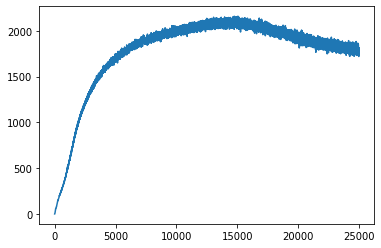

In [17]:
plt.plot(losses);

In [18]:
pt_cl, pt_cl_list = langevin_dynamics(score_net, sigmas, eps=0.001, num_steps=1000)

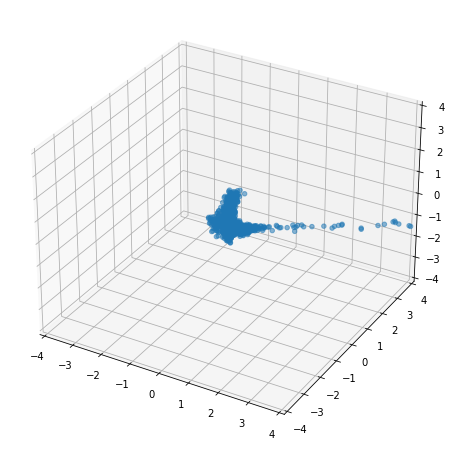

In [19]:
# Visualization
from mpl_toolkits.mplot3d import Axes3D
#for pt_cl_item in pt_cl_list:
#    visualize(pt_cl_item)
#visualize(pt_cl_item)
visualize(pt_cl_list[-1])

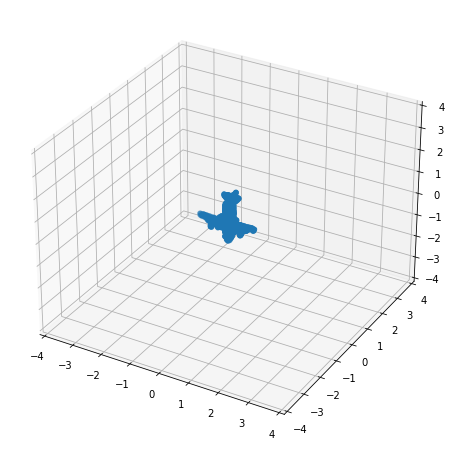

In [20]:
visualize(tr_pts)

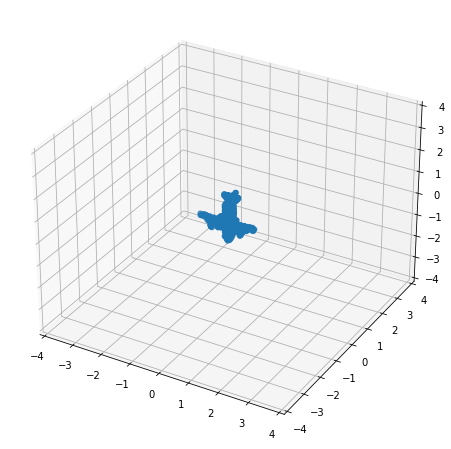

In [21]:
visualize(perturbed_points)